In [1]:
#@title Imports

#!pip install Unidecode
#from unidecode import unidecode
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import ast

from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import scipy.stats

from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
import numpy as np

all_the_years = np.arange(1974, 2023, 1)
some_of_the_years = np.arange(1997, 2023, 1)
pd.set_option('display.colheader_justify', 'center')


sns.set_style('darkgrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes



**SCRAPE**

In [ ]:
#@title Scrape NBA regular season per 100
def scrape_nba_player_per100_data(years):

    final_players_per100_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS', 
                                                    'ORtg', 'DRtg']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('', axis=1)
        
        # append to final df
        final_players_per100_df = final_players_per100_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_per100_df = final_players_per100_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_per100_df['Player'] = final_players_per100_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_per100_df = final_players_per100_df.dropna()
        
    # print final_df
    print(final_players_per100_df.info)
    final_players_per100_df.to_csv("nba_player_since74_per100_data.csv", index=False)
scrape_nba_player_per100_data(all_the_years)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<bound method DataFrame.info of      Year TS%+ TeamColor        Player        Pos Age  Tm   G   GS   MP   ...  \
0    1974   0       0         Zaid Abdul-Aziz   C  27  HOU  79      2459  ...   
1    1974   0       0     Kareem Abdul-Jabbar   C  26  MIL  81      3548  ...   
2    1974   0       0               Don Adams  SF  26  DET  74      2298  ...   
3    1974   0       0            Rick Adelman  PG  27  CHI  55       618  ...   
4    1974   0       0            Lucius Allen  PG  26  MIL  72      2388  ...   
..    ...  ...       ...                  ...  ..  ..  ...  ..  ..   ...  ...   
805  2022   0       0          Thaddeus Young  PF  33  TOT  52   1   845  ...   
808  2022   0       0              Trae Young  PG  23  ATL  76  76  2652  ...   
809  2022   0       0          Omer Yurtseven   C  23  MIA  56  12   706  ...   
810  2022   0       0             Cody Zeller   C  29  POR  27   0   355  ...   
811  2022   0       0             Ivica Zubac   C  24  LAC  76  76  1852  ...

In [ ]:
#@title Scrape NBA regular season advanced
def scrape_nba_advanced_data(years):

    final_players_advanced_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age', 
                                                        'Tm', 'TeamColor', 'G', 'MP', 'PER', 'TS%', 
                                                        '3PAr', 'FTr', 'ORB%', 'DRB%', 
                                                        'TRB%', 'AST%', 'STL%', 'BLK%', 
                                                        'TOV%', 'USG%', 'OWS', 'DWS', 
                                                        'WS', 'WS/48', 'OBPM', 'DBPM', 
                                                        'BPM', 'VORP'
                                                        ])
    for year in years:
        player_advanced_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html"
        
        html = urlopen(player_advanced_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_advanced_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_advanced_stats = [e for e in player_advanced_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_advanced_stats)):
             player_advanced_stats[i].insert(0, year)
             player_advanced_stats[i].insert(5, 0)
        headers.insert(0, "Year")
        headers.insert(5, "TeamColor")

        each_year = pd.DataFrame(player_advanced_stats, columns = headers)
        
        # remove blank columns
        each_year = each_year.drop('\xa0',axis=1)

        # append dataframe
        final_players_advanced_df = final_players_advanced_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '')
        #final_players_advanced_df['Player'] = final_players_advanced_df['Player'].apply(ast.literal_eval).str.decode("utf-8")
        #final_players_advanced_df['Player'] = unidecode(final_players_advanced_df['Player'])
        final_players_advanced_df['Player'].apply(unidecode)

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()
        
    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("nba_player_since74_advanced_data.csv", index=False)
scrape_nba_advanced_data(all_the_years)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: FutureWarning: The default value of regex will change from True to False in a future version.


<bound method DataFrame.info of      Year        Player        Pos Age  Tm  TeamColor  G    MP   PER   TS%   \
0    1974      Zaid Abdul-Aziz   C  27  HOU      0     79  2459  15.9  .516   
1    1974  Kareem Abdul-Jabbar   C  26  MIL      0     81  3548  24.4  .564   
2    1974            Don Adams  SF  26  DET      0     74  2298  10.9  .457   
3    1974         Rick Adelman  PG  27  CHI      0     55   618  10.0  .447   
4    1974         Lucius Allen  PG  26  MIL      0     72  2388  18.8  .536   
..    ...                  ...  ..  ..  ...       ...  ..   ...   ...   ...   
805  2022       Thaddeus Young  PF  33  TOT      0     52   845  17.0  .548   
808  2022           Trae Young  PG  23  ATL      0     76  2652  25.4  .603   
809  2022       Omer Yurtseven   C  23  MIA      0     56   706  17.4  .546   
810  2022          Cody Zeller   C  29  POR      0     27   355  17.2  .627   
811  2022          Ivica Zubac   C  24  LAC      0     76  1852  19.2  .660   

     ...  TOV%  USG

In [ ]:
#@title Scrape NBA regular season play-by-play

# import needed libraries
def scrape_nba_playbyplay_data(years):
 
    final_players_playbyplay_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age',
                                                          'Tm', 'G', 'MP','OnCourt', 'On-Off', 'BadPass', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1'
                                                         ])
    
    for year in years:
        player_playbyplay_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_play-by-play.html"
        
        html = urlopen(player_playbyplay_url)
        soup = BeautifulSoup(html, features="lxml")
        
        # grab tr[1], as tr[0] is populated with categorical headers. Not headers for each columns of data (which are in tr[1])
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        headers = headers[1:headers.index("Blkd")+1]


        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_playbyplay_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_playbyplay_stats = [e for e in player_playbyplay_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_playbyplay_stats)):
             player_playbyplay_stats[i].insert(0, year)   
        headers.insert(0, "Year")

        each_year = pd.DataFrame(player_playbyplay_stats, columns = headers)

        #rename some columns for less ambiguity
        each_year.columns=['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP','PG%', 'SG%', 'SF%', 'PF%', 'C%',
                            'OnCourt', 'On-Off', 'BadPass', 'LostBall', 'ShootCommit', 'OffCommit', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1', 'Blkd']
        # drop irrelevant columns
        each_year = each_year.drop(['PG%', 'SG%', 'SF%', 'PF%', 'C%', 'LostBall', 'ShootCommit', 'OffCommit', 'Blkd'], axis=1)

        # append dataframe
        final_players_playbyplay_df = final_players_playbyplay_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_playbyplay_df = final_players_playbyplay_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_playbyplay_df['Player'] = final_players_playbyplay_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_playbyplay_df = final_players_playbyplay_df.dropna()
        
    # print final_df
    print(final_players_playbyplay_df.info)
    final_players_playbyplay_df.to_csv("nba_player_regular_playbyplay_data.csv", index=False)
scrape_nba_playbyplay_data(some_of_the_years)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: FutureWarning: The default value of regex will change from True to False in a future version.


<bound method DataFrame.info of      Year        Player        Pos Age  Tm   G    MP  OnCourt On-Off BadPass  \
0    1997   Mahmoud Abdul-Rauf  PG  27  SAC  75  2131    -5.9  -3.2      73    
1    1997  Shareef Abdur-Rahim  PF  20  VAN  80  2802   -11.5  -3.9      85    
2    1997       Rafael Addison  SF  32  CHH  41   355    -3.3  -7.6       7    
3    1997       Cory Alexander  PG  23  SAS  80  1454    -9.7  -1.1      83    
4    1997         Jerome Allen  SG  24  TOT  76   943    -2.6  -1.8      50    
..    ...                  ...  ..  ..  ...  ..   ...     ...    ...     ...   
805  2022       Thaddeus Young  PF  33  TOT  52   845     1.8   0.6      33    
808  2022           Trae Young  PG  23  ATL  76  2652     2.9   3.4     221    
809  2022       Omer Yurtseven   C  23  MIA  56   706     4.8   0.3      13    
810  2022          Cody Zeller   C  29  POR  27   355    -2.8   6.8       5    
811  2022          Ivica Zubac   C  24  LAC  76  1852    -3.5  -6.8      36    

    Sho

In [ ]:
#@title Scrape NBA playoffs per 100
def scrape_nba_player_per100_data(years):

    final_players_per100_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS', 
                                                    'ORtg', 'DRtg']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('', axis=1)
        
        # append to final df
        final_players_per100_df = final_players_per100_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_per100_df = final_players_per100_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_per100_df['Player'] = final_players_per100_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_per100_df = final_players_per100_df.dropna()
        
    # print final_df
    print(final_players_per100_df.info)
    final_players_per100_df.to_csv("nba_player_since74playoffs_per100_data.csv", index=False)
scrape_nba_player_per100_data(all_the_years)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: FutureWarning: The default value of regex will change from True to False in a future version.


<bound method DataFrame.info of      Year TS%+ TeamColor        Player        Pos Age  Tm   G  GS  MP   ...  \
0    1974   0       0     Kareem Abdul-Jabbar   C  26  MIL  16     758  ...   
1    1974   0       0               Don Adams  SF  26  DET   7     256  ...   
2    1974   0       0            Rick Adelman  PG  27  CHI   9     108  ...   
3    1974   0       0           Dennis Awtrey   C  25  CHI  10     158  ...   
4    1974   0       0             Henry Bibby  PG  24  NYK  10      89  ...   
..    ...  ...       ...                  ...  ..  ..  ...  .. ..  ...  ...   
212  2022   0       0         Ziaire Williams  SF  20  MEM  10  1  168  ...   
213  2022   0       0            Delon Wright  SG  29  ATL   5  0  137  ...   
214  2022   0       0          Thaddeus Young  PF  33  TOR   6  0   87  ...   
215  2022   0       0              Trae Young  PG  23  ATL   5  5  186  ...   
216  2022   0       0          Omer Yurtseven   C  23  MIA   9  0   38  ...   

     DRB   TRB  AST

In [ ]:
#@title Scrape NBA playoffs advanced
def scrape_nba_advanced_data(years):

    final_players_advanced_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age', 
                                                        'Tm', 'TeamColor', 'G', 'MP', 'PER', 'TS%', 
                                                        '3PAr', 'FTr', 'ORB%', 'DRB%', 
                                                        'TRB%', 'AST%', 'STL%', 'BLK%', 
                                                        'TOV%', 'USG%', 'OWS', 'DWS', 
                                                        'WS', 'WS/48', 'OBPM', 'DBPM', 
                                                        'BPM', 'VORP'
                                                        ])
    for year in years:
        player_advanced_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_advanced.html"
        
        html = urlopen(player_advanced_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_advanced_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_advanced_stats = [e for e in player_advanced_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_advanced_stats)):
             player_advanced_stats[i].insert(0, year)
             player_advanced_stats[i].insert(5, 0)
        headers.insert(0, "Year")
        headers.insert(5, "TeamColor")

        each_year = pd.DataFrame(player_advanced_stats, columns = headers)
        
        # remove blank columns
        each_year = each_year.drop('\xa0',axis=1)

        # append dataframe
        final_players_advanced_df = final_players_advanced_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '')
        #final_players_advanced_df['Player'] = final_players_advanced_df['Player'].apply(ast.literal_eval).str.decode("utf-8")
        #final_players_advanced_df['Player'] = unidecode(final_players_advanced_df['Player'])
        final_players_advanced_df['Player'].apply(unidecode)

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()
        
    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("nba_player_since74playoffs_advanced_data.csv", index=False)
scrape_nba_advanced_data(all_the_years)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: FutureWarning: The default value of regex will change from True to False in a future version.


<bound method DataFrame.info of      Year        Player        Pos Age  Tm  TeamColor  G   MP   PER   TS%   \
0    1974  Kareem Abdul-Jabbar   C  26  MIL      0     16  758  28.3  .583   
1    1974            Don Adams  SF  26  DET      0      7  256  10.0  .404   
2    1974         Rick Adelman  PG  27  CHI      0      9  108  13.8  .502   
3    1974        Dennis Awtrey   C  25  CHI      0     10  158  10.9  .463   
4    1974          Henry Bibby  PG  24  NYK      0     10   89  13.4  .418   
..    ...                  ...  ..  ..  ...       ...  ..  ...   ...   ...   
212  2022      Ziaire Williams  SF  20  MEM      0     10  168  11.8  .598   
213  2022         Delon Wright  SG  29  ATL      0      5  137  15.9  .622   
214  2022       Thaddeus Young  PF  33  TOR      0      6   87  14.3  .506   
215  2022           Trae Young  PG  23  ATL      0      5  186   5.3  .461   
216  2022       Omer Yurtseven   C  23  MIA      0      9   38  25.8  .647   

     ...  TOV%  USG%  OWS  DWS 

In [ ]:
#@title Scrape NBA playoffs play-by-play
# import needed libraries
def scrape_nba_playbyplay_data(years):
 
    final_players_playbyplay_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age',
                                                          'Tm', 'G', 'MP','OnCourt', 'On-Off', 'BadPass', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1'
                                                         ])
    
    for year in years:
        player_playbyplay_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_play-by-play.html"
        
        html = urlopen(player_playbyplay_url)
        soup = BeautifulSoup(html, features="lxml")
        
        # grab tr[1], as tr[0] is populated with categorical headers. Not headers for each columns of data (which are in tr[1])
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        headers = headers[1:headers.index("Blkd")+1]


        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_playbyplay_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_playbyplay_stats = [e for e in player_playbyplay_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_playbyplay_stats)):
             player_playbyplay_stats[i].insert(0, year)   
        headers.insert(0, "Year")

        each_year = pd.DataFrame(player_playbyplay_stats, columns = headers)

        #rename some columns for less ambiguity
        each_year.columns=['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP','PG%', 'SG%', 'SF%', 'PF%', 'C%',
                            'OnCourt', 'On-Off', 'BadPass', 'LostBall', 'ShootCommit', 'OffCommit', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1', 'Blkd']
        # drop irrelevant columns
        each_year = each_year.drop(['PG%', 'SG%', 'SF%', 'PF%', 'C%', 'LostBall', 'ShootCommit', 'OffCommit', 'Blkd'], axis=1)

        # append dataframe
        final_players_playbyplay_df = final_players_playbyplay_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_playbyplay_df = final_players_playbyplay_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_playbyplay_df['Player'] = final_players_playbyplay_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_playbyplay_df = final_players_playbyplay_df.dropna()
        
    # print final_df
    print(final_players_playbyplay_df.info)
    final_players_playbyplay_df.to_csv("nba_player_playoff_playbyplay_data.csv", index=False)
scrape_nba_playbyplay_data(some_of_the_years)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: FutureWarning: The default value of regex will change from True to False in a future version.


<bound method DataFrame.info of      Year       Player       Pos Age  Tm   G   MP  OnCourt On-Off BadPass  \
0    1997     Kenny Anderson  PG  26  POR   4  169    -8.1   -5.6     5     
1    1997      Nick Anderson  SG  29  ORL   5  130   -10.8   -4.8     3     
2    1997   Shandon Anderson  SG  23  UTA  18  296   -12.1  -15.6     4     
3    1997    Willie Anderson  SG  30  MIA   9  120   -11.8  -13.9     7     
4    1997  Darrell Armstrong  PG  28  ORL   5  143    14.1   56.5     3     
..    ...                ...  ..  ..  ...  ..  ...     ...    ...     ...   
212  2022    Ziaire Williams  SF  20  MEM  10  168    -7.5  -14.0     1     
213  2022       Delon Wright  SG  29  ATL   5  137     6.8   46.8     2     
214  2022     Thaddeus Young  PF  33  TOR   6   87    -2.9    9.5     3     
215  2022         Trae Young  PG  23  ATL   5  186   -16.9  -16.1    16     
216  2022     Omer Yurtseven   C  23  MIA   9   38     7.8    3.9     0     

    ShootDrawn OffDrawn PGA And1  
0       

In [ ]:
#@title Scrape NBA regular season league average
def scrape_nba_leaguestats_data():

        final_leaguestats_df = pd.DataFrame(columns = ['Year',	'Lg',	'Age',	'Ht',	'Wt',	'G',	'MP',	'FG',	'FGA',	'3P',
                                                      '3PA',	'FT',	'FTA',	'ORB',	'DRB',	'TRB',	'AST',	'STL',	'BLK',	'TOV',
                                                      'PF',	'PTS',	'FG%',	'3P%',	'FT%',	'Pace',	'eFG%',	'TOV%',	'ORB%',
                                                      'FT/FGA',	'ORtg', 'TS%'])
        
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_stats_per_game.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        headers = headers[1:headers.index("ORtg")+1]
        headers.insert(32, "TS%")
        print(headers)

        # grab rows (excluding first empty row 0)
        #rows = soup.findAll('tr', class=None)[1:]
        rows = soup.findAll('tr', class_=None)[1:]


        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]
        for i in range(0, len(player_base_stats)):
          player_base_stats[i].insert(32, 0)

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        final_leaguestats_df = pd.DataFrame(player_base_stats, columns = headers)

        final_leaguestats_df = final_leaguestats_df.drop(['Lg'], axis=1)

        final_leaguestats_df = final_leaguestats_df.iloc[1: , :]

        final_leaguestats_df.drop(final_leaguestats_df.index[20])
        final_leaguestats_df.drop(final_leaguestats_df.index[21])
        
        # print final_df
        print(final_leaguestats_df.info)
        final_leaguestats_df.to_csv("nba_leaguestats_data.csv", index=False)
scrape_nba_leaguestats_data()

['Season', 'Lg', 'Age', 'Ht', 'Wt', 'G', 'MP', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'FG%', '3P%', 'FT%', 'Pace', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'ORtg', 'TS%']
<bound method DataFrame.info of     Season   Age   Ht   Wt    G     MP     FG   FGA    3P   3PA   ...  FG%   \
1   2020-21  26.1  6-6  217  1080  241.4  41.2  88.4  12.7  34.6  ...  .466   
2   2019-20  26.1  6-6  218  1059  241.8  40.9  88.8  12.2  34.1  ...  .460   
3   2018-19  26.3  6-6  219  1230  241.6  41.1  89.2  11.4  32.0  ...  .461   
4   2017-18  26.4  6-7  220  1230  241.4  39.6  86.1  10.5  29.0  ...  .460   
5   2016-17  26.6  6-7  221  1230  241.6  39.0  85.4   9.7  27.0  ...  .457   
..      ...   ...  ...  ...   ...    ...   ...   ...   ...   ...  ...   ...   
71  1950-51                   354         29.8  83.6              ...  .357   
72  1949-50                   561         28.2  83.1              ...  .340   
73  1948-49                   3

**PEAK FUNCTION DEFINITIONS**

In [ ]:
#@title 2 year non-consecutive peaks function

# def twoyearpeak(df, valuestring):
# returns a dataframe containing 2 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 2 year stretches of 'valuestring' AND the listed years from each 2 year stretch + minutes played across the 2 seasons.
# EX: twoyearpeak(import_player_since74_per100_df, 'PTS') returns 3 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2018-19', 'Kris Middleton', 'MIL' '23.32', '4231'
def twoyearpeak(df, valuestring):
  two_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue and minutes
    prev_1back = 0
    prev_1min = 0


    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    two_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store the team a player played with 1 season and 2 seasons ago in case they change teams during peak 3 years.
    prevYearTeam = 0

    prevyear = 0

    indexlist = []
    running_two_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min)
          if running_min == 0:
            running_min = 1
          running_two_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          old_team = prevYearTeam

          if inner_row['Year'] != present_year:
            prevYearTeam = 0
            prevyear = 0
            prev_1back = 0
            prev_1min = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+1 and len(indexlist) >=2:
            if (prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prevyear, present_year)
            else:
              present_peak_years = '{}, {}'.format(prevyear, present_year)

          if two_seasons_count == original_year+3 and len(indexlist) >=3:
            two_seasons_count = player['Year']
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
          if present_year > original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']
            prevYearTeam = inner_row['Tm']

          two_seasons_count = two_seasons_count + 1

          if len(indexlist) >=2:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP']
            if (prevYearTeam == old_team and prevYearTeam == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_two_year_peak_val, running_min]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_two_year_peak_val, running_min]], columns=cols)
            two_year_peak = two_year_peak.append(df_temp)
            outfile = f"two_year_peak_{valuestring}_data.csv"
            two_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 2 year fragmented peaks function

# def twoyearpeak(df, valuestring):
# returns a dataframe containing 2 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 2 year stretches of 'valuestring' AND the listed years from each 2 year stretch + minutes played across the 2 seasons.
# EX: twoyearpeak(import_player_since74_per100_df, 'PTS') returns 3 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2018-19', 'Kris Middleton', 'MIL' '23.32', '4231'
def fragtwoyearpeak(df, valuestring):
  two_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue and minutes played
    prev_1back = 0
    prev_1min = 0

    # peak start and end season
    present_peak_years = [0, 0]

    # starting season original value
    present_year = player['Year']
    two_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store team player played on a season and 2 seasons ago in case they change teams during peak 3 years.
    prevyear = 0
    prevYearTeam = 0

    indexlist = []
    running_two_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min)
          if running_min == 0:
            running_min = 1
          running_two_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          old_team = prevYearTeam

          if inner_row['Year'] != present_year:
            prevYearTeam = 0
            prev_1back = 0
            prev_1min = 0
            prevyear = 0
            indexlist = []


          # can finally store years as this player has had 2 consecutive seasons (not reached after 2 rows of a player is found)
          if present_year >= original_year+1 and len(indexlist) >=2:
            if (prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prevyear, present_year)
            else:
              present_peak_years = '{}, {}'.format(prevyear, present_year)

          if two_seasons_count == original_year+2 and len(indexlist) >=2:
            two_seasons_count = player['Year']

          # move present value to previous year's value
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']

          two_seasons_count = two_seasons_count + 1

          if len(indexlist) >=2:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP']
            if (old_team == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_two_year_peak_val, running_min]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_two_year_peak_val, running_min]], columns=cols)
            two_year_peak = two_year_peak.append(df_temp)
            outfile = f"two_year_peak_{valuestring}_data.csv"
            two_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 2 year non-consecutive peaks function

# def twoyearpeak(df, valuestring):
# returns a dataframe containing 2 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 2 year stretches of 'valuestring' AND the listed years from each 2 year stretch + minutes played across the 2 seasons.
# EX: twoyearpeak(import_player_since74_per100_df, 'PTS') returns 3 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2018-19', 'Kris Middleton', 'MIL' '23.32', '4231'
def twoyearpeak(df, valuestring):
  two_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue and minutes
    prev_1back = 0
    prev_1min = 0
    prev_1g = 0


    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    two_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store the team a player played with 1 season and 2 seasons ago in case they change teams during peak 3 years.
    prevYearTeam = 0

    prevyear = 0


    indexlist = []
    running_two_year_peak_val = 0
    running_min = 0
    games = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min)
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + prev_1g
          running_two_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          old_team = prevYearTeam

          if inner_row['Year'] != present_year:
            prevYearTeam = 0
            prevyear = 0
            prev_1back = 0
            prev_1min = 0
            prev_1g = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+1 and len(indexlist) >=2:
            if (prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prevyear, present_year)
            else:
              present_peak_years = '{}, {}'.format(prevyear, present_year)

          if two_seasons_count == original_year+3 and len(indexlist) >=3:
            two_seasons_count = player['Year']
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prev_1g = inner_row['G']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
          if present_year > original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prev_1g = inner_row['G']
            prevyear = inner_row['Year']
            prevYearTeam = inner_row['Tm']

          two_seasons_count = two_seasons_count + 1

          if len(indexlist) >=2:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            if (prevYearTeam == old_team and prevYearTeam == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_two_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_two_year_peak_val, running_min, games]], columns=cols)
            two_year_peak = two_year_peak.append(df_temp)
            outfile = f"two_year_peak_{valuestring}_data.csv"
            two_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 3 year non-consecutive peaks function

# def threeyearpeak(df, valuestring):
# returns a dataframe containing 3 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 3 year stretches of 'valuestring' AND the listed years from each 3 year stretch + minutes played across the 3 seasons.
# EX: threeyearpeak(import_player_since74_per100_df, 'PTS') returns 3 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2018-20', 'Kris Middleton', 'MIL' '23.32', '7120'
def threeyearpeak(df, valuestring):
  three_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue and minutes
    prev_1back = 0
    prev_1min = 0
    prev_1g = 0

    # 2 seasons ago's peakvalue and minutes
    prev_2back = 0
    prev_2min = 0
    prev_2g = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    three_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store the team a player played with 1 season and 2 seasons ago in case they change teams during peak 3 years.
    prevYearTeam = 0
    prev2YearTeam = 0

    # previous two years; e.g. 2014, 2015 before 2016. 2016, 2019 if these were the two most recent seasons for a player before 2020.
    prevyear = 0
    prev2year = 0

    indexlist = []
    running_three_year_peak_val = 0
    running_min = 0
    games = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min)
          if running_min == 0:
            running_min = 1
          games = (inner_row['G'] + prev_1g + prev_2g)
          running_three_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          old_team = prev2YearTeam

          if inner_row['Year'] != present_year:
            prevYearTeam = 0
            prev2YearTeam = 0
            prevyear = 0
            prev2year = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_1g = 0
            prev_2g = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+2 and len(indexlist) >=3:
            if (prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev2year, present_year)
            else:
              present_peak_years = '{}, {}, {}'.format(prev2year, prevyear, present_year)

          if three_seasons_count == original_year+3 and len(indexlist) >=3:
            three_seasons_count = player['Year']
          if present_year == original_year+1:
            prev_2back = prev_1back
            prev2YearTeam = prevYearTeam
            prev_2min = prev_1min
            prev_2g = prev_1g
            prev2year = prevyear
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prev_1g = inner_row['G']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
          if present_year > original_year:
            prev_2back = prev_1back
            prev_2g = prev_1g
            prev_2min = prev_1min
            prev2YearTeam = prevYearTeam
            prev2year = prevyear
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prev_1g = inner_row['G']
            prevyear = inner_row['Year']
            prevYearTeam = inner_row['Tm']

          three_seasons_count = three_seasons_count + 1

          if len(indexlist) >=3:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            if (prevYearTeam == old_team and prevYearTeam == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_three_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_three_year_peak_val, running_min, games]], columns=cols)
            three_year_peak = three_year_peak.append(df_temp)
            outfile = f"three_year_peak_{valuestring}_data.csv"
            three_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 5 year non-consecutive peaks function

# def fiveyearpeak(df, valuestring):
# returns a dataframe containing 5 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 5 year stretches of 'valuestring' AND the listed years from each 5 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 5 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2016-20', 'Kris Middleton', 'MIL' '22.11', '12139'
def fiveyearpeak(df, valuestring):
  five_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0
    prev_1g = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0
    prev_2g = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0
    prev_3g = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0
    prev_4g = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    five_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store team player played on a season and 2 seasons ago in case they change teams during peak 3 years.
    prevYearTeam = 0
    prev2YearTeam = 0
    prev3YearTeam = 0
    prev4YearTeam = 0

    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0


    indexlist = []
    running_five_year_peak_val = 0
    running_min = 0
    games = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    dis_old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min)
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + prev_4g + prev_3g + prev_2g + prev_1g
          running_five_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          dis_old_team = prev4YearTeam

          if inner_row['Year'] != present_year:
            prevYearTeam = 0
            prev2YearTeam = 0
            prev3YearTeam = 0
            prev4YearTeam = 0
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            prev_1g = 0
            prev_2g = 0
            prev_3g = 0
            prev_4g = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+4 and len(indexlist) >=5:
            if (prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev4year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}'.format(prev4year, prev3year, prev2year, prevyear, present_year)

          if five_seasons_count == original_year+5 and len(indexlist) >=5:
            five_seasons_count = player['Year']
          if present_year == original_year+1:
            
            prev_4back = prev_3back
            prev4YearTeam = prev3YearTeam
            prev_4min = prev_3min
            prev4year = prev3year
            prev_4g = prev_3g

            prev_3back = prev_2back
            prev3YearTeam = prev2YearTeam
            prev_3min = prev_2min
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev2YearTeam = prevYearTeam
            prev_2min = prev_1min
            prev2year = prevyear
            prev_2g = prev_1g
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
            prev_1g = inner_row['G']
          if present_year > original_year:
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4YearTeam = prev3YearTeam
            prev4year = prev3year
            prev_4g = prev_3g

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3YearTeam = prev2YearTeam
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2YearTeam = prevYearTeam
            prev2year = prevyear
            prev_2g = prev_1g

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
            prev_1g = inner_row['G']

          five_seasons_count = five_seasons_count + 1

          if len(indexlist) >=5:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            if (inner_row['Tm'] == dis_old_team and inner_row['Tm'] == prev3YearTeam and inner_row['Tm'] == prev2YearTeam and prevYearTeam == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_five_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_five_year_peak_val, running_min, games]], columns=cols)
            five_year_peak = five_year_peak.append(df_temp)
            outfile = f"five_year_peak_{valuestring}_data.csv"
            five_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 8 year non-consecutive peaks function

# def eightyearpeak(df, valuestring):
# returns a dataframe containing 10 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 10 year stretches of 'valuestring' AND the listed years from each 10 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 10 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2011-20', 'Kris Middleton', 'MIL' '22.11', '12139'
def eightyearpeak(df, valuestring):
  eight_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0
    prev_1g = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0
    prev_2g = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0
    prev_3g = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0
    prev_4g = 0

    # 5 seasons ago's peakvalue
    prev_5back = 0
    prev_5min = 0
    prev_5g = 0

    # 6 seasons ago's peakvalue
    prev_6back = 0
    prev_6min = 0
    prev_6g = 0

    # 7 seasons ago's peakvalue
    prev_7back = 0
    prev_7min = 0
    prev_7g = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    eight_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store team player played on a season and 2 seasons ago in case they change teams during peak 3 years.
    prevYearTeam = 0
    prev2YearTeam = 0
    prev3YearTeam = 0
    prev4YearTeam = 0
    prev5YearTeam = 0
    prev6YearTeam = 0
    prev7YearTeam = 0

    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0
    prev5year = 0
    prev6year = 0
    prev7year = 0


    indexlist = []
    running_eight_year_peak_val = 0
    running_min = 0
    games = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    dis_old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min + prev_5min + prev_6min + prev_7min)
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + prev_1g + prev_2g + prev_3g + prev_4g + prev_5g + prev_6g + prev_7g
          running_eight_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)) + (prev_5back * (prev_5min / running_min)) + (prev_6back * (prev_6min / running_min)) + (prev_7back * (prev_7min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          dis_old_team = prev7YearTeam

          if inner_row['Year'] != present_year:
            prevYearTeam = 0
            prev2YearTeam = 0
            prev3YearTeam = 0
            prev4YearTeam = 0
            prev5YearTeam = 0
            prev6YearTeam = 0
            prev7YearTeam = 0
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev5year = 0
            prev6year = 0
            prev7year = 0
            prev_7back = 0
            prev_6back = 0
            prev_5back = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            prev_5min = 0
            prev_6min = 0
            prev_7min = 0
            prev_1g = 0
            prev_2g = 0
            prev_3g = 0
            prev_4g = 0
            prev_5g = 0
            prev_6g = 0
            prev_7g = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+4 and len(indexlist) >=5:
            if (prev7year == (prev6year-1) and prev6year == (prev5year-1) and prev5year == (prev4year-1) and prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev7year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}, {}, {}'.format(prev7year, prev6year, prev5year, prev4year, prev3year, prev2year, prevyear, present_year)

          if eight_seasons_count == original_year+10 and len(indexlist) >=10:
            eight_seasons_count = player['Year']
          if present_year == original_year+1:

            prev_7back = prev_6back
            prev7YearTeam = prev6YearTeam
            prev_7min = prev_6min
            prev7year = prev6year
            prev_7g = prev_6g

            prev_6back = prev_5back
            prev6YearTeam = prev5YearTeam
            prev_6min = prev_5min
            prev6year = prev5year
            prev_6g = prev_5g

            prev_5back = prev_4back
            prev5YearTeam = prev4YearTeam
            prev_5min = prev_4min
            prev5year = prev4year
            prev_5g = prev_4g
            
            prev_4back = prev_3back
            prev4YearTeam = prev3YearTeam
            prev_4min = prev_3min
            prev4year = prev3year
            prev_4g = prev_3g

            prev_3back = prev_2back
            prev3YearTeam = prev2YearTeam
            prev_3min = prev_2min
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev2YearTeam = prevYearTeam
            prev_2min = prev_1min
            prev2year = prevyear
            prev_2g = prev_1g
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prev_1g = inner_row['G']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
          if present_year > original_year:

            prev_7back = prev_6back
            prev_7min = prev_6min
            prev7YearTeam = prev6YearTeam
            prev7year = prev6year
            prev_7g = prev_6g

            prev_6back = prev_5back
            prev_6min = prev_5min
            prev6YearTeam = prev5YearTeam
            prev6year = prev5year
            prev_6g = prev_5g

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5YearTeam = prev4YearTeam
            prev5year = prev4year
            prev_5g = prev_4g
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4YearTeam = prev3YearTeam
            prev4year = prev3year
            prev_4g = prev_3g

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3YearTeam = prev2YearTeam
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2YearTeam = prevYearTeam
            prev2year = prevyear
            prev_2g = prev_1g

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
            prev_1g = inner_row['G']

          eight_seasons_count = eight_seasons_count + 1

          if len(indexlist) >=8:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            if (inner_row['Tm'] == dis_old_team and inner_row['Tm'] == prev6YearTeam and inner_row['Tm'] == prev5YearTeam and inner_row['Tm'] == prev4YearTeam and inner_row['Tm'] == prev3YearTeam and inner_row['Tm'] == prev2YearTeam and prevYearTeam == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_eight_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_eight_year_peak_val, running_min, games]], columns=cols)
            eight_year_peak = eight_year_peak.append(df_temp)
            outfile = f"eight_year_peak_{valuestring}_data.csv"
            eight_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 10 year non-consecutive peaks function

# def tenyearpeak(df, valuestring):
# returns a dataframe containing 10 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 10 year stretches of 'valuestring' AND the listed years from each 10 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 10 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2011-20', 'Kris Middleton', 'MIL' '22.11', '12139'
def tenyearpeak(df, valuestring):
  ten_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0
    prev_1g = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0
    prev_2g = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0
    prev_3g = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0
    prev_4g = 0

    # 5 seasons ago's peakvalue
    prev_5back = 0
    prev_5min = 0
    prev_5g = 0

    # 6 seasons ago's peakvalue
    prev_6back = 0
    prev_6min = 0
    prev_6g = 0

    # 7 seasons ago's peakvalue
    prev_7back = 0
    prev_7min = 0
    prev_7g = 0

    # 8 seasons ago's peakvalue
    prev_8back = 0
    prev_8min = 0
    prev_8g = 0

    # 9 seasons ago's peakvalue
    prev_9back = 0
    prev_9min = 0
    prev_9g = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    ten_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store team player played on a season and 2 seasons ago in case they change teams during peak 3 years.
    prevYearTeam = 0
    prev2YearTeam = 0
    prev3YearTeam = 0
    prev4YearTeam = 0
    prev5YearTeam = 0
    prev6YearTeam = 0
    prev7YearTeam = 0
    prev8YearTeam = 0
    prev9YearTeam = 0

    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0
    prev5year = 0
    prev6year = 0
    prev7year = 0
    prev8year = 0
    prev9year = 0


    indexlist = []
    running_ten_year_peak_val = 0
    running_min = 0
    games = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    dis_old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min + prev_5min + prev_6min + prev_7min + prev_8min + prev_9min)
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + prev_1g + prev_2g + prev_3g + prev_4g + prev_5g + prev_6g + prev_7g + prev_8g + prev_9g
          running_ten_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)) + (prev_5back * (prev_5min / running_min)) + (prev_6back * (prev_6min / running_min)) + (prev_7back * (prev_7min / running_min)) + (prev_8back * (prev_8min / running_min)) + (prev_9back * (prev_9min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          dis_old_team = prev9YearTeam

          if inner_row['Year'] != present_year:
            prevYearTeam = 0
            prev2YearTeam = 0
            prev3YearTeam = 0
            prev4YearTeam = 0
            prev5YearTeam = 0
            prev6YearTeam = 0
            prev7YearTeam = 0
            prev8YearTeam = 0
            prev9YearTeam = 0
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev5year = 0
            prev6year = 0
            prev7year = 0
            prev8year = 0
            prev9year = 0
            prev_9back = 0
            prev_8back = 0
            prev_7back = 0
            prev_6back = 0
            prev_5back = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            prev_5min = 0
            prev_6min = 0
            prev_7min = 0
            prev_8min = 0
            prev_9min = 0
            prev_1g = 0
            prev_2g = 0
            prev_3g = 0
            prev_4g = 0
            prev_5g = 0
            prev_6g = 0
            prev_7g = 0
            prev_8g = 0
            prev_9g = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+4 and len(indexlist) >=5:
            if (prev9year == (prev8year-1) and prev8year == (prev7year-1) and prev7year == (prev6year-1) and prev6year == (prev5year-1) and prev5year == (prev4year-1) and prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev9year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}, {}, {}, {}, {}'.format(prev9year, prev8year, prev7year, prev6year, prev5year, prev4year, prev3year, prev2year, prevyear, present_year)

          if ten_seasons_count == original_year+10 and len(indexlist) >=10:
            ten_seasons_count = player['Year']
          if present_year == original_year+1:

            prev_9back = prev_8back
            prev9YearTeam = prev8YearTeam
            prev_9min = prev_8min
            prev9year = prev8year
            prev_9g = prev_8g

            prev_8back = prev_7back
            prev8YearTeam = prev7YearTeam
            prev_8min = prev_7min
            prev8year = prev7year
            prev_8g = prev_7g

            prev_7back = prev_6back
            prev7YearTeam = prev6YearTeam
            prev_7min = prev_6min
            prev7year = prev6year
            prev_7g = prev_6g

            prev_6back = prev_5back
            prev6YearTeam = prev5YearTeam
            prev_6min = prev_5min
            prev6year = prev5year
            prev_6g = prev_5g

            prev_5back = prev_4back
            prev5YearTeam = prev4YearTeam
            prev_5min = prev_4min
            prev5year = prev4year
            prev_5g = prev_4g
            
            prev_4back = prev_3back
            prev4YearTeam = prev3YearTeam
            prev_4min = prev_3min
            prev4year = prev3year
            prev_4g = prev_3g

            prev_3back = prev_2back
            prev3YearTeam = prev2YearTeam
            prev_3min = prev_2min
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev2YearTeam = prevYearTeam
            prev_2min = prev_1min
            prev2year = prevyear
            prev_2g = prev_1g
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
            prev_1g = inner_row['G']
          if present_year > original_year:

            prev_9back = prev_8back
            prev_9min = prev_8min
            prev9YearTeam = prev8YearTeam
            prev9year = prev8year
            prev_9g = prev_8g

            prev_8back = prev_7back
            prev_8min = prev_7min
            prev8YearTeam = prev7YearTeam
            prev8year = prev7year
            prev_8g = prev_7g

            prev_7back = prev_6back
            prev_7min = prev_6min
            prev7YearTeam = prev6YearTeam
            prev7year = prev6year
            prev_7g = prev_6g

            prev_6back = prev_5back
            prev_6min = prev_5min
            prev6YearTeam = prev5YearTeam
            prev6year = prev5year
            prev_6g = prev_5g

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5YearTeam = prev4YearTeam
            prev5year = prev4year
            prev_5g = prev_4g
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4YearTeam = prev3YearTeam
            prev4year = prev3year
            prev_4g = prev_3g

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3YearTeam = prev2YearTeam
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2YearTeam = prevYearTeam
            prev2year = prevyear
            prev_2g = prev_1g

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
            prev_1g = inner_row['G']

          ten_seasons_count = ten_seasons_count + 1

          if len(indexlist) >=10:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            if (inner_row['Tm'] == dis_old_team and inner_row['Tm'] == prev8YearTeam and inner_row['Tm'] == prev7YearTeam and inner_row['Tm'] == prev6YearTeam and inner_row['Tm'] == prev5YearTeam and inner_row['Tm'] == prev4YearTeam and inner_row['Tm'] == prev3YearTeam and inner_row['Tm'] == prev2YearTeam and prevYearTeam == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_ten_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_ten_year_peak_val, running_min, games]], columns=cols)
            ten_year_peak = ten_year_peak.append(df_temp)
            outfile = f"ten_year_peak_{valuestring}_data.csv"
            ten_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

**IMPORT RAW DATA**

In [ ]:
#@title Manually add playoff league average TS% (rather than scrape from statmuse), team abbrev, and teamcolors
playoff_league_avg_df = pd.DataFrame(columns=['Year','TS%'])

playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2022",
     "TS%":  .567, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2021",
     "TS%":  .571, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2020",
     "TS%":  .574, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2019",
     "TS%":  .551, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2018",
     "TS%":  .555, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2017",
     "TS%":  .563, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2016",
     "TS%":  .534, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2015",
     "TS%":  .526, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2014",
     "TS%":  .548, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2013",
     "TS%":  .529, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2012",
     "TS%":  .520, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2011",
     "TS%":  .529, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2010",
     "TS%":  .543, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2009",
     "TS%":  .544, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2008",
     "TS%":  .532, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2007",
     "TS%":  .530, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2006",
     "TS%":  .547, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({  
     "Year": "2005",
     "TS%":  .534, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2004",
     "TS%":  .500, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2003",
     "TS%":  .525, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2002",
     "TS%":  .514, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2001",
     "TS%":  .511, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "2000",
     "TS%":  .517, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1999",
     "TS%":  .508, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1998",
     "TS%":  .529, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1997",
     "TS%":  .535, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1996",
     "TS%":  .538, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1995",
     "TS%":  .552, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1994",
     "TS%":  .526, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
      "Year": "1993",
     "TS%":  .530, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1992",
     "TS%":  .545, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1991",
     "TS%":  .547, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1990",
     "TS%":  .542, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1989",
     "TS%":  .539, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1988",
     "TS%":  .548, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1987",
     "TS%":  .543, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1986",
     "TS%":  .549, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1985",
     "TS%":  .540, }, ignore_index=True)   
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1984",
     "TS%":  .540, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1983",
     "TS%":  .526, }, ignore_index=True) 
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1982",
     "TS%":  .521, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1981",
     "TS%":  .519, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
    "Year": "1980",
     "TS%":  .522, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1979",
     "TS%":  .503, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1978",
     "TS%":  .507, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1977",
     "TS%":  .511, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1976",
     "TS%":  .509, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1975",
     "TS%":  .502, }, ignore_index=True)
playoff_league_avg_df = playoff_league_avg_df.append({
     "Year": "1974",
     "TS%":  .491, }, ignore_index=True)

team_colors = {"ATL": "#E03A3E", "BOS": "#007A33", "BRK": "#000000", "BUF": "#ff6314", "CAP": "#E31837", "CHA": "#00788C", 
               "CHI": "#CE1141", "CHO": "#f26631", "CLE": "#860038", "DAL": "#00538C", "DEN": "#0E2240", "DET": "#1D42BA",
               "GSW": "#FFC72C", "HOU": "#CE1141", "IND": "#002D62", "KCO": "#5A2D81", "KCK": "#5A2D81", "LAC": "#C8102E", 
               "LAL": "#552583", "MEM": "#5D76A9", "MIA": "#98002E", "MIL": "#00471B", "MIN": "#78BE20", "NOH": "#008fc5", 
               "NOP": "#85714D", "NOJ": "#00471B", "NJN": "#00275d", "NYK": "#006BB6", "OKC": "#007AC1", "ORL": "#0077C0", 
               "PHI": "#006BB6", "PHO": "#1D1160", "POR": "#E03A3E", "SAC": "#5A2D81", "SAS": "#C4CED4", "SEA": "#00653A", 
               "TOR": "#CE1141", "TOT": "pink", "UTA": "#00471B", "WAS": "#E31837", "WSB": "#E31837"}

team_abbrev = {"Atlanta Hawks" : "ATL",       "Boston Celtics": "BOS",        "Brooklyn Nets": "BRK",         "Charlotte Bobcats": "CHA", 
               "Chicago Bulls": "CHI",      "Charlotte Hornets": "CHO",      "Cleveland Cavaliers": "CLE",     "Dallas Mavericks": "DAL",
               "Denver Nuggets": "DEN",     "Detroit Pistons": "DET",       "Golden State Warriors": "GSW",     "Houston Rockets": "HOU",
               "Indiana Pacers": "IND",     "Los Angeles Clippers": "LAC",  "Los Angeles Lakers": "LAL",      "Memphis Grizzlies": "MEM",
               "Miami Heat": "MIA",         "Milwaukee Bucks": "MIL",     "Minnesota Timberwolves": "MIN",  "New Orleans Hornets": "NOH",
               "New Orleans Pelicans": "NOP", "New Jersey Nets": "NJN",     "New York Knicks": "NYK",     "Oklahoma City Thunder": "OKC", 
               "Orlando Magic": "ORL",     "Philadelphia 76ers": "PHI",      "Phoenix Suns": "PHO",       "Portland Trail Blazers": "POR",
               "Sacramento Kings": "SAC",    "San Antonio Spurs": "SAS",       "Toronto Raptors": "TOR",               "Utah Jazz": "UTA", 
               "Washington Wizards": "WAS"}

In [ ]:
#@title Import data and add team colors for advanced, play-by-play, per 100, and league avg data

# per 100 posssessions
import_player_since74_per100_df = pd.read_csv('nba_player_since74_per100_data.csv')

# add team color for per 100 posssessions
import_player_since74_per100_df['TeamColor'] = import_player_since74_per100_df['Tm'].map(team_colors)

# per 100 playoff posssessions
import_player_since74playoffs_per100_df = pd.read_csv('nba_player_since74playoffs_per100_data.csv')

# add team color for playoff per 100 posssessions
import_player_since74playoffs_per100_df['TeamColor'] = import_player_since74playoffs_per100_df['Tm'].map(team_colors)



# advanced
import_player_since74_advanced_df = pd.read_csv('nba_player_since74_advanced_data.csv', encoding='utf8')

# advanced playoffs
import_player_since74playoffs_advanced_df = pd.read_csv('nba_player_since74playoffs_advanced_data.csv', encoding='utf8')



# play-by-play
import_player_regular_playbyplay_df = pd.read_csv('nba_player_regular_playbyplay_data.csv', encoding='utf8')

# add team color for play-by-play
import_player_regular_playbyplay_df['TeamColor'] = import_player_regular_playbyplay_df['Tm'].map(team_colors)

# play-by-play playoffs
import_player_since74playoffs_playbyplay_df = pd.read_csv('nba_player_playoff_playbyplay_data.csv', encoding='utf8')

# add team color for playoff play-by-play
import_player_since74playoffs_playbyplay_df['TeamColor'] = import_player_since74playoffs_playbyplay_df['Tm'].map(team_colors)





# import league avg data

# league avg
import_leagueavgsince74_df = pd.read_csv('nba_leaguestats_data.csv')

# drop NBA seasons from inception of league until 1973 (final year without per possession data)
import_leagueavgsince74_df.drop(import_leagueavgsince74_df.tail(26).index,inplace=True)

# change from '2020-21' to '2021' and '2019-20' to '2020'... and so on
for i, trial in import_leagueavgsince74_df.iterrows():
   import_leagueavgsince74_df.loc[i, "Season"] = 2022-i

In [ ]:
#@title Import per 75 data (can be used in place of 'Calculate per 75' cells with necessitated imported data')

# per 75 posssessions
import_player_since74_per75_df = pd.read_csv('nba_player_since74_per75_data.csv')

# add team color for per 75 posssessions
import_player_since74_per75_df['TeamColor'] = import_player_since74_per75_df['Tm'].map(team_colors)

# per 75 playoff posssessions
import_player_since74playoffs_per75_df = pd.read_csv('nba_player_since74playoffs_per75_data.csv')

# add team color for playoff per 75 posssessions
import_player_since74playoffs_per75_df['TeamColor'] = import_player_since74playoffs_per75_df['Tm'].map(team_colors)

**CALCULATE PER 75 AND TS+**

In [ ]:
#@title Calculate regular season per 75 and regular season TS+ (also league average TS%)
# Calculate league average TS%

  # real ts%
import_leagueavgsince74_df['TS%'] = import_leagueavgsince74_df['PTS'] / (import_leagueavgsince74_df['Pace'] * 2)

  # estimated ts%
# import_leagueavgsince74_df['TS%'] = import_leagueavgsince74_df['PTS'] / ((import_leagueavgsince74_df['FGA'] + (import_leagueavgsince74_df['FTA'] * .44)) * 2)

# Calculate per 75 points
import_player_since74_per75_df = import_player_since74_per100_df.copy()
import_player_since74_per75_df['PTS'] = import_player_since74_per75_df['PTS'] * .75

# Add TS+
i = 2022
for yearloop in range(49):
  for j, row in import_player_since74_per75_df.iterrows():
    if row['Year'] == i:
      import_player_since74_per75_df.iat[j, 1] = (import_player_since74_advanced_df.iat[j, 9] / import_leagueavgsince74_df.iat[yearloop, 30]) * 100
  i = i - 1

import_player_since74_per75_df = import_player_since74_per75_df[import_player_since74_per75_df['TS%+'].notna()]
outfile = f"nba_player_since74_per75_data.csv"
import_player_since74_per75_df.to_csv(outfile, index=False)

In [ ]:
#@title Calculate playoffs per 75 and playoffs TS+
# Calculate playoffs per 75
import_player_since74playoffs_per75_df = import_player_since74playoffs_per100_df.copy()
import_player_since74playoffs_per75_df['PTS'] = import_player_since74playoffs_per75_df['PTS'] * .75

# Calculate Playoffs TS+
i = 2022
for yearloop in range(49):
  for j, row in import_player_since74playoffs_per75_df.iterrows():
    if row['Year'] == i:
      import_player_since74playoffs_per75_df.iat[j, 1] = (import_player_since74playoffs_advanced_df.iat[j, 9] / playoff_league_avg_df.iat[yearloop, 1]) * 100
  i = i - 1

import_player_since74playoffs_per75_df = import_player_since74playoffs_per75_df[import_player_since74playoffs_per75_df['TS%+'].notna()]
outfile = f"nba_player_since74playoffs_per75_data.csv"
import_player_since74playoffs_per75_df.to_csv(outfile, index=False)

**Reg to Playoffs Calculations**

In [ ]:
#@title 2, 3, 5, 8, 10 YearRegToPlayoffsProduction Functions

# def twoYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every two year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def twoYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  players_finished = []

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = years.split()[2]
        year1 = int(year1)
        year2 = int(year2)
        season_list = '{} - {}'.format(year1, year2)
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)
        year2 = years.split()[1]
        year2 = int(year2)
        season_list = '{}, {}'.format(year1, year2)

      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2))]
      (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = just_reg_comp_output(row["Player"], player_reg_db, row)
      new_df.loc[len(new_df)] = [name, season_list, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
  outfile = f"Two_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)
  new_df.to_csv(outfile, index=False)
  print(new_df)

# def threeYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every three year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def threeYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  players_finished = []

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-1
        year3 = years.split()[2]
        year1 = int(year1)
        year3 = int(year3)
        season_list = '{} - {}'.format(year1, year3)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)
        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)
        year3 = years.split()[2]
        year3 = int(year3)
        season_list = '{}, {}, {}'.format(year1, year2, year3)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3))]
      (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = just_reg_comp_output(row["Player"], player_reg_db, row)
      new_df.loc[len(new_df)] = [name, season_list, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
  outfile = f"Three_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)
  new_df.to_csv(outfile, index=False)
  print(new_df)



# def fiveYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every five year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def fiveYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  players_finished = []

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-3
        year3 = int(years.split()[2])-2
        year4 = int(years.split()[2])-1
        year5 = years.strip().split()[2]

        year1 = int(year1)
        year5 = int(year5)

        season_list = '{} - {}'.format(year1, year5)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = int(year5)

        season_list = '{}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5))]
      (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = just_reg_comp_output(row["Player"], player_reg_db, row)
      new_df.loc[len(new_df)] = [name, season_list, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
  outfile = f"Five_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)
  new_df.to_csv(outfile, index=False)
  print(new_df)


# def eightYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every eight year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def eightYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  players_finished = []

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-6
        year3 = int(years.split()[2])-5
        year4 = int(years.split()[2])-4
        year5 = int(years.split()[2])-3
        year6 = int(years.split()[2])-2
        year7 = int(years.split()[2])-1
        year8 = years.strip().split()[2]

        year1 = int(year1)
        year8 = int(year8)

        season_list = '{} - {}'.format(year1, year8)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = int(year8)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8))]
      (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = just_reg_comp_output(row["Player"], player_reg_db, row)
      new_df.loc[len(new_df)] = [name, season_list, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
  outfile = f"Eight_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)
  new_df.to_csv(outfile, index=False)


# def tenYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every ten year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def tenYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  players_finished = []

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-8
        year3 = int(years.split()[2])-7
        year4 = int(years.split()[2])-6
        year5 = int(years.split()[2])-5
        year6 = int(years.split()[2])-4
        year7 = int(years.split()[2])-3
        year8 = int(years.split()[2])-2
        year9 = int(years.split()[2])-1
        year10 = years.strip().split()[2]

        year1 = int(year1)
        year10 = int(year10)

        season_list = '{} - {}'.format(year1, year10)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = year8.replace(',', '')
        year8 = int(year8)

        year9 = years.split()[8]
        year9 = year9.replace(',', '')
        year9 = int(year9)

        year10 = years.split()[9]
        year10 = int(year10)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8, year9, year10)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8) | (reg_df.Year == year9) | (reg_df.Year == year10))]
      (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = just_reg_comp_output(row["Player"], player_reg_db, row)
      new_df.loc[len(new_df)] = [name, season_list, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
  outfile = f"Ten_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)
  new_df.to_csv(outfile, index=False)

In [ ]:
#@title regToPlayoffs Calculation Functions

# def comparePlayers(a, b, df) 
# given player a and player b from DataFrame df, print the scoring rate and effieciency for each player
def comparePlayers(a, b, df):

  player_a = df[(df.Player == a)]
  player_b = df[(df.Player == b)]
  total_mp_a = 0
  total_pts_a = 0
  total_ts_a = 0

  total_mp_b = 0
  total_pts_b = 0
  total_ts_b = 0
  mp_list_a = []
  mp_list_b = []

  # find total minutes a
  for row in player_a['MP']:
    mp_list_a.append(row)
    total_mp_a += row
  print(player_a.iat[0, 3], "\nMP: ", total_mp_a)

  # find total PTS a
  i = 0
  for row in player_a['PTS']:
    total_pts_a += row * (mp_list_a[i] / total_mp_a)
    i = i + 1

  # find total TS+ a
  i = 0
  for row in player_a['TS%+']:
    total_ts_a += row * (mp_list_a[i] / total_mp_a)
    i = i + 1

  print("PTS per 75: ", total_pts_a)
  print("TS+: ",total_ts_a)

  # find total minutes
  for row in player_b['MP']:
    mp_list_b.append(row)
    total_mp_b += row
  print("\n")
  print(player_b.iat[0, 3], "\nminutes: ", total_mp_b)

  # find total PTS
  i = 0
  for row in player_b['PTS']:
    total_pts_b += row * (mp_list_b[i] / total_mp_b)
    i = i + 1

  # find total TS+
  i = 0
  for row in player_b['TS%+']:
    total_ts_b += row * (mp_list_b[i] / total_mp_b)
    i = i + 1

  print("PTS per 75: ", total_pts_b)
  print("TS+: ",total_ts_b)

# def reg_playoff_comp(a, dfa, dfb) 
# print the change in scoring rate and effieciency for player from regular season, dfa, to postseason, dfb
def reg_playoff_comp(a, dfa, dfb):

  player_a = dfa[(dfa.Player == a)]
  player_b = dfb[(dfb.Player == a)]
  total_mp_a = 0
  total_pts_a = 0
  total_ts_a = 0

  total_mp_b = 0
  total_pts_b = 0
  total_ts_b = 0
  mp_list_a = []
  mp_list_b = []

  # find total minutes a
  for row in player_a['MP']:
    mp_list_a.append(row)
    total_mp_a += row
  print(player_a.iat[0, 3], "\nRegular Season\n\nMP: ", total_mp_a)

  # find total PTS a
  i = 0
  for row in player_a['PTS']:
    total_pts_a += row * (mp_list_a[i] / total_mp_a)
    i = i + 1

  # find total TS+ a
  i = 0
  for row in player_a['TS%+']:
    total_ts_a += row * (mp_list_a[i] / total_mp_a)
    i = i + 1
  print("PTS per 75: ", total_pts_a)
  print("TS+: ",total_ts_a)

  # find total minutes
  for row in player_b['MP']:
    mp_list_b.append(row)
    total_mp_b += row
  print("\n")
  print(player_b.iat[0, 3], "\nPlayoffs\n\nminutes: ", total_mp_b)

  # find total PTS
  i = 0
  for row in player_b['PTS']:
    total_pts_b += row * (mp_list_b[i] / total_mp_b)
    i = i + 1

  # find total TS+
  i = 0
  for row in player_b['TS%+']:
    total_ts_b += row * (mp_list_b[i] / total_mp_b)
    i = i + 1

  print("PTS per 75: ", total_pts_b)
  print("TS+: ",total_ts_b)

  print("\n\nRegular Season to Playoffs Change\n")
  if total_pts_b-total_pts_a > 0:
    form_string = "PTS per 75: +{}".format(total_pts_b-total_pts_a)
    print(form_string)
  else: 
    print("PTS per 75: ", total_pts_b-total_pts_a)
  if total_ts_b-total_ts_a > 0:
    form_string = "TS+ {}".format(total_ts_b-total_ts_a)
    print(form_string)
  else:
    print("TS+: ",total_ts_b-total_ts_a)

# def reg_playoff_comp_output(a, dfa, dfb) 
# return the change in scoring rate and efficiency for player from regular season, dfa, to postseason, dfb.
# returned 'change' will be incorporated in larger output file
def reg_playoff_comp_output(a, dfa, dfb):

  player_a = dfa[(dfa.Player == a)]
  player_b = dfb[(dfb.Player == a)]
  total_mp_a = 0
  total_pts_a = 0
  total_ts_a = 0

  total_mp_b = 0
  total_pts_b = 0
  total_ts_b = 0
  mp_list_a = []
  mp_list_b = []

  # find total minutes a
  for row in player_a['MP']:
    mp_list_a.append(row)
    total_mp_a += row
  if total_mp_a == 0:
    total_mp_a = 1

  # find total PTS a
  i = 0
  for row in player_a['PTS']:
    total_pts_a += row * (mp_list_a[i] / total_mp_a)
    i = i + 1

  # find total TS+ a
  i = 0
  for row in player_a['TS%+']:
    total_ts_a += row * (mp_list_a[i] / total_mp_a)
    i = i + 1

  # find total minutes
  for row in player_b['MP']:
    mp_list_b.append(row)
    total_mp_b += row
  if total_mp_b == 0:
    total_mp_b = 1
  # find total PTS
  i = 0
  for row in player_b['PTS']:
    total_pts_b += row * (mp_list_b[i] / total_mp_b)
    i = i + 1

  # find total TS+
  i = 0
  for row in player_b['TS%+']:
    total_ts_b += row * (mp_list_b[i] / total_mp_b)
    i = i + 1


  if total_pts_b-total_pts_a > 0:
    form_pts_string = total_pts_b-total_pts_a
  else: 
    form_pts_string = total_pts_b-total_pts_a
  if total_ts_b-total_ts_a > 0:
    form_ts_string = total_ts_b-total_ts_a
  else:
    form_ts_string = total_ts_b-total_ts_a
  return (player_b.iat[0, 3], total_mp_a, total_mp_b, total_pts_a, total_pts_b, total_ts_a, total_ts_b, form_pts_string, form_ts_string)

def just_reg_comp_output(a, dfa, playoff_row):
  player_a = dfa
  total_mp_a = 0
  total_pts_a = 0
  total_ts_a = 0

  mp_list_a = []

  # find total minutes a
  for row in player_a['MP']:
    mp_list_a.append(row)
    total_mp_a += row
  if total_mp_a == 0:
    total_mp_a = 1

  # find total PTS a
  i = 0
  for row in player_a['PTS']:
    total_pts_a += row * (mp_list_a[i] / total_mp_a)
    i = i + 1

  # find total TS+ a
  i = 0
  for row in player_a['TS%+']:
    total_ts_a += row * (mp_list_a[i] / total_mp_a)
    i = i + 1

  form_pts_string = playoff_row['PTS']-total_pts_a
  form_ts_string = playoff_row['TS+']-total_ts_a
  return (a, total_mp_a, playoff_row['MP'], total_pts_a, playoff_row['PTS'], total_ts_a, playoff_row['TS+'], form_pts_string, form_ts_string)

In [ ]:
#@title regtoplayoffs career and prime production CSV functions

# output file containing change in scoring rate and efficiency from regular season to playoffs (Entire Career)
def regToPlayoffsProduction(reg_df, playoff_db):

  new_df = pd.DataFrame(columns = ['Player', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  headers_list = ['Player', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change']
  players_finished = []

  for idx, row in playoff_db.iterrows():
    if row['Player'] not in players_finished:
      player_reg_db = reg_df[(reg_df.Player == row["Player"])]
      player_playoff_db = playoff_db[(playoff_db.Player == row["Player"])]
      (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = reg_playoff_comp_output(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
      players_finished.append(row['Player'])
  outfile = f"Career_Playoff_Scoring_Change.csv"
  columns_titles = ['Player', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)
  new_df.to_csv(outfile, index=False)


# output file containing change in scoring rate and efficiency from regular season to playoffs (Entire Career)
# use only regular seasons in which a player made the playoffs
def regToPlayoffsProductionTightScope(reg_df, playoff_db):

  new_df = pd.DataFrame(columns = ['Player', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  headers_list = ['Player', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change']
  players_finished = []
  used_years = []

  for idx, row in playoff_db.iterrows():
    used_years = []
    if row['Player'] not in players_finished:
      player_playoff_db = playoff_db[(playoff_db.Player == row["Player"])]
      for use_idx, use_row in player_playoff_db.iterrows():
        used_years.append(use_row['Year'])
      player_reg_db = reg_df[reg_df['Year'].isin(used_years)]
      player_reg_db = player_reg_db[(player_reg_db.Player == row["Player"])]
      #rpt[rpt['STK_ID'].isin(stk_list)]
      (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = reg_playoff_comp_output(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
      players_finished.append(row['Player'])
  outfile = f"Tight_Career_Playoff_Scoring_Change.csv"
  columns_titles = ['Player', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)
  new_df.to_csv(outfile, index=False)

In [ ]:
#@title selective regToPlayoffs
def twoSelective(player, years):

  # create player dataframe
  selective_player = import_player_since74playoffs_per75_df[((import_player_since74playoffs_per75_df['Year'] == years[0]) | (import_player_since74playoffs_per75_df['Year'] == years[1]))]
  selective_player = selective_player[(selective_player['Player'] == player)]

  # create peaks
  twoyearpeak(selective_player, 'PTS')
  import_player_longPTS_peaks_df = pd.read_csv('two_year_peak_PTS_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"two_year_peak_PTS_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  twoyearpeak(selective_player, 'TS%+')
  import_player_longTS_peaks_df = pd.read_csv('two_year_peak_TS%+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"two_year_peak_TS%+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)

  # import peaks
  import_pts_peaks_df = pd.read_csv('two_year_peak_PTS_data.csv', encoding='utf8')
  import_pts_peaks_df = import_pts_peaks_df.assign(TeamColor=0)
  import_ts_peaks_df = pd.read_csv('two_year_peak_TS%+_data.csv', encoding='utf8')
  import_ts_peaks_df = import_ts_peaks_df.assign(TeamColor=0)

  # title 2 year playoff scoring peaks Output File (formats for regToPlayoffs function)
  at_least_400_min_pts = import_pts_peaks_df
  at_least_400_min_ts = import_ts_peaks_df

  sorted_pts = at_least_400_min_pts.copy()
  sorted_pts.insert(6, "TS+", at_least_400_min_ts['PeakValue'])
  sorted_pts = sorted_pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})
  sorted_pts = sorted_pts.sort_values('PTS', ascending=False)
  sorted_pts = sorted_pts.drop(columns=['TeamColor'])
  columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP']
  sorted_pts = sorted_pts.reindex(columns=columns_titles)
  sorted_pts.to_csv("Two_Year_selective_Playoff_Peaks.csv", index=False)

  # call function to calculate change from regular season to playoffs
  import_player_selective_peaks_df = pd.read_csv('Two_Year_selective_Playoff_Peaks.csv', encoding='utf8')
  twoYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_selective_peaks_df)



def threeSelective(player, years):

  # create player dataframes
  selective_player = import_player_since74playoffs_per75_df[((import_player_since74playoffs_per75_df['Year'] == years[0]) | (import_player_since74playoffs_per75_df['Year'] == years[1]) | (import_player_since74playoffs_per75_df['Year'] == years[2]))]
  selective_player = selective_player[(selective_player['Player'] == player)]

  # create peaks
  threeyearpeak(selective_player, 'PTS')
  import_player_longPTS_peaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"three_year_peak_PTS_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  threeyearpeak(selective_player, 'TS%+')
  import_player_longTS_peaks_df = pd.read_csv('three_year_peak_TS%+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"three_year_peak_TS%+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)

  # import peaks
  import_pts_peaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
  import_pts_peaks_df = import_pts_peaks_df.assign(TeamColor=0)
  import_ts_peaks_df = pd.read_csv('three_year_peak_TS%+_data.csv', encoding='utf8')
  import_ts_peaks_df = import_ts_peaks_df.assign(TeamColor=0)

  # title 2 year playoff scoring peaks Output File (formats for regToPlayoffs function)
  at_least_400_min_pts = import_pts_peaks_df
  at_least_400_min_ts = import_ts_peaks_df

  sorted_pts = at_least_400_min_pts.copy()
  sorted_pts.insert(6, "TS+", at_least_400_min_ts['PeakValue'])
  sorted_pts = sorted_pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})
  sorted_pts = sorted_pts.sort_values('PTS', ascending=False)
  sorted_pts = sorted_pts.drop(columns=['TeamColor'])
  columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP']
  sorted_pts = sorted_pts.reindex(columns=columns_titles)
  sorted_pts.to_csv("Three_Year_selective_Playoff_Peaks.csv", index=False)

  # call function to calculate change from regular season to playoffs
  import_player_selective_peaks_df = pd.read_csv('Three_Year_selective_Playoff_Peaks.csv', encoding='utf8')
  threeYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_selective_peaks_df)

  

def fiveSelective(player, years):

  # create player dataframes
  selective_player = import_player_since74playoffs_per75_df[((import_player_since74playoffs_per75_df['Year'] == years[0]) | (import_player_since74playoffs_per75_df['Year'] == years[1]) | (import_player_since74playoffs_per75_df['Year'] == years[2]) | (import_player_since74playoffs_per75_df['Year'] == years[3]) | (import_player_since74playoffs_per75_df['Year'] == years[4]))]
  selective_player = selective_player[(selective_player['Player'] == player)]

  # create peaks
  fiveyearpeak(selective_player, 'PTS')
  import_player_longPTS_peaks_df = pd.read_csv('five_year_peak_PTS_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"five_year_peak_PTS_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)

  fiveyearpeak(selective_player, 'TS%+')
  import_player_longTS_peaks_df = pd.read_csv('five_year_peak_TS%+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"five_year_peak_TS%+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)

  # import peaks
  import_pts_peaks_df = pd.read_csv('five_year_peak_PTS_data.csv', encoding='utf8')
  import_pts_peaks_df = import_pts_peaks_df.assign(TeamColor=0)
  import_ts_peaks_df = pd.read_csv('five_year_peak_TS%+_data.csv', encoding='utf8')
  import_ts_peaks_df = import_ts_peaks_df.assign(TeamColor=0)

  # add team color for plotting
  import_pts_peaks_df['TeamColor'] = import_pts_peaks_df['Team'].map(team_colors)
  import_ts_peaks_df['TeamColor'] = import_ts_peaks_df['Team'].map(team_colors)

  # title 2 year playoff scoring peaks Output File (formats for regToPlayoffs function)
  at_least_400_min_pts = import_pts_peaks_df
  at_least_400_min_ts = import_ts_peaks_df

  sorted_pts = at_least_400_min_pts.copy()
  sorted_pts.insert(6, "TS+", at_least_400_min_ts['PeakValue'])
  sorted_pts = sorted_pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})
  sorted_pts = sorted_pts.sort_values('PTS', ascending=False)
  sorted_pts = sorted_pts.drop(columns=['TeamColor'])
  columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP']
  sorted_pts = sorted_pts.reindex(columns=columns_titles)
  sorted_pts.to_csv("Five_Year_selective_Playoff_Peaks.csv", index=False)

  # call function to calculate change from regular season to playoffs
  import_player_selective_peaks_df = pd.read_csv('Five_Year_selective_Playoff_Peaks.csv', encoding='utf8')
  fiveYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_selective_peaks_df)

In [ ]:
#@title Run regtoplayoffs career and (arbitrary) prime production
# CAREER
#regToPlayoffsProduction(import_player_since74_per75_df, import_player_since74playoffs_per75_df)

# BEST 5 SCORING PLAYOFFS
#regToPlayoffsPrimeProduction(import_player_since74_per75_df, import_player_since74playoffs_per75_df)
#import_player_scoring_changes_df = pd.read_csv('Career_Playoff_Scoring_Change.csv', encoding='utf8')
#import_player_scoring_changes_df = import_player_scoring_changes_df.dropna()

regToPlayoffsProductionTightScope(import_player_since74_per75_df, import_player_since74playoffs_per75_df)
import_player_scoring_changes_df = pd.read_csv('Tight_Career_Playoff_Scoring_Change.csv', encoding='utf8')
import_player_scoring_changes_df = import_player_scoring_changes_df.dropna()


#five_hundred_min_filter = import_player_scoring_changes_df[(import_player_scoring_changes_df['MP_post'] >= 500)]
one_thousand_min_filter = import_player_scoring_changes_df[(import_player_scoring_changes_df['MP_post'] >= 1000)]

#outfile_500 = f"Tight_Career_Playoff_Scoring_Prime_Change_500min.csv"
outfile_1000 = f"Tight_Career_Playoff_Scoring_Prime_Change_1000min.csv"

#five_hundred_min_filter.to_csv(outfile_500, index=False)
one_thousand_min_filter.to_csv(outfile_1000, index=False)

#least_20 = one_thousand_min_filter[(one_thousand_min_filter['PTS per 75_post'] >= 20)]
#least_20 = least_20.sort_values('TS+_change', ascending=False)

#least_20 = least_20[(least_20['PTS_change'] >= 2)]
#print(least_20)

TEN

In [ ]:
import_player_pts_playoff10peaks_df = pd.read_csv('/content/Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
tenYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_pts_playoff10peaks_df)

In [ ]:
#@title Reorganize 10 year playoff scoring change

import_player_10scoring_changes_df = pd.read_csv('Ten_Year_Scoring_Change.csv', encoding='utf8')
import_player_10scoring_changes_df = import_player_10scoring_changes_df.dropna()

two_thousand_min_filter = import_player_10scoring_changes_df[(import_player_10scoring_changes_df['MP_post'] >= 2000)]
outfile_2000 = f"10_Playoff_Scoring_Prime_Change_2000min.csv"
two_thousand_min_filter.to_csv(outfile_2000, index=False)

least_20 = two_thousand_min_filter[(two_thousand_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"10_Playoff_Scoring_Prime_Change_2000min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

EIGHT

In [ ]:
import_player_pts_playoff8peaks_df = pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
eightYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_pts_playoff8peaks_df)

In [ ]:
#@title Reorganize 8 year playoff scoring change

import_player_8scoring_changes_df = pd.read_csv('Eight_Year_Scoring_Change.csv', encoding='utf8')
import_player_8scoring_changes_df = import_player_8scoring_changes_df.dropna()

min_1500_filter = import_player_8scoring_changes_df[(import_player_8scoring_changes_df['MP_post'] >= 1500)]
two_thousand_min_filter = import_player_8scoring_changes_df[(import_player_8scoring_changes_df['MP_post'] >= 2000)]

outfile_1500 = f"8_Playoff_Scoring_Prime_Change_1500min.csv"
outfile_2000 = f"8_Playoff_Scoring_Prime_Change_2000min.csv"

min_1500_filter.to_csv(outfile_1500, index=False)
two_thousand_min_filter.to_csv(outfile_2000, index=False)

least_20 = two_thousand_min_filter[(two_thousand_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"8_Playoff_Scoring_Prime_Change_1500min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

least_20 = min_1500_filter[(min_1500_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"8_Playoff_Scoring_Prime_Change_2000min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

FIVE

In [ ]:
import_player_pts_playoff5peaks_df = pd.read_csv('/content/Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
fiveYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_pts_playoff5peaks_df)

In [ ]:
#@title Reorganize 5 year playoff scoring change

import_player_5scoring_changes_df = pd.read_csv('Five_Year_Scoring_Change.csv', encoding='utf8')
import_player_5scoring_changes_df = import_player_5scoring_changes_df.dropna()

five_hundred_min_filter = import_player_5scoring_changes_df[(import_player_5scoring_changes_df['MP_post'] >= 500)]
one_thousand_min_filter = import_player_5scoring_changes_df[(import_player_5scoring_changes_df['MP_post'] >= 1000)]

outfile_500 = f"5_Playoff_Scoring_Prime_Change_500min.csv"
outfile_1000 = f"5_Playoff_Scoring_Prime_Change_1000min.csv"

five_hundred_min_filter.to_csv(outfile_500, index=False)
one_thousand_min_filter.to_csv(outfile_1000, index=False)

least_20 = one_thousand_min_filter[(one_thousand_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"5_Playoff_Scoring_Prime_Change_1000min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

least_20 = five_hundred_min_filter[(five_hundred_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"5_Playoff_Scoring_Prime_Change_500min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

THREE

In [ ]:
import_player_pts_playoff3peaks_df = pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
threeYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_pts_playoff3peaks_df)

In [ ]:
#@title Reorganize 3 year playoff scoring change

import_player_3scoring_changes_df = pd.read_csv('Three_Year_Scoring_Change.csv', encoding='utf8')
import_player_3scoring_changes_df = import_player_3scoring_changes_df.dropna()

five_hundred_min_filter = import_player_3scoring_changes_df[(import_player_3scoring_changes_df['MP_post'] >= 500)]
one_thousand_min_filter = import_player_3scoring_changes_df[(import_player_3scoring_changes_df['MP_post'] >= 1000)]

outfile_500 = f"3_Playoff_Scoring_Prime_Change_500min.csv"
outfile_1000 = f"3_Playoff_Scoring_Prime_Change_1000min.csv"

five_hundred_min_filter.to_csv(outfile_500, index=False)
one_thousand_min_filter.to_csv(outfile_1000, index=False)

least_20 = one_thousand_min_filter[(one_thousand_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"3_Playoff_Scoring_Prime_Change_1000min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

least_20 = five_hundred_min_filter[(five_hundred_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"3_Playoff_Scoring_Prime_Change_500min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

TWO

In [ ]:
import_player_pts_playoff2peaks_df = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
twoYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_pts_playoff2peaks_df)

In [ ]:
#@title Reorganize 2 year playoff scoring change

import_player_2scoring_changes_df = pd.read_csv('Two_Year_Scoring_Change.csv', encoding='utf8')
import_player_2scoring_changes_df = import_player_2scoring_changes_df.dropna()

three_hundred_min_filter = import_player_2scoring_changes_df[(import_player_2scoring_changes_df['MP_post'] >= 300)]
eight_hundred_min_filter = import_player_2scoring_changes_df[(import_player_2scoring_changes_df['MP_post'] >= 800)]

outfile_300 = f"2_Playoff_Scoring_Prime_Change_300min.csv"
outfile_800 = f"2_Playoff_Scoring_Prime_Change_800min.csv"

three_hundred_min_filter.to_csv(outfile_300, index=False)
eight_hundred_min_filter.to_csv(outfile_800, index=False)

least_20 = eight_hundred_min_filter[(eight_hundred_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"2_Playoff_Scoring_Prime_Change_800min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

least_20 = three_hundred_min_filter[(three_hundred_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"2_Playoff_Scoring_Prime_Change_300min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

Other MISC

-

-

-

-

In [ ]:
karl_5['TS+_change'] = karl_5['TS+_change'].round(2)
karl_5['PTS_change'] = karl_5['PTS_change'].round(2)
karl_5['PTS per 75_reg'] = karl_5['PTS per 75_reg'].round(2)
karl_5['PTS per 75_post'] = karl_5['PTS per 75_post'].round(2)
karl_5['TS+_reg'] = karl_5['TS+_reg'].round(2)
karl_5['TS+_post'] = karl_5['TS+_post'].round(2)

In [ ]:
data = pd.DataFrame([1,2,3,4,3,6,7,8], columns=['Data'])
data['PctChange'] = data['Data'].pct_change()
ax = data['PctChange'].plot()

yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)

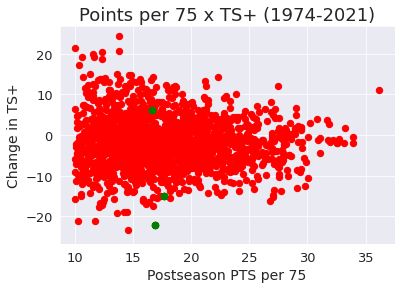

In [ ]:
#@title plot rubric
# figsize=(40, 40)
fig = plt.figure()
ax1 = fig.add_subplot(111)
jrue_ch_changes = pd.read_csv('/content/2_Playoff_Scoring_Prime_Change_300min.csv', encoding='utf8')
jrue_ch_changes = jrue_ch_changes[(jrue_ch_changes['PTS per 75_post'] >= 10)]
jrue_ch_changes = jrue_ch_changes[(jrue_ch_changes['MP_post'] >= 600)]

ax1.scatter(jrue_ch_changes['PTS per 75_post'], jrue_ch_changes['TS+_change'], c='r', marker='o', s=40)
only_jrue = jrue_ch_changes[(jrue_ch_changes['Player'] == 'Jrue Holiday')]

for i in range(len(only_jrue)):
  ax1.scatter(only_jrue['PTS per 75_post'], only_jrue['TS+_change'], c='g', marker='o', s=41)

plt.xlabel('Postseason PTS per 75')
plt.ylabel('Change in TS+')
plt.title('Points per 75 x TS+ (1974-2021)')
#for index, row in jrue_ch_changes.iterrows():
#  if (row['TS+_change'] >= 19):
#   plt.annotate((row['Player'], row['Years']), (row['PTS per 75_post'], row['TS+_change']), fontsize=10)

#for index, row in trimmed_per100_since74_for_minutes_and25points.iterrows():
#  if (row['Player'] == 'LeBron James'):
#    plt.annotate((row['Player'], row['Year']), (row['PTS'], row['TS%+']), fontsize=20)

#fig.savefig("ALL25", dpi=800)
fig.savefig("ALL25", dpi=200)
yabs_max = abs(max(ax1.get_ylim(), key=abs))
ax1.set_ylim(ymin=-yabs_max, ymax=yabs_max)

plt.show()

In [ ]:
#@title Custom years player season database, and grab set years regToPlayoffs functions
# create a DataFrame, player_df, only containing the seasons from 'seasonList' for player contained in 'player' from original DataFrame, red_df
def createDataBase(player, reg_df, seasonList):
  if len(seasonList)== 16:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7]) | (reg_df.Year == seasonList[8]) | (reg_df.Year == seasonList[9]) | (reg_df.Year == seasonList[10]) | (reg_df.Year == seasonList[11]) | (reg_df.Year == seasonList[12]) | (reg_df.Year == seasonList[13]) | (reg_df.Year == seasonList[14]) | (reg_df.Year == seasonList[15])))]
  if len(seasonList)== 15:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7]) | (reg_df.Year == seasonList[8]) | (reg_df.Year == seasonList[9]) | (reg_df.Year == seasonList[10]) | (reg_df.Year == seasonList[11]) | (reg_df.Year == seasonList[12]) | (reg_df.Year == seasonList[13]) | (reg_df.Year == seasonList[14])))]
  if len(seasonList)== 14:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7]) | (reg_df.Year == seasonList[8]) | (reg_df.Year == seasonList[9]) | (reg_df.Year == seasonList[10]) | (reg_df.Year == seasonList[11]) | (reg_df.Year == seasonList[12]) | (reg_df.Year == seasonList[13])))]
  if len(seasonList)== 13:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7]) | (reg_df.Year == seasonList[8]) | (reg_df.Year == seasonList[9]) | (reg_df.Year == seasonList[10]) | (reg_df.Year == seasonList[11]) | (reg_df.Year == seasonList[12])))]
  if len(seasonList)== 12:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7]) | (reg_df.Year == seasonList[8]) | (reg_df.Year == seasonList[9]) | (reg_df.Year == seasonList[10]) | (reg_df.Year == seasonList[11])))]
  if len(seasonList)== 11:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7]) | (reg_df.Year == seasonList[8]) | (reg_df.Year == seasonList[9]) | (reg_df.Year == seasonList[10])))]
  if len(seasonList)== 10:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7]) | (reg_df.Year == seasonList[8]) | (reg_df.Year == seasonList[9])))]
  if len(seasonList) == 9:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7]) | (reg_df.Year == seasonList[8])))]
  if len(seasonList) == 8:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7])))]
  if len(seasonList) == 7:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6])))]
  if len(seasonList) == 6:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5])))]
  if len(seasonList) == 5:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4])))]
  if len(seasonList) == 4:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3])))]
  if len(seasonList) == 3:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2])))]
  if len(seasonList) == 2:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])))]
  if len(seasonList) == 1:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0])))]
  return player_df
def getPrimeSeasons(df):
  new_df = df.copy()
  new_df = new_df.sort_values('TS%+', ascending=False)
  new_df = new_df.reset_index(drop=True)
  if new_df.shape[0] >= 5:
    prime1 = new_df.iat[0, 0]
    prime2 = new_df.iat[1, 0]
    prime3 = new_df.iat[2, 0]
    prime4 = new_df.iat[3, 0]
    prime5 = new_df.iat[4, 0]
    return (prime1, prime2, prime3, prime4, prime5)
  if new_df.shape[0] == 4:
    prime1 = new_df.iat[0, 0]
    prime2 = new_df.iat[1, 0]
    prime3 = new_df.iat[2, 0]
    prime4 = new_df.iat[3, 0]
    return (prime1, prime2, prime3, prime4)
  if new_df.shape[0] == 3:
    prime1 = new_df.iat[0, 0]
    prime2 = new_df.iat[1, 0]
    prime3 = new_df.iat[2, 0]
    return (prime1, prime2, prime3)
  if new_df.shape[0] == 2:
    prime1 = new_df.iat[0, 0]
    prime2 = new_df.iat[1, 0]
    return (prime1, prime2)
  if new_df.shape[0] == 1:
    prime1 = new_df.iat[0, 0]
    return prime1

# output file containing change in scoring rate and efficiency from regular season to playoffs (2, 3, or 5 year stretches of change)
def regToPlayoffsPrimeProduction(reg_df, playoff_db):

  new_df = pd.DataFrame(columns = ['Player', 'Years', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  players_finished = []

  for idx, row in playoff_db.iterrows():
    not_used = 0
    prime_seasons = 0
    season_list = []
    if row['Player'] not in players_finished:
      player_playoff_db = playoff_db[(playoff_db.Player == row["Player"])]
      player_playoff_db = player_playoff_db[(player_playoff_db['MP'] >= 100)]
      if player_playoff_db.shape[0] >= 5:
        (prime1, prime2, prime3, prime4, prime5) = getPrimeSeasons(player_playoff_db)
        prime_seasons = 5 
      elif player_playoff_db.shape[0] == 4:
        (prime1, prime2, prime3, prime4) = getPrimeSeasons(player_playoff_db)
        prime_seasons = 4
      elif player_playoff_db.shape[0] == 3:
        (prime1, prime2, prime3) = getPrimeSeasons(player_playoff_db)
        prime_seasons = 3
      elif player_playoff_db.shape[0] == 2:
        (prime1, prime2) = getPrimeSeasons(player_playoff_db)
        prime_seasons = 2
      elif player_playoff_db.shape[0] == 1:
        prime1 = getPrimeSeasons(player_playoff_db)
        prime_seasons = 1
      else:
        players_finished.append(row['Player'])
        prime1 = 0
        not_used = 1
      if not_used == 0:
        if prime_seasons == 5:
          player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == prime1) | (reg_df.Year == prime2) | (reg_df.Year == prime3) | (reg_df.Year == prime4) | (reg_df.Year == prime5))]
          player_playoff_db = playoff_db[(playoff_db.Player == row["Player"]) & ((playoff_db.Year == prime1) | (playoff_db.Year == prime2) | (playoff_db.Year == prime3) | (playoff_db.Year == prime4) | (playoff_db.Year == prime5))]
          season_list.append(prime1)
          season_list.append(prime2)
          season_list.append(prime3)
          season_list.append(prime4)
          season_list.append(prime5)
          season_list = sorted(season_list)
        if prime_seasons == 4:
          player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == prime1) | (reg_df.Year == prime2) | (reg_df.Year == prime3) | (reg_df.Year == prime4))]
          player_playoff_db = playoff_db[(playoff_db.Player == row["Player"]) & ((playoff_db.Year == prime1) | (playoff_db.Year == prime2) | (playoff_db.Year == prime3) | (playoff_db.Year == prime4))]
          season_list.append(prime1)
          season_list.append(prime2)
          season_list.append(prime3)
          season_list.append(prime4)
          season_list = sorted(season_list)
        if prime_seasons == 3:
          player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == prime1) | (reg_df.Year == prime2) | (reg_df.Year == prime3))]
          player_playoff_db = playoff_db[(playoff_db.Player == row["Player"]) & ((playoff_db.Year == prime1) | (playoff_db.Year == prime2) | (playoff_db.Year == prime3))]
          season_list.append(prime1)
          season_list.append(prime2)
          season_list.append(prime3)
          season_list = sorted(season_list)
        if prime_seasons == 2:
          player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == prime1) | (reg_df.Year == prime2))]
          player_playoff_db = playoff_db[(playoff_db.Player == row["Player"]) & ((playoff_db.Year == prime1) | (playoff_db.Year == prime2))]                                                                 
          season_list.append(prime1)
          season_list.append(prime2)
          season_list = sorted(season_list)
        if prime_seasons == 1:
          player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == prime1))]
          player_playoff_db = playoff_db[(playoff_db.Player == row["Player"]) & ((playoff_db.Year == prime1))]                                                                 
          season_list.append(prime1)
        (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = reg_playoff_comp_output(row["Player"], player_reg_db, player_playoff_db)
        new_df.loc[len(new_df)] = [name, season_list, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
        players_finished.append(row['Player'])
  outfile = f"Playoff_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)
  new_df.to_csv(outfile, index=False)

In [ ]:
#@title multiple players scoring function
def singleSeasonPlayers(names, df):
  if len(names) == 5:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2]) | (df.Player == names[3]) | (df.Player == names[4])]
  if len(names) == 4:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2]) | (df.Player == names[3])]
  if len(names) == 3:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2])]
  if len(names) == 2:
    df = df[(df.Player == names[0]) | (df.Player == names[1])]
  if len(names) == 1:
    df = df[(df.Player == names[0])]

  sorted_pts = df.copy()
  #sorted_pts = sorted_pts.drop(columns=['TeamColor', 'Pos', 'Age', 'G', 'GS', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',  'BLK', 'TOV', 'PF', 'ORtg', 'DRtg'])
  sorted_pts = sorted_pts.rename(columns={"Age": "Age", "Year": "Year", "Player": "Player", "Tm": "Team", "PTS": "PTS per 75", "MP": "MP", "TS%+": "TS+"})

  sorted_pts = sorted_pts.sort_values('PTS per 75', ascending=False)


  columns_titles = ['Player', 'Year', 'Team', 'PTS per 75', 'TS+', 'MP', 'Age']
  sorted_pts = sorted_pts.reindex(columns=columns_titles)
  sorted_pts['PTS per 75'] = sorted_pts['PTS per 75'].astype(float).round(2)
  sorted_pts['TS+'] = sorted_pts['TS+'].astype(float).round(2)
  print(names,"\n")
  print(sorted_pts)
  print("\n")

  outfile = f"One_Year_{names}_NBA_Playoffs.csv"
  sorted_pts.to_csv(outfile, index=False)

def multiSeasonPlayers(names, df, number_seasons):
  if len(names) == 5:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2]) | (df.Player == names[3]) | (df.Player == names[4])]
  if len(names) == 4:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2]) | (df.Player == names[3])]
  if len(names) == 3:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2])]
  if len(names) == 2:
    df = df[(df.Player == names[0]) | (df.Player == names[1])]
  if len(names) == 1:
    df = df[(df.Player == names[0])]

  sorted_pts = df.copy()
  #sorted_pts = sorted_pts.drop(columns=['TeamColor'])
  sorted_pts = sorted_pts.rename(columns={"Years": "Years", "Player": "Player", "Tm": "Team", "PTS": "PTS per 75", "MP": "MP", "TS%+": "TS+"})

  sorted_pts = sorted_pts.sort_values('PTS per 75', ascending=False)


  columns_titles = ['Player', 'Years', 'Team', 'PTS per 75', 'TS+', 'MP']
  sorted_pts = sorted_pts.reindex(columns=columns_titles)
  sorted_pts['PTS per 75'] = sorted_pts['PTS per 75'].astype(float).round(2)
  sorted_pts['TS+'] = sorted_pts['TS+'].astype(float).round(2)
  print(names,"\n")
  print(sorted_pts)
  print("\n")

  outfile = f"{number_seasons}_Year_{names}_NBA_Playoffs.csv"
  sorted_pts.to_csv(outfile, index=False)

In [ ]:
#@title multiple players play-by-play function
def singleSeasonpbpPlayers(names, df):
  if len(names) == 5:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2]) | (df.Player == names[3]) | (df.Player == names[4])]
  if len(names) == 4:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2]) | (df.Player == names[3])]
  if len(names) == 3:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2])]
  if len(names) == 2:
    df = df[(df.Player == names[0]) | (df.Player == names[1])]
  if len(names) == 1:
    df = df[(df.Player == names[0])]

  sorted_pts = df.copy()
  sorted_pts = sorted_pts.drop(columns=['Pos', 'Age', 'G', 'BadPass', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1'])
  sorted_pts = sorted_pts.rename(columns={"Year": "Year", "Tm": "Team", "Player": "Player", "OnCourt": "OnCourt", "MP": "MP", "On-Off": "On-Off"})

  sorted_pts = sorted_pts.sort_values('On-Off', ascending=False)


  columns_titles = ['Player', 'Year', 'Team', 'On-Off', 'OnCourt', 'MP']
  sorted_pts = sorted_pts.reindex(columns=columns_titles)
  sorted_pts['On-Off'] = sorted_pts['On-Off'].astype(float).round(2)
  sorted_pts['OnCourt'] = sorted_pts['OnCourt'].astype(float).round(2)
  print(names,"\n")
  print(sorted_pts)
  print("\n")

  outfile = f"One_Year_pbp_{names}_NBA_Playoffs.csv"
  sorted_pts.to_csv(outfile, index=False)

def multiSeasonpbpPlayers(names, df, number_seasons):
  if len(names) == 5:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2]) | (df.Player == names[3]) | (df.Player == names[4])]
  if len(names) == 4:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2]) | (df.Player == names[3])]
  if len(names) == 3:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2])]
  if len(names) == 2:
    df = df[(df.Player == names[0]) | (df.Player == names[1])]
  if len(names) == 1:
    df = df[(df.Player == names[0])]
    
  sorted_pts = df.copy()
  sorted_pts = sorted_pts.rename(columns={"Years": "Years", "Tm": "Team", "Player": "Player", "OnCourt": "OnCourt", "MP": "MP", "On-Off": "On-Off"})
  
  sorted_pts = sorted_pts.sort_values('On-Off', ascending=False)


  columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP']
  sorted_pts = sorted_pts.reindex(columns=columns_titles)
  sorted_pts['On-Off'] = sorted_pts['On-Off'].astype(float).round(2)
  sorted_pts['OnCourt'] = sorted_pts['OnCourt'].astype(float).round(2)
  print(names,"\n")
  print(sorted_pts)
  print("\n")

  outfile = f"{number_seasons}_Year_pbp_{names}_NBA_Playoffs.csv"
  sorted_pts.to_csv(outfile, index=False)

In [ ]:
#@title simple pretty outputs
#glossary
#
#
#
# import_player_since74_per75_df = all regular season scoring seasons
# import_player_since74playoffs_per75_df = all playoff scoring seasons
# import_player_regular_playbyplay_df = all regular season pbp seasons
# import_player_since74playoffs_playbyplay_df = all playoff pbp seasons
# sorted_2pts = 2 year playoff scoring peaks
# sorted_3pts = 3 year playoff scoring peaks
# sorted_5pts = 5 year playoff scoring peaks
# reg_season_3_peaks = 3 year regular season scoring peaks
# reg_season_3_peaks = 5 year regular season scoring peaks
# sorted_3reg = 3 year regular season pbp peaks
# sorted_5reg = 5 year regular season pbp peaks
# sorted_3playoffs = 3 year playoff pbp peaks
# sorted_5playoffs = 5 year playoff pbp peaks
#
#
# Manu Ginóbili

players_names = ["Manu Ginóbili", "Tony Parker", "Tim Duncan"]

singleSeasonPlayers(players_names, import_player_since74playoffs_per75_df)
#singleSeasonpbpPlayers(players_names, import_player_since74playoffs_playbyplay_df)

In [ ]:
manu_good_company = import_player_since74playoffs_per75_df[(import_player_since74playoffs_per75_df['MP'] >= 400)]
manu_good_company = manu_good_company[(manu_good_company['PTS'] >= 20)]
manu_good_company = manu_good_company[(manu_good_company['TS%+'] >= 120)]

sorted_pts = manu_good_company.copy()
sorted_pts = sorted_pts.drop(columns=['TeamColor', 'Pos', 'G', 'GS', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',  'BLK', 'TOV', 'PF', 'ORtg', 'DRtg'])
sorted_pts = sorted_pts.rename(columns={"Age": "Age", "Year": "Year", "Player": "Player", "Tm": "Team", "PTS": "PTS per 75", "MP": "MP", "TS%+": "TS+"})

sorted_pts = sorted_pts.sort_values('TS+', ascending=False)


columns_titles = ['Player', 'Year', 'Team', 'PTS per 75', 'TS+', 'MP', 'Age']
sorted_pts = sorted_pts.reindex(columns=columns_titles)
sorted_pts['PTS per 75'] = sorted_pts['PTS per 75'].astype(float).round(2)
sorted_pts['TS+'] = sorted_pts['TS+'].astype(float).round(2)
print(sorted_pts)
print("\n")

outfile = f"Manu_Ginobili_Numba_One.csv"
sorted_pts.to_csv(outfile, index=False)

In [ ]:
five_changes = pd.read_csv('/content/8_Playoff_Scoring_Prime_Change_2000min_20points.csv', encoding='utf8')
five_changes = five_changes.loc[(five_changes['PTS_change'] >= .5) &  (five_changes['TS+_change'] >= 1) & (five_changes['TS+_post'] >= 105)]
#five_changes = five_changes.loc[(five_changes['Player'] == 'Karl Malone') | (five_changes['Player'] == 'John Stockton')]
#five_changes = five_changes.loc[(five_changes['Player'] == 'Kyle Lowry')]

#five_changes = five_changes[five_changes['Player'] == 'Chris Paul']

#three_changes = pd.read_csv('/content/3_Playoff_Scoring_Prime_Change_1000min_20points.csv', encoding='utf8')
#three_changes = three_changes.loc[(three_changes['TS+_change'] >= 5) | (three_changes['PTS_change'] >= 3)]

#three_changes = three_changes[three_changes['Player'] == 'Chris Paul']

five_changes['TS+_change'] = five_changes['TS+_change'].round(2)
five_changes['PTS_change'] = five_changes['PTS_change'].round(2)
five_changes['PTS per 75_reg'] = five_changes['PTS per 75_reg'].round(2)
five_changes['PTS per 75_post'] = five_changes['PTS per 75_post'].round(2)
five_changes['TS+_reg'] = five_changes['TS+_reg'].round(2)
five_changes['TS+_post'] = five_changes['TS+_post'].round(2)

#three_changes['TS+_change'] = three_changes['TS+_change'].round(2)
#three_changes['PTS_change'] = three_changes['PTS_change'].round(2)
#three_changes['PTS per 75_reg'] = three_changes['PTS per 75_reg'].round(2)
#three_changes['PTS per 75_post'] = three_changes['PTS per 75_post'].round(2)
#three_changes['TS+_reg'] = three_changes['TS+_reg'].round(2)
#three_changes['TS+_post'] = three_changes['TS+_post'].round(2)

#outfile_three = f"Three_Scoring_Change.csv"
#three_changes.to_csv(outfile_three, index=False)

#outfile_five = f"Five_Scoring_Change.csv"
#five_changes.to_csv(outfile_five, index=False)
#math.isnan(x)

five_changes = five_changes.sort_values('MP_post', ascending=False)

print(five_changes)

In [ ]:
#@title Import 2 year playoff scoring peaks
import_frag_twopeaks_df = pd.read_csv('/content/Two_Year_Fragmented_scoring_Playoff_Peaks.csv', encoding='utf8')

only_30 = import_frag_twopeaks_df[((import_frag_twopeaks_df['TS+'] >= 115) & (import_frag_twopeaks_df['PTS'] >= 28))]
print(only_30)

         Player         Years     Team     PTS         TS+      MP 
46      LeBron James   2009, 2014  TOT  32.429263  118.315514  1343
93      LeBron James   2014, 2018  TOT  31.025964  116.225579  1685
98      Bernard King  1983 - 1984  NYK  30.860514  116.035925   661
109     Kevin Durant   2017, 2019  GSW  30.330000  120.702077   975
115     Kevin Durant   2017, 2021  TOT  30.193541  116.082468  1018
121  Hakeem Olajuwon  1987 - 1988  HOU  30.078675  120.071505   551
126    Kawhi Leonard   2017, 2021  TOT  29.925261  119.136599   861
131     LeBron James   2014, 2017  TOT  29.814864  118.628308  1507
148     LeBron James   2012, 2014  MIA  29.451074  115.632407  1746
177     LeBron James   2014, 2020  TOT  29.100590  117.310800  1525
187    Dirk Nowitzki  2010 - 2011  DAL  29.027975  115.847469  1059
189    Reggie Miller   1993, 2001  IND  28.988991  124.075480   352
202     LeBron James   2010, 2014  TOT  28.899836  118.094653  1223
211     Kevin Durant   2012, 2019  TOT  28.83747

In [ ]:
#@title a lot of guys changes plot

fig = plt.figure(figsize=(30, 30))
ax1 = fig.add_subplot(111)
#ax = plt.subplot() 

title_font = {'size':'40', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'size':'30'}

plt.xlabel('PTS per 75',  **axis_font)
plt.ylabel('TS+',  **axis_font)
plt.title('Regular Season to Postseason Scoring Changes (1974-2021)', **title_font)

# Set the tick labels font
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(30)

new_ch = ch_ch_changes[((ch_ch_changes.Player == "DeMar DeRozan") | (ch_ch_changes.Player == "Karl Malone") | (ch_ch_changes.Player == "Kawhi Leonard"))]
for idx, row in new_ch.iterrows():
  point_1 = [row['PTS per 75_reg'], row['PTS per 75_post']]
  point_2 = [row['TS+_reg'], row['TS+_post']]
  
  # eff and points better
  if (row['PTS per 75_post'] > row['PTS per 75_reg'] and row['TS+_post'] > row['TS+_reg']):
    plt.plot(point_1, point_2, 'go-')
    plt.annotate((row['Player'], row['Years']), (row['PTS per 75_reg'], row['TS+_reg']), fontsize=30)
  # eff better points worse
  if (row['PTS per 75_post'] < row['PTS per 75_reg'] and row['TS+_post'] > row['TS+_reg']):
    plt.plot(point_1, point_2, 'bo-')
    plt.annotate((row['Player'], row['Years']), (row['PTS per 75_reg'], row['TS+_reg']), fontsize=30)
  # eff worse points better
  if (row['PTS per 75_post'] > row['PTS per 75_reg'] and row['TS+_post'] < row['TS+_reg']):
    plt.plot(point_1, point_2, 'yo-')
    plt.annotate((row['Player'], row['Years']), (row['PTS per 75_reg'], row['TS+_reg']), fontsize=30)
  # eff worse points worse
  if (row['PTS per 75_post'] < row['PTS per 75_reg'] and row['TS+_post'] < row['TS+_reg']):
    plt.plot(point_1, point_2, 'ro-')
    plt.annotate((row['Player'], row['Years']), (row['PTS per 75_reg'], row['TS+_reg']), fontsize=30)
plt.show()

In [ ]:
#@title Spurs
fig = plt.figure(figsize=(30, 30))
ax1 = fig.add_subplot(111)

title_font = {'size':'40', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'size':'30'}

plt.xlabel('PTS per 75',  **axis_font)
plt.ylabel('TS+',  **axis_font)
plt.title('Regular Season to Postseason Scoring Changes (1974-2021)', **title_font)

# Set the tick labels font
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(30)

new_ch = ch_ch_changes[((ch_ch_changes.Player == "Tim Duncan") | (ch_ch_changes.Player == "Tony Parker") | (ch_ch_changes.Player == "Manu Ginóbili"))]
for idx, row in new_ch.iterrows():
  point_1 = [row['PTS per 75_reg'], row['PTS per 75_post']]
  point_2 = [row['TS+_reg'], row['TS+_post']]
  
  # eff and points better
  if row['Player'] == "Manu Ginóbili":
    plt.plot(point_1, point_2, 'c*-')
    plt.plot(row['PTS per 75_reg'], row['TS+_reg'], 'cs-', markersize=18)
    #plt.annotate((row['Years'], row['Player']), (row['PTS per 75_reg'], row['TS+_reg']))
  # eff better points worse
  if row['Player'] == "Tony Parker":
    plt.plot(point_1, point_2, 'b*-')
    plt.plot(row['PTS per 75_reg'], row['TS+_reg'], 'bs-', markersize=18)
    #plt.annotate((row['Years'], row['Player']), (row['PTS per 75_reg']+.05, row['TS+_reg']+.1))
  # eff worse points better
  if row['Player'] == "Tim Duncan":
    plt.plot(point_1, point_2, 'm*-')
    plt.plot(row['PTS per 75_reg'], row['TS+_reg'], 'ms-', markersize=18)
    #plt.annotate((row['Years'], row['Player']), (row['PTS per 75_reg'], row['TS+_reg']))
fig.savefig("Spurs", dpi=300)
plt.show()

#, markerfacecolor=(1, 1, 0, 0.5)

In [ ]:
outfile_least20 = f"Playoff_Scoring_Prime_Change_1000min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

In [ ]:
#@title Table for 3 and 5 year 
five_changes = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
five_changes = five_changes.loc[(five_changes['Player'] == "Tony Parker") | (five_changes['Player'] == 'Klay Thompson')]

three_changes = pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
three_changes = three_changes.loc[(three_changes['Player'] == "Tony Parker") | (three_changes['Player'] == 'Klay Thompson')]


five_changes['PTS'] = five_changes['PTS'].round(2)
five_changes['TS+'] = five_changes['TS+'].round(2)

three_changes['PTS'] = three_changes['PTS'].round(2)
three_changes['TS+'] = three_changes['TS+'].round(2)

outfile_three = f"klay3.csv"
three_changes.to_csv(outfile_three, index=False)

outfile_five = f"klay5.csv"
five_changes.to_csv(outfile_five, index=False)

print("3 Year Playoffs")
print(three_changes)
print("5 Year Playoffs")
print(five_changes)

#five_changes = pd.read_csv('/content/Five_Year_scoring_Reg_Peaks.csv', encoding='utf8')
#five_changes = five_changes.loc[(five_changes['Player'] == "Bruce Bowen") | (five_changes['Player'] == 'Danny Green')]

#three_changes = pd.read_csv('/content/Three_Year_scoring_Reg_Peaks.csv', encoding='utf8')
#three_changes = three_changes.loc[(three_changes['Player'] == "Bruce Bowen") | (three_changes['Player'] == 'Danny Green')]


#five_changes['PTS'] = five_changes['PTS'].round(2)
#five_changes['TS+'] = five_changes['TS+'].round(2)


#three_changes['PTS'] = three_changes['PTS'].round(2)
#three_changes['TS+'] = three_changes['TS+'].round(2)

#print("3 Year Regular Season")
#print(three_changes)
#print("5 Year Regular Season")
#print(five_changes)

In [ ]:
#@title Table for 3 and 5 year for pbp
five_changes = pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
five_changes = five_changes.loc[(five_changes['Player'] == "Tony Parker") | (five_changes['Player'] == 'Klay Thompson')]

three_changes = pd.read_csv('/content/Eight_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
three_changes = three_changes.loc[(three_changes['Player'] == "Tony Parker") | (three_changes['Player'] == 'Klay Thompson')]



#two_changes = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
#two_changes = two_changes.loc[(two_changes['Player'] == "Ray Allen") | (two_changes['Player'] == 'Reggie Miller') | (two_changes['Player'] == 'Klay Thompson')]


five_changes['On-Off'] = five_changes['On-Off'].round(2)
five_changes['OnCourt'] = five_changes['OnCourt'].round(2)


#three_changes['On-Off'] = three_changes['On-Off'].round(2)
#three_changes['OnCourt'] = three_changes['OnCourt'].round(2)

#two_changes['PTS'] = two_changes['PTS'].round(2)
#two_changes['TS+'] = two_changes['TS+'].round(2)

#outfile_three = f"klay3pbp.csv"
#three_changes.to_csv(outfile_three, index=False)

#outfile_five = f"klay5pbp.csv"
#five_changes.to_csv(outfile_five, index=False)

#outfile_two = f"klay.csv"
#two_changes.to_csv(outfile_two, index=False)

print("8 Year Playoffs")
print(three_changes)

print("5 Year Playoffs")
print(five_changes)

In [ ]:
#@title Manual Comparisons (playoff change and compare regular season statistics)
#reg_playoff_comp("Kobe Bryant", import_player_since74_per75_df,import_player_since74playoffs_per75_df)

#seasons = [2013, 2014, 2015, 2016, 2017, 2018, 2019]
seasons = np.arange(2009, 2013, 1)

player_name = "James Harden"

playoff_db = createDataBase(player_name, import_player_since74playoffs_per75_df, seasons)
reg_db = createDataBase(player_name, import_player_since74_per75_df, seasons)

reg_playoff_comp(player_name, reg_db, playoff_db)
#reg_playoff_comp(player_name, import_player_since74_per75_df, import_player_since74playoffs_per75_df)






a_seasons = np.arange(2015, 2022, 1)
b_seasons = np.arange(2016, 2017, 1)
c_seasons = np.arange(2011, 2020, 1)
d_seasons = np.arange(2001, 2013, 1)

a = createDataBase("James Harden", import_player_since74playoffs_per75_df, a_seasons)
b = createDataBase("Klay Thompson", import_player_since74playoffs_per75_df, b_seasons)
c = createDataBase("Kevin Durant", import_player_since74playoffs_per75_df, c_seasons)
d = createDataBase("Kobe Bryant", import_player_since74playoffs_per75_df, d_seasons)

a = a.append(b)
a = a.append(c)
a = a.append(d)

comparePlayers("James Harden", "Klay Thompson", a)
comparePlayers("Kevin Durant", "Kobe Bryant", a)

In [ ]:
#@title Manual comparisons
sorted_playoffs_pts = import_player_since74playoffs_per75_df.copy()
sorted_reg_pts = import_player_since74_per75_df.copy()

#player_a = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Damian Lillard") & ((sorted_playoffs_pts.Year == 2014) | (sorted_playoffs_pts.Year == 2015)  | (sorted_playoffs_pts.Year == 2016) | (sorted_playoffs_pts.Year == 2017) | (sorted_playoffs_pts.Year == 2019) | (sorted_playoffs_pts.Year == 2020) | (sorted_playoffs_pts.Year == 2021))]
#player_b = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Kobe Bryant") & ((sorted_playoffs_pts.Year == 2001) | (sorted_playoffs_pts.Year == 2006)  | (sorted_playoffs_pts.Year == 2007) | (sorted_playoffs_pts.Year == 2008) | (sorted_playoffs_pts.Year == 2009) | (sorted_playoffs_pts.Year == 2010) | (sorted_playoffs_pts.Year == 2003) | (sorted_playoffs_pts.Year == 2012))]

player_b = sorted_reg_pts[(sorted_reg_pts.Player == "Damian Lillard") & ((sorted_reg_pts.Year == 2014) | (sorted_reg_pts.Year == 2015)  | (sorted_reg_pts.Year == 2016) | (sorted_reg_pts.Year == 2016) | (sorted_reg_pts.Year == 2017) | (sorted_reg_pts.Year == 2019) | (sorted_reg_pts.Year == 2020) | (sorted_reg_pts.Year == 2021))]

#player_a = sorted_pts[(sorted_pts.Player == "Kawhi Leonard") & ((sorted_pts.Year == 2012) | (sorted_pts.Year == 2014)  | (sorted_pts.Year == 2019) | (sorted_pts.Year == 2016) | (sorted_pts.Year == 2015) | (sorted_pts.Year == 2017) | (sorted_pts.Year == 2020) | (sorted_pts.Year == 2021))]

player_a = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Klay Thompson") & ((sorted_playoffs_pts.Year == 2013) | (sorted_playoffs_pts.Year == 2014)  | (sorted_playoffs_pts.Year == 2015) | (sorted_playoffs_pts.Year == 2016) | (sorted_playoffs_pts.Year == 2017) | (sorted_playoffs_pts.Year == 2018) | (sorted_playoffs_pts.Year == 2019))]
#player_b = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Kobe Bryant")]
#player_a = df[(df.Player == a)]
#player_b = df[(df.Player == b)]
total_mp_a = 0
total_pts_a = 0
total_ts_a = 0

total_mp_b = 0
total_pts_b = 0
total_ts_b = 0
mp_list_a = []
mp_list_b = []

# find total minutes a
for row in player_a['MP']:
  mp_list_a.append(row)
  total_mp_a += row
print(player_a.iat[0, 3], "\nminutes: ", total_mp_a)

# find total PTS a
i = 0
for row in player_a['PTS']:
  total_pts_a += row * (mp_list_a[i] / total_mp_a)
  i = i + 1

# find total TS+ a
i = 0
for row in player_a['TS%+']:
  total_ts_a += row * (mp_list_a[i] / total_mp_a)
  i = i + 1

print("PTS per 75: ", total_pts_a)
print("TS+: ",total_ts_a)

# find total minutes
for row in player_b['MP']:
  mp_list_b.append(row)
  total_mp_b += row
print("\n")
print(player_b.iat[0, 3], "\nminutes: ", total_mp_b)

# find total PTS
i = 0
for row in player_b['PTS']:
  total_pts_b += row * (mp_list_b[i] / total_mp_b)
  i = i + 1

# find total TS+
i = 0
for row in player_b['TS%+']:
  total_ts_b += row * (mp_list_b[i] / total_mp_b)
  i = i + 1

print("PTS per 75: ", total_pts_b)
print("TS+: ",total_ts_b)




Klay Thompson 
minutes:  4570
PTS per 75:  19.32899343544858
TS+:  102.49578465911253


Damian Lillard 
minutes:  18942
PTS per 75:  25.98854133671207
TS+:  107.08896251014711


**PLOTTING**

In [ ]:
fiveyearpbp =  pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
fiveyearpbptext = fiveyearpbp.loc[(fiveyearpbp['OnCourt'] >= 10) | (fiveyearpbp['OnCourt'] <= -6 ) | (fiveyearpbp['On-Off'] >= 18)]
fiveyearpbptext["Player"] = fiveyearpbptext['Player'] + ' ' + fiveyearpbptext['Years']
print(fiveyearpbptext["Player"])

0                        David Robinson 1998 - 2002
1          Baron Davis 2002, 2003, 2004, 2007, 2012
2          Paul George 2011, 2012, 2013, 2014, 2016
3        Kevin Garnett 2004, 2008, 2010, 2011, 2012
4          George Hill 2012, 2013, 2014, 2016, 2017
                           ...                     
952     Jason Williams 2000, 2001, 2004, 2005, 2006
953       Caron Butler 2008, 2010, 2012, 2013, 2014
957       Caron Butler 2006, 2008, 2010, 2012, 2013
959    Carmelo Anthony 2011, 2012, 2013, 2018, 2020
960    Carmelo Anthony 2012, 2013, 2018, 2020, 2021
Name: Player, Length: 65, dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
five_changes = pd.read_csv('/content/5_Playoff_Scoring_Prime_Change_500min.csv', encoding='utf8')

five_changes = five_changes[(five_changes['Player'] == 'Lou Williams')]

five_changes['TS+_change'] = five_changes['TS+_change'].round(2)
five_changes['PTS_change'] = five_changes['PTS_change'].round(2)
five_changes['PTS per 75_reg'] = five_changes['PTS per 75_reg'].round(2)
five_changes['PTS per 75_post'] = five_changes['PTS per 75_post'].round(2)
five_changes['TS+_reg'] = five_changes['TS+_reg'].round(2)
five_changes['TS+_post'] = five_changes['TS+_post'].round(2)


outfile_five = f"Lou.csv"
five_changes.to_csv(outfile_five, index=False)

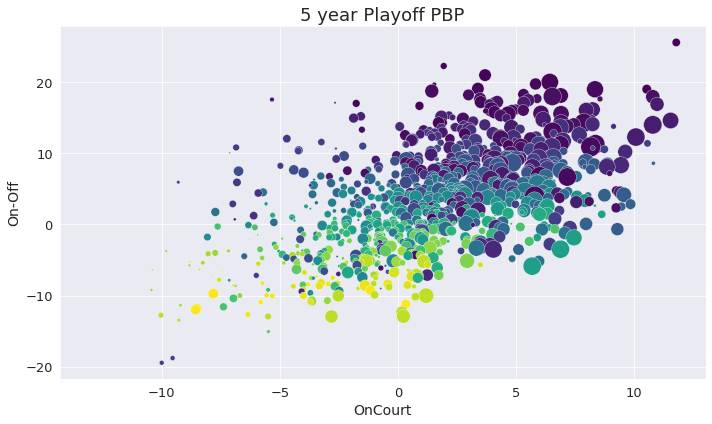

In [ ]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

fiveyearpbp =  pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
fiveyearpbp = fiveyearpbp.dropna()
fiveyearpbp = fiveyearpbp.sort_values('On-Off', ascending=False)
size = 100 * ((fiveyearpbp['MP'] - fiveyearpbp['MP'].min()) / (fiveyearpbp['MP'].max() - fiveyearpbp['MP'].min()))
plt.figure(figsize=(10,6), tight_layout=True)
sns.color_palette("viridis", as_cmap=True)
ax = sns.scatterplot(data=fiveyearpbp, x='OnCourt', y='On-Off', hue='Player', palette='viridis', s=size*4)
ax.set(title='5 year Playoff PBP', xlabel='OnCourt', ylabel='On-Off')
plt.legend([],[], frameon=False)
plt.show()

In [ ]:
#fiveyearpbp =  pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
fiveyearpbp =  pd.read_csv('/content/Three_Year_pbp_Peaks_NBA_Playoffs_300_min.csv', encoding='utf8')

fiveyearpbp = fiveyearpbp.loc[(fiveyearpbp['Player'] =='Tim Duncan') | (fiveyearpbp['Player'] =='Tony Parker') | (fiveyearpbp['Player'] =='Manu Ginóbili')]
size = 100 * ((fiveyearpbp['MP'] - fiveyearpbp['MP'].min()) / (fiveyearpbp['MP'].max() - fiveyearpbp['MP'].min()))


plt.figure(figsize=(10,6), tight_layout=True)
colors = sns.color_palette('pastel')
ax = sns.scatterplot(data=fiveyearpbp, x='OnCourt', y='On-Off', hue='Player', palette='Set2', s=size*4)
ax.set(title='3 year Playoff PBP', xlabel='OnCourt', ylabel='On-Off')

#fiveyearpbptext = fiveyearpbp.loc[(fiveyearpbp['OnCourt'] >= 10) | (fiveyearpbp['OnCourt'] <= -6 ) | (fiveyearpbp['On-Off'] >= 18)]
#ax = sns.scatterplot(data=onlyrob, x='OnCourt', y='On-Off', palette=color, s=60)
#label_point(onlyrob['OnCourt'], onlyrob['On-Off'], onlyrob['Player'], plt.gca())

plt.show()

In [ ]:
fiveyearpbp =  pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
fiveyearpbp = fiveyearpbp.loc[(fiveyearpbp['Player'] =='Tony Parker') | (fiveyearpbp['Player'] =='Manu Ginóbili')]

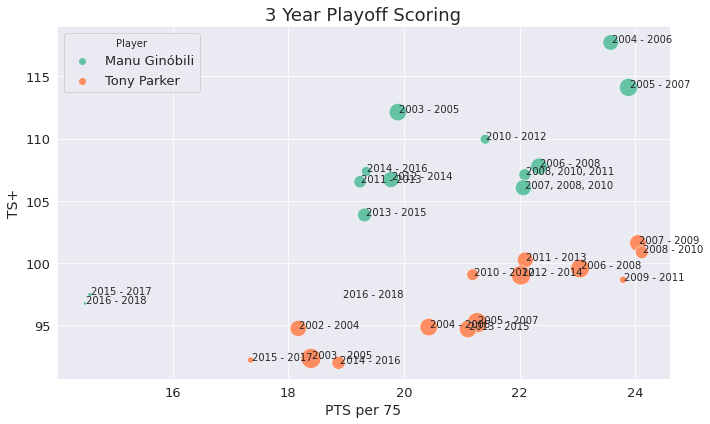

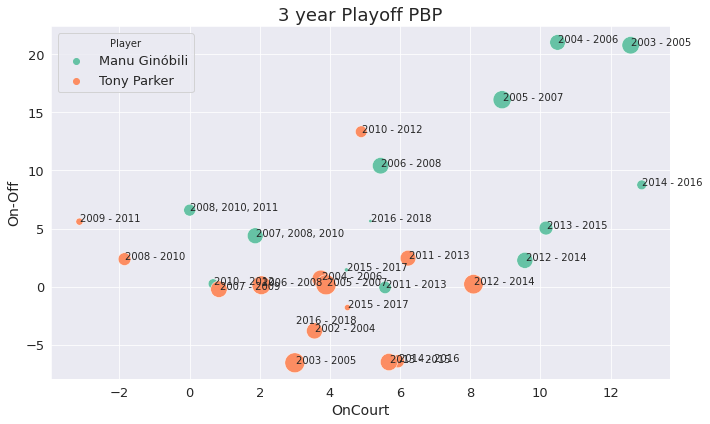

In [ ]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

# Scoring
fiveyearpbp =  pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
fiveyearpbp = fiveyearpbp.loc[(fiveyearpbp['Player'] =='Tony Parker') | (fiveyearpbp['Player'] =='Manu Ginóbili')]
#fiveyearpbp['MPG'] = fiveyearpbp['MP'] / fiveyearpbp['G']
fiveyearpbp = fiveyearpbp.sort_values('TS+', ascending=False)
size = 100 * ((fiveyearpbp['MP'] - fiveyearpbp['MP'].min()) / (fiveyearpbp['MP'].max() - fiveyearpbp['MP'].min()))

plt.figure(figsize=(10,6), tight_layout=True)
colors = sns.color_palette('pastel')
ax = sns.scatterplot(data=fiveyearpbp, x='PTS', y='TS+', hue='Player', palette='Set2', s=size*4)
ax.set(title='3 Year Playoff Scoring', xlabel='PTS per 75', ylabel='TS+')
label_point(fiveyearpbp['PTS'], fiveyearpbp['TS+'], fiveyearpbp['Years'], plt.gca())
plt.show()

# PBP
fiveyearpbp =  pd.read_csv('/content/Three_Year_pbp_Peaks_NBA_Playoffs_300_min.csv', encoding='utf8')
fiveyearpbp = fiveyearpbp.loc[(fiveyearpbp['Player'] =='Tony Parker') | (fiveyearpbp['Player'] =='Manu Ginóbili')]
size = 100 * ((fiveyearpbp['MP'] - fiveyearpbp['MP'].min()) / (fiveyearpbp['MP'].max() - fiveyearpbp['MP'].min()))

plt.figure(figsize=(10,6), tight_layout=True)
colors = sns.color_palette('pastel')
ax = sns.scatterplot(data=fiveyearpbp, x='OnCourt', y='On-Off', hue='Player', palette='Set2', s=size*4)
ax.set(title='3 year Playoff PBP', xlabel='OnCourt', ylabel='On-Off')
label_point(fiveyearpbp['OnCourt'], fiveyearpbp['On-Off'], fiveyearpbp['Years'], plt.gca())

plt.show()

In [ ]:
#@title Klay/Reggie/Ray Plot
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

# Scoring
fiveyearpbp =  pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
fiveyearpbp = fiveyearpbp.loc[(fiveyearpbp['Player'] =='Klay Thompson') | (fiveyearpbp['Player'] =='Reggie Miller') | (fiveyearpbp['Player'] =='Ray Allen')]
fiveyearpbp = fiveyearpbp.sort_values('TS+', ascending=False)
size = 100 * ((fiveyearpbp['MP'] - fiveyearpbp['MP'].min()) / (fiveyearpbp['MP'].max() - fiveyearpbp['MP'].min()))

plt.figure(figsize=(10,6), tight_layout=True)
colors = sns.color_palette('pastel')
ax = sns.scatterplot(data=fiveyearpbp, x='PTS', y='TS+', hue='Player', palette='Set2', s=size*4)
ax.set(title='3 Year Playoff Scoring', xlabel='PTS per 75', ylabel='TS+')
label_point(fiveyearpbp['PTS'], fiveyearpbp['TS+'], fiveyearpbp['Years'], plt.gca())
sns.move_legend(ax, "upper left")
plt.show()

# PBP
fiveyearpbp =  pd.read_csv('/content/Three_Year_pbp_Peaks_NBA_Playoffs_300_min.csv', encoding='utf8')
fiveyearpbp = fiveyearpbp.loc[(fiveyearpbp['Player'] =='Klay Thompson') | (fiveyearpbp['Player'] =='Reggie Miller') | (fiveyearpbp['Player'] =='Ray Allen')]
size = 100 * ((fiveyearpbp['MP'] - fiveyearpbp['MP'].min()) / (fiveyearpbp['MP'].max() - fiveyearpbp['MP'].min()))

plt.figure(figsize=(10,6), tight_layout=True)
colors = sns.color_palette('pastel')
ax = sns.scatterplot(data=fiveyearpbp, x='OnCourt', y='On-Off', hue='Player', palette='Set2', s=size*4)
ax.set(title='3 year Playoff PBP', xlabel='OnCourt', ylabel='On-Off')
label_point(fiveyearpbp['OnCourt'], fiveyearpbp['On-Off'], fiveyearpbp['Years'], plt.gca())
sns.move_legend(ax, "upper left")
plt.show()

In [ ]:
#@title Tim/Kobe plot
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

# Scoring
fiveyearpbp =  pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
fiveyearpbp = fiveyearpbp.loc[(fiveyearpbp['Player'] =='Tim Duncan') | (fiveyearpbp['Player'] =='Kobe Bryant')]
fiveyearpbp = fiveyearpbp.sort_values('TS+', ascending=False)
size = 100 * ((fiveyearpbp['MP'] - fiveyearpbp['MP'].min()) / (fiveyearpbp['MP'].max() - fiveyearpbp['MP'].min()))

plt.figure(figsize=(10,6), tight_layout=True)
colors = sns.color_palette('pastel')
ax = sns.scatterplot(data=fiveyearpbp, x='PTS', y='TS+', hue='Player', palette='Set2', s=size*4)
ax.set(title='3 Year Playoff Scoring', xlabel='PTS per 75', ylabel='TS+')
label_point(fiveyearpbp['PTS'], fiveyearpbp['TS+'], fiveyearpbp['Years'], plt.gca())
sns.move_legend(ax, "upper left")
plt.show()

# PBP
fiveyearpbp =  pd.read_csv('/content/Three_Year_pbp_Peaks_NBA_Playoffs_300_min.csv', encoding='utf8')
fiveyearpbp = fiveyearpbp.loc[(fiveyearpbp['Player'] =='Tim Duncan') | (fiveyearpbp['Player'] =='Kobe Bryant')]
size = 100 * ((fiveyearpbp['MP'] - fiveyearpbp['MP'].min()) / (fiveyearpbp['MP'].max() - fiveyearpbp['MP'].min()))

plt.figure(figsize=(10,6), tight_layout=True)
colors = sns.color_palette('pastel')
ax = sns.scatterplot(data=fiveyearpbp, x='OnCourt', y='On-Off', hue='Player', palette='Set2', s=size*4)
ax.set(title='3 year Playoff PBP', xlabel='OnCourt', ylabel='On-Off')
label_point(fiveyearpbp['OnCourt'], fiveyearpbp['On-Off'], fiveyearpbp['Years'], plt.gca())
sns.move_legend(ax, "upper left")
plt.show()

In [ ]:
#@title Some Manual Test Calculations
sorted_pts = import_player_since74playoffs_per75_df.copy()
sorted_pts = sorted_pts[(sorted_pts['Player'] == 'Kyrie Irving')]

sorted_pts = sorted_pts.sort_values('PTS', ascending=False)
sorted_pts = sorted_pts.drop(columns=['TeamColor'])
sorted_pts = sorted_pts.reset_index(drop=True)

#sorted_pts = sorted_pts.rename(columns={"Years": "Years", "Player": "Player", "Tean": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})
#columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP']
#sorted_pts = sorted_pts.reindex(columns=columns_titles)

print(sorted_pts)
running_two_year_peak_val =  ((sorted_pts.iat[2, 29] * (sorted_pts.iat[2, 8] / (sorted_pts.iat[2, 8] + sorted_pts.iat[4, 8])) )) + ((sorted_pts.iat[4, 29] * (sorted_pts.iat[4, 8] / (sorted_pts.iat[4, 8] + sorted_pts.iat[2, 8]))  ))
print(running_two_year_peak_val)
running_two_year_peak_val =  ((sorted_pts.iat[2, 1] * (sorted_pts.iat[2, 8] / (sorted_pts.iat[2, 8] + sorted_pts.iat[4, 8])) )) + ((sorted_pts.iat[4, 1] * (sorted_pts.iat[4, 8] / (sorted_pts.iat[4, 8] + sorted_pts.iat[2, 8]))  ))
print(running_two_year_peak_val)
print((sorted_pts.iat[2, 8] + sorted_pts.iat[4, 8]))

In [ ]:
#@title 2 year plot data

# no minutes filter
peak2_pts_list = import_pts_twopeaks_df["PeakValue"]
peak2_pts_list = peak2_pts_list.reset_index(drop=True)

peak2_ts_list = import_ts_twopeaks_df["PeakValue"]
peak2_ts_list = peak2_ts_list.reset_index(drop=True)

peak2_colors_list = import_pts_twopeaks_df['TeamColor']
peak2_colors_list = peak2_colors_list.reset_index(drop=True)

# 400 minutes filter
at_least_400_min_pts_2 = import_pts_twopeaks_df[(import_pts_twopeaks_df['MP'] >= 300)]
at_least_400_min_pts_2 = at_least_400_min_pts_2.reset_index(drop=True)

at_least_400_min_ts_2 = import_ts_twopeaks_df[(import_ts_twopeaks_df['MP'] >= 300)]
at_least_400_min_ts_2 = at_least_400_min_ts_2.reset_index(drop=True)

peak2_pts_list = at_least_400_min_pts_2["PeakValue"]
peak2_pts_list = peak2_pts_list.reset_index(drop=True)

peak2_ts_list = at_least_400_min_ts_2["PeakValue"]
peak2_ts_list = peak2_ts_list.reset_index(drop=True)

peak2_colors_list = at_least_400_min_pts_2['TeamColor']
peak2_colors_list = peak2_colors_list.reset_index(drop=True)

In [ ]:
#@title Plot single year playoffs
fig = plt.figure(figsize=(40, 40))
ax1 = fig.add_subplot(111)

for i in range(len(trimmed_per100_since74playoffs_for_minutes_and25points)):
  ax1.scatter(p_points25List[i], p_ts25List[i], c=p_colors25List[i],  marker="o")
plt.xlabel('PTS per 75')
plt.ylabel('TS+')
plt.title('Points per 75 x TS+ (1974-2021 Playoffs)')
for index, row in trimmed_per100_since74playoffs_for_minutes_and25points.iterrows():
  if (row['PTS'] > 30 or row['TS%+'] > 120 or row['TS%+'] < 93.6   or row['Player'] == 'LeBron James' or row['Player'] == 'James Harden' or row['Player'] == 'Kobe Bryant' or['Player'] == 'Dwyane Wade' or row['Player'] == 'Manu Ginóbili' or row['Player'] == 'Tony Parker' or row['Player'] == 'Tim Duncan' or row['Player'] == 'David Robinson' or row['Player'] == 'Kawhi Leonard'):
    plt.annotate((row['Player'], row['Year']), (row['PTS'], row['TS%+']), fontsize=20)

#fig.savefig("ALL25", dpi=800)
fig.savefig("spurs-playoffs", dpi=120)

plt.show()

In [ ]:
#@title Single year regular season plot data
colorsList = trimmed_per100_since74_for_minutes['TeamColor']
colorsList = colorsList.reset_index(drop=True)

# values placed into lists to reset index
pointsList = trimmed_per100_since74_for_minutes['PTS']
pointsList = pointsList.reset_index(drop=True)

# values placed into lists to reset index
tsList = trimmed_per100_since74_for_minutes['TS%+']
tsList = tsList.reset_index(drop=True)

In [ ]:
#@title plot rubric

fig = plt.figure(figsize=(40, 40))
ax1 = fig.add_subplot(111)

for i in range(len(###)):
  #ax1.scatter(###, ###, c=###,  marker="o")
plt.xlabel('PTS per 75')
plt.ylabel('TS+')
plt.title('Points per 75 x TS+ (1974-2021)')
#for index, row in ###():
  if (row['PTS'] > 30 or row['TS%+'] > 114.5 or row['TS%+'] < 96 or row['Player'] == 'Manu Ginóbili' or row['Player'] == 'Tony Parker' or row['Player'] == 'Tim Duncan' or row['Player'] == 'David Robinson' or row['Player'] == 'LeBron James'):
    plt.annotate((row['Player'], row['Year']), (row['PTS'], row['TS%+']), fontsize=20)

for index, row in trimmed_per100_since74_for_minutes_and25points.iterrows():
  if (row['Player'] == 'LeBron James'):
    plt.annotate((row['Player'], row['Year']), (row['PTS'], row['TS%+']), fontsize=20)

#fig.savefig("ALL25", dpi=800)
fig.savefig("ALL25", dpi=300)

plt.show()

In [ ]:
#@title 3 year reg plot data
# no minutes filter

points_filter = import_player_pts_reg3peaks_df[(import_player_pts_reg3peaks_df['PTS'] >= 28)]
peak_pts_list = points_filter["PTS"]
peak_pts_list = peak_pts_list.reset_index(drop=True)

peak_ts_list = points_filter["TS+"]
peak_ts_list = peak_ts_list.reset_index(drop=True)

peak_colors_list = points_filter['TeamColor']
peak_colors_list = peak_colors_list.reset_index(drop=True)

In [ ]:
#@title 3 year playoff plot data
# no minutes filter

points_filter = import_player_pts_playoff3peaks_df[(import_player_pts_playoff3peaks_df['PTS'] >= 28)]
peak_pts_list = points_filter["PTS"]
peak_pts_list = peak_pts_list.reset_index(drop=True)

peak_ts_list = points_filter["TS+"]
peak_ts_list = peak_ts_list.reset_index(drop=True)

peak_colors_list = points_filter['TeamColor']
peak_colors_list = peak_colors_list.reset_index(drop=True)

In [ ]:
#@title plot rubric
fig = plt.figure(figsize=(40, 40))
ax1 = fig.add_subplot(111)

title_font = {'size':'40', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'size':'30'}
ax = plt.subplot() # Defines ax variable by creating an empty plot
# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)

for i in range(len(peak_pts_list)):
    ax1.scatter(peak_pts_list[i], peak_ts_list[i], c=peak_colors_list[i],  marker="o")

for index, row in import_player_pts_playoff3peaks_df.iterrows():
  if (row['PTS'] >= 28):
    plt.annotate((row['Player'], row['Years']), (row['PTS'], row['TS+']), fontsize=16) 

plt.title('\'3-Year\' Regular Season Scoring (1974-21)', **title_font)
plt.xlabel('PTS per 75 possessions',  **axis_font)
plt.ylabel('TS+', **axis_font)

plt.savefig("###", dpi=120)
plt.show()

In [ ]:
#@title Spurs regular season
spurs_dudes = trimmed_per100_since74_for_minutes[(trimmed_per100_since74_for_minutes['Tm'] == 'SAS')]
#spurs_dudes = trimmed_per100_since74_for_minutes[(trimmed_per100_since74_for_minutes['PTS'] >= 15 or trimmed_per100_since74_for_minutes['TS%+'] <= 90 ||  or trimmed_per100_since74_for_minutes['TS%+'] <= 110)]

spurs_dudes = spurs_dudes.loc[((spurs_dudes['PTS'] >= 15) | (spurs_dudes['TS%+'] <= 90)  | (spurs_dudes['TS%+'] <= 110)),:]

spurs_dudes = spurs_dudes.reset_index(drop=True)

spurscolorsList = spurs_dudes['TeamColor']
spurscolorsList = spurscolorsList.reset_index(drop=True)

spurspointsList = spurs_dudes['PTS']
spurspointsList = spurspointsList.reset_index(drop=True)

spurstsList = spurs_dudes['TS%+']
spurstsList = spurstsList.reset_index(drop=True)

print(spurs_dudes)

fig = plt.figure(figsize=(40, 40))
ax1 = fig.add_subplot(111)


for i in range(len(spurs_dudes)):
  ax1.scatter(spurspointsList[i], spurstsList[i], c=spurscolorsList[i],  marker="o")
plt.xlabel('PTS')
plt.ylabel('TS+')
plt.title('Points x TS+ of Spurs (1974-2021)')
for index, row in spurs_dudes.iterrows():
  if (row['PTS'] > 25 or row['TS%+'] > 110 or row['TS%+'] < 90 or (row['TS%+'] < 100 and row['PTS'] > 15)):
    plt.annotate((row['Player'], row['Year']), (row['PTS'], row['TS%+']))

fig.savefig("Spurs", dpi=300)
plt.show()

In [ ]:
#@title little trivia block
more800 = import_player_since74playoffs_per75_df[(import_player_since74playoffs_per75_df['MP'] >=200) & (import_player_since74playoffs_per75_df['TS%+'] <90) & (import_player_since74playoffs_per75_df['PTS'] >=20)]

more800.sort_values('TS%+', ascending=True)

print(more800['Player'], more800['Year'], more800['TS%+'])

In [ ]:
#@title Kobe_Bird 3 Output File

# 400 minutes filter
at_least_400_min_pts = import_player_pts_peaks_df[(import_player_pts_peaks_df['MP'] >= 400)]
at_least_400_min_pts = at_least_400_min_pts[(at_least_400_min_pts.Player == 'Larry Bird') | (at_least_400_min_pts.Player == 'Kobe Bryant')]
at_least_400_min_pts = at_least_400_min_pts.reset_index(drop=True)

at_least_400_min_ts = import_player_ts_peaks_df[(import_player_ts_peaks_df['MP'] >= 400)]
at_least_400_min_ts = at_least_400_min_ts[(at_least_400_min_ts.Player == 'Larry Bird') | (at_least_400_min_ts.Player == 'Kobe Bryant')]
at_least_400_min_ts = at_least_400_min_ts.reset_index(drop=True)


sorted_pts = at_least_400_min_pts.copy()
sorted_pts.insert(6, "TS+", at_least_400_min_ts['PeakValue'])
sorted_pts = sorted_pts.rename(columns={"Years": "Years", "Player": "Player", "Tean": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})

sorted_pts = sorted_pts.sort_values('PTS', ascending=False)
sorted_pts = sorted_pts.drop(columns=['TeamColor'])
sorted_pts = sorted_pts.drop(columns=['Team'])

columns_titles = ['Player', 'Years', 'PTS', 'TS+', 'MP']
sorted_pts = sorted_pts.reindex(columns=columns_titles)
sorted_pts['PTS'] = sorted_pts['PTS'].astype(float).round(2)
sorted_pts['TS+'] = sorted_pts['TS+'].astype(float).round(2)
print(sorted_pts)

sorted_pts.to_csv("NBA_Playoff_Scoring_Peaks.csv", index=False)

In [ ]:
#@title Kobe_Bird 2 Output File
import_pts_twopeaks_df = import_pts_twopeaks_df[(import_pts_twopeaks_df.Player == 'Larry Bird') | (import_pts_twopeaks_df.Player == 'Kobe Bryant')]
import_ts_twopeaks_df = import_ts_twopeaks_df[(import_ts_twopeaks_df.Player == 'Larry Bird') | (import_ts_twopeaks_df.Player == 'Kobe Bryant')]
sorted_pts = import_pts_twopeaks_df.copy()
sorted_pts = sorted_pts[(sorted_pts.MP >= 400)]
sorted_pts.insert(6, "TS+", import_ts_twopeaks_df['PeakValue'])
sorted_pts = sorted_pts.rename(columns={"Years": "Years", "Player": "Player", "Tean": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})

sorted_pts = sorted_pts.sort_values('PTS', ascending=False)
sorted_pts = sorted_pts.drop(columns=['TeamColor'])
sorted_pts = sorted_pts.drop(columns=['Team'])

columns_titles = ['Player', 'Years', 'PTS', 'TS+', 'MP']
sorted_pts = sorted_pts.reindex(columns=columns_titles)


sorted_pts['PTS'] = sorted_pts['PTS'].astype(float).round(2)
sorted_pts['TS+'] = sorted_pts['TS+'].astype(float).round(2)
print(sorted_pts)

sorted_pts.to_csv("Two_Year_KobeBird_NBA_Playoffs.csv", index=False)

In [ ]:
#@title Kobe_Bird 5 Output File
import_player_pts_5peaks_df = import_player_pts_5peaks_df[(import_player_pts_5peaks_df.Player == 'Larry Bird') | (import_player_pts_5peaks_df.Player == 'Kobe Bryant')]
import_player_ts_5peaks_df = import_player_ts_5peaks_df[(import_player_ts_5peaks_df.Player == 'Larry Bird') | (import_player_ts_5peaks_df.Player == 'Kobe Bryant')]
sorted_pts = import_player_pts_5peaks_df.copy()
sorted_pts = sorted_pts[(sorted_pts.MP >= 400)]
sorted_pts.insert(6, "TS+", import_player_ts_5peaks_df['PeakValue'])
sorted_pts = sorted_pts.rename(columns={"Years": "Years", "Player": "Player", "Tean": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})

sorted_pts = sorted_pts.sort_values('PTS', ascending=False)
sorted_pts = sorted_pts.drop(columns=['TeamColor'])
sorted_pts = sorted_pts.drop(columns=['Team'])

columns_titles = ['Player', 'Years', 'PTS', 'TS+', 'MP']
sorted_pts = sorted_pts.reindex(columns=columns_titles)


sorted_pts['PTS'] = sorted_pts['PTS'].astype(float).round(2)
sorted_pts['TS+'] = sorted_pts['TS+'].astype(float).round(2)
print(sorted_pts)

sorted_pts.to_csv("Five_Year_KobeBird_NBA_Playoffs.csv", index=False)

In [ ]:
klay = import_player_since74playoffs_per75_df[((import_player_since74playoffs_per75_df.Player == 'Damian Lillard') | (import_player_since74playoffs_per75_df.Player == 'Giannis Antetokounmpo'))]
print(klay)

**EASY PLOTTING FUNCTION**

In [ ]:
#@title Easy Plotting Functions
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

def hist_pmf(data, xlabel='xlabel', ylabel='ylabel', title='PMF'):
  counts = plt.hist(data);
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()
  pmf_sub(counts, xlabel,'Probability Distribution', title)
  
def pmf_sub(data, xlabel='xlabel', ylabel='ylabel', title='PMF'):
  bin_center = (data[1][1:]+data[1][:-1])/2
  plt.bar(bin_center, data[0]/sum(data[0]), width=1.5)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

def scatterPlot(data1, data2, suppressShow, xlabel='Data', ylabel='Data', title='Correl Scatter plot'):
    plt.scatter(data1, data2, c="orange")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if suppressShow == 0:
      plt.show()

def colorScatterPlot(data1, data2, suppressShow, xlabel='Data', ylabel='Data', color="c", label= "legendlabel", title='Correl Scatter plot'):
    plt.scatter(data1, data2, c=color, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if suppressShow == 0:
      plt.show()

def correlScatterPlot(data1, data2, xlabel='Data', ylabel='Data', title='Correl Scatter plot'):
    plt.scatter(np.sort(data1), np.sort(data2), c="orange")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def correlScatterPlotAge(data1, data2, xlabel='Data', ylabel='Data', title='Correl Scatter plot'):
    plt.scatter(np.sort(data1), np.sort(data2), c="orange")
    plt.xlim(18, 44)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [ ]:
#@title plot rubric

fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.xlabel('Year')
plt.ylabel('Being Good at Basketball')
plt.title('Basketball')
plt.xticks([])
plt.yticks([])

rob_x = [1998, 1999, 2000, 2001, 2002, 2003]
rob_y = [6.4, 6.0, 5.4, 5, 3.3, 2.07]

dunc_x = [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
dunc_y = [5.4, 5.8, 6.3, 6.8, 7.7, 7.9, 7.2, 7.0, 6.0, 6.6, 5.2, 4.6, 4.3, 3.9, 4.3, 4.5, 3.9, 3.7, 1.9]

tony_x = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
tony_y = [-0.5, 0.6, 1.2, 1.9, 2.4, 2.7, 2.9, 3.3, 2.4, 3.3, 3.9, 4.6, 3.7, 1.8, .9, -1, -1.6]

manu_x = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
manu_y = [1, 2.9, 5.3, 4.7, 5.2, 5.4, 4.0, 4.4, 5.0, 4.0, 2.6, 4.1, 2.1, 1.8, 1.4, 1.0]

ax1.plot(rob_x, rob_y, c='grey', label="Admiral")
ax1.plot(dunc_x, dunc_y, c='k', label="Fundamental")
ax1.plot(tony_x, tony_y, c='b', label="France")
ax1.plot(manu_x, manu_y, c='c', label="Argentina")
ax1.axvline(x = 1999, color = 'y')
ax1.axvline(x = 2003, color = 'y')
ax1.axvline(x = 2005, color = 'y')
ax1.axvline(x = 2007, color = 'y')

for i in range(0, 12):
  print(dunc_y[i+5] + tony_y[i+1] + manu_y[i])


plt.legend()
fig.savefig("ALL25", dpi=100)

**REGULAR SEASON WORK IN PROGRESS**

In [ ]:
part_1_years = import_player_since74_per75_df[(import_player_since74_per75_df.Year <= 1990)]
part_2_years = import_player_since74_per75_df[(import_player_since74_per75_df.Year >= 1985) & (import_player_since74_per75_df.Year <= 2000)]
part_3_years = import_player_since74_per75_df[(import_player_since74_per75_df.Year >= 1995) & (import_player_since74_per75_df.Year <= 2010)]
part_4_years = import_player_since74_per75_df[(import_player_since74_per75_df.Year >= 2005)]

In [ ]:
#@title regular season scoring peaks run function
threeyearpeak(import_player_since74_per75_df, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

threeyearpeak(import_player_since74_per75_df, 'TS%+')
import_player_longTS_peaks_df = pd.read_csv('three_year_peak_TS%+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_TS%+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

**IMPORT OUTPUTTED DATA (operations previously performed upon)**

In [ ]:
#@title Import 2 year playoff scoring peaks
import_pts_twopeaks_df = pd.read_csv('two_year_peak_PTS_data.csv', encoding='utf8')
import_pts_twopeaks_df = import_pts_twopeaks_df.assign(TeamColor=0)

import_ts_twopeaks_df = pd.read_csv('two_year_peak_TS%+_data.csv', encoding='utf8')
import_ts_twopeaks_df = import_ts_twopeaks_df.assign(TeamColor=0)

# add team color for plotting
import_pts_twopeaks_df['TeamColor'] = import_pts_twopeaks_df['Team'].map(team_colors)
import_ts_twopeaks_df['TeamColor'] = import_ts_twopeaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 3 year playoff scoring peaks
import_player_pts_peaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
import_player_pts_peaks_df = import_player_pts_peaks_df.assign(TeamColor=0)

import_player_ts_peaks_df = pd.read_csv('three_year_peak_TS%+_data.csv', encoding='utf8')
import_player_ts_peaks_df = import_player_ts_peaks_df.assign(TeamColor=0)




# add team color for plotting
import_player_pts_peaks_df['TeamColor'] = import_player_pts_peaks_df['Team'].map(team_colors)
import_player_ts_peaks_df['TeamColor'] = import_player_ts_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 5 year playoff scoring peaks
import_player_pts_5peaks_df = pd.read_csv('five_year_peak_PTS_data.csv', encoding='utf8')
import_player_pts_5peaks_df = import_player_pts_5peaks_df.assign(TeamColor=0)

import_player_ts_5peaks_df = pd.read_csv('five_year_peak_TS%+_data.csv', encoding='utf8')
import_player_ts_5peaks_df = import_player_ts_5peaks_df.assign(TeamColor=0)




# add team color for plotting
import_player_pts_5peaks_df['TeamColor'] = import_player_pts_5peaks_df['Team'].map(team_colors)
import_player_ts_5peaks_df['TeamColor'] = import_player_ts_5peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 8 year playoff scoring peaks
import_player_pts_8peaks_df = pd.read_csv('eight_year_peak_PTS_data.csv', encoding='utf8')
import_player_pts_8peaks_df = import_player_pts_8peaks_df.assign(TeamColor=0)

import_player_ts_8peaks_df = pd.read_csv('eight_year_peak_TS%+_data.csv', encoding='utf8')
import_player_ts_8peaks_df = import_player_ts_8peaks_df.assign(TeamColor=0)




# add team color for plotting
import_player_pts_8peaks_df['TeamColor'] = import_player_pts_8peaks_df['Team'].map(team_colors)
import_player_ts_8peaks_df['TeamColor'] = import_player_ts_8peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 10 year playoff scoring peaks
import_player_pts_10peaks_df = pd.read_csv('ten_year_peak_PTS_data.csv', encoding='utf8')
import_player_pts_10peaks_df = import_player_pts_10peaks_df.assign(TeamColor=0)

import_player_ts_10peaks_df = pd.read_csv('ten_year_peak_TS%+_data.csv', encoding='utf8')
import_player_ts_10peaks_df = import_player_ts_10peaks_df.assign(TeamColor=0)




# add team color for plotting
import_player_pts_10peaks_df['TeamColor'] = import_player_pts_10peaks_df['Team'].map(team_colors)
import_player_ts_10peaks_df['TeamColor'] = import_player_ts_10peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 3 year regular season on-off peaks (don't have)
import_player_3year_OnOff_reg_peaks_df = pd.read_csv('three_year_peak_reg_On-Off_data.csv', encoding='utf8')
import_player_3year_OnOff_reg_peaks_df = import_player_3year_OnOff_reg_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_3year_OnOff_reg_peaks_df['TeamColor'] = import_player_3year_OnOff_reg_peaks_df['Team'].map(team_colors)

print(import_player_3year_OnOff_reg_peaks_df)

In [ ]:
#@title Import 3 year regular season oncourt peaks (don't have)
import_player_3year_OnCourt_reg_peaks_df = pd.read_csv('three_year_peak_regular_OnCourt_data.csv', encoding='utf8')
import_player_3year_OnCourt_reg_peaks_df = import_player_3year_OnCourt_reg_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_3year_OnCourt_reg_peaks_df['TeamColor'] = import_player_3year_OnCourt_reg_peaks_df['Team'].map(team_colors)

print(import_player_3year_OnCourt_reg_peaks_df)

In [ ]:
#@title Import 5 year regular season on-off peaks
import_player_5year_OnOff_reg_peaks_df = pd.read_csv('five_year_peak_reg_On-Off_data.csv', encoding='utf8')
import_player_5year_OnOff_reg_peaks_df = import_player_5year_OnOff_reg_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_5year_OnOff_reg_peaks_df['TeamColor'] = import_player_5year_OnOff_reg_peaks_df['Team'].map(team_colors)

print(import_player_5year_OnOff_reg_peaks_df)

In [ ]:
#@title Import 5 year regular season oncourt peaks
import_player_5year_OnCourt_reg_peaks_df = pd.read_csv('five_year_peak_reg_OnCourt_data.csv', encoding='utf8')
import_player_5year_OnCourt_reg_peaks_df = import_player_5year_OnCourt_reg_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_5year_OnCourt_reg_peaks_df['TeamColor'] = import_player_5year_OnCourt_reg_peaks_df['Team'].map(team_colors)

print(import_player_5year_OnCourt_reg_peaks_df)

In [ ]:
#@title Import 3 year playoff on-off peaks
import_player_3year_OnOff_peaks_df = pd.read_csv('three_year_peak_On-Off_data.csv', encoding='utf8')
import_player_3year_OnOff_peaks_df = import_player_3year_OnOff_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_3year_OnOff_peaks_df['TeamColor'] = import_player_3year_OnOff_peaks_df['Team'].map(team_colors)

print(import_player_3year_OnOff_peaks_df)

In [ ]:
#@title Import 3 year playoff oncourt peaks
import_player_3year_OnCourt_peaks_df = pd.read_csv('three_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_3year_OnCourt_peaks_df = import_player_3year_OnCourt_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_3year_OnCourt_peaks_df['TeamColor'] = import_player_3year_OnCourt_peaks_df['Team'].map(team_colors)

print(import_player_3year_OnCourt_peaks_df)

In [ ]:
#@title Import 5 year playoff on-off peaks
import_player_5year_OnOff_peaks_df = pd.read_csv('five_year_peak_On-Off_data.csv', encoding='utf8')
import_player_5year_OnOff_peaks_df = import_player_5year_OnOff_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_5year_OnOff_peaks_df['TeamColor'] = import_player_5year_OnOff_peaks_df['Team'].map(team_colors)

print(import_player_5year_OnOff_peaks_df)

In [ ]:
#@title Import 5 year playoff oncourt peaks
import_player_5year_OnCourt_peaks_df = pd.read_csv('five_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_5year_OnCourt_peaks_df = import_player_5year_OnCourt_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_5year_OnCourt_peaks_df['TeamColor'] = import_player_5year_OnCourt_peaks_df['Team'].map(team_colors)

print(import_player_5year_OnCourt_peaks_df)

In [ ]:
#@title Import 8 year playoff on-off peaks
import_player_8year_OnOff_peaks_df = pd.read_csv('eight_year_peak_On-Off_data.csv', encoding='utf8')
import_player_8year_OnOff_peaks_df = import_player_8year_OnOff_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_8year_OnOff_peaks_df['TeamColor'] = import_player_8year_OnOff_peaks_df['Team'].map(team_colors)

print(import_player_8year_OnOff_peaks_df)

In [ ]:
#@title Import 8 year playoff oncourt peaks
import_player_8year_OnCourt_peaks_df = pd.read_csv('eight_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_8year_OnCourt_peaks_df = import_player_8year_OnCourt_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_8year_OnCourt_peaks_df['TeamColor'] = import_player_8year_OnCourt_peaks_df['Team'].map(team_colors)

print(import_player_8year_OnCourt_peaks_df)

In [ ]:
#@title Import 10 year playoff on-off peaks
import_player_10year_OnOff_peaks_df = pd.read_csv('ten_year_peak_On-Off_data.csv', encoding='utf8')
import_player_10year_OnOff_peaks_df = import_player_10year_OnOff_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_10year_OnOff_peaks_df['TeamColor'] = import_player_10year_OnOff_peaks_df['Team'].map(team_colors)

print(import_player_10year_OnOff_peaks_df)

In [ ]:
#@title Import 10 year playoff oncourt peaks
import_player_10year_OnCourt_peaks_df = pd.read_csv('ten_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_10year_OnCourt_peaks_df = import_player_10year_OnCourt_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_10year_OnCourt_peaks_df['TeamColor'] = import_player_10year_OnCourt_peaks_df['Team'].map(team_colors)

print(import_player_10year_OnCourt_peaks_df)

In [ ]:
#@title Import 3 year playoff PGA and And1 peaks
import_player_3year_And1_peaks_df = pd.read_csv('three_year_peak_And1_data.csv', encoding='utf8')
import_player_3year_And1_peaks_df = import_player_3year_And1_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_3year_And1_peaks_df['TeamColor'] = import_player_3year_And1_peaks_df['Team'].map(team_colors)



import_player_3year_PGA_peaks_df = pd.read_csv('three_year_peak_PGA_data.csv', encoding='utf8')
import_player_3year_PGA_peaks_df = import_player_3year_PGA_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_3year_PGA_peaks_df['TeamColor'] = import_player_3year_PGA_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 3 year regular season PGA and And1 peaks
import_player_3year_reg_And1_peaks_df = pd.read_csv('three_year_peak_reg_And1_data.csv', encoding='utf8')
import_player_3year_reg_And1_peaks_df = import_player_3year_reg_And1_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_3year_reg_And1_peaks_df['TeamColor'] = import_player_3year_reg_And1_peaks_df['Team'].map(team_colors)



import_player_3year_reg_PGA_peaks_df = pd.read_csv('three_year_peak_reg_PGA_data.csv', encoding='utf8')
import_player_3year_reg_PGA_peaks_df = import_player_3year_reg_PGA_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_3year_reg_PGA_peaks_df['TeamColor'] = import_player_3year_reg_PGA_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 5 year playoff PGA and And1 peaks
import_player_5year_And1_peaks_df = pd.read_csv('five_year_peak_And1_data.csv', encoding='utf8')
import_player_5year_And1_peaks_df = import_player_5year_And1_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_5year_And1_peaks_df['TeamColor'] = import_player_5year_And1_peaks_df['Team'].map(team_colors)



import_player_5year_PGA_peaks_df = pd.read_csv('five_year_peak_PGA_data.csv', encoding='utf8')
import_player_5year_PGA_peaks_df = import_player_5year_PGA_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_5year_PGA_peaks_df['TeamColor'] = import_player_5year_PGA_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 5 year regular season PGA and And1 peaks
import_player_5year_And1_peaks_df = pd.read_csv('five_year_peak_reg_And1_data.csv', encoding='utf8')
import_player_5year_And1_peaks_df = import_player_5year_And1_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_5year_And1_peaks_df['TeamColor'] = import_player_5year_And1_peaks_df['Team'].map(team_colors)



import_player_5year_PGA_peaks_df = pd.read_csv('five_year_peak_reg_PGA_data.csv', encoding='utf8')
import_player_5year_PGA_peaks_df = import_player_5year_PGA_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_5year_PGA_peaks_df['TeamColor'] = import_player_5year_PGA_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 3 and 5 year scoring peaks (pre-assembled)
import_player_pts_reg3peaks_df = pd.read_csv('Three_Year_scoring_Reg_Peaks.csv', encoding='utf8')
import_player_pts_reg3peaks_df = import_player_pts_reg3peaks_df.assign(TeamColor=0)
import_player_pts_reg3peaks_df['TeamColor'] = import_player_pts_reg3peaks_df['Team'].map(team_colors)


import_player_pts_reg5peaks_df = pd.read_csv('Five_Year_scoring_Reg_Peaks.csv', encoding='utf8')
import_player_pts_reg5peaks_df = import_player_pts_reg5peaks_df.assign(TeamColor=0)
import_player_pts_reg5peaks_df['TeamColor'] = import_player_pts_reg5peaks_df['Team'].map(team_colors)


import_player_pts_playoff3peaks_df = pd.read_csv('Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
import_player_pts_playoff3peaks_df = import_player_pts_playoff3peaks_df.assign(TeamColor=0)
import_player_pts_playoff3peaks_df['TeamColor'] = import_player_pts_playoff3peaks_df['Team'].map(team_colors)


import_player_pts_playoff5peaks_df = pd.read_csv('Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
import_player_pts_playoff5peaks_df = import_player_pts_playoff5peaks_df.assign(TeamColor=0)
import_player_pts_playoff5peaks_df['TeamColor'] = import_player_pts_playoff5peaks_df['Team'].map(team_colors)

**RUN PEAK FUNCTIONS**

In [ ]:
#@title 2 year playoff scoring peaks run function
twoyearpeak(import_player_since74playoffs_per75_df, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('two_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
twoyearpeak(import_player_since74playoffs_per75_df, 'TS%+')
import_player_longTS_peaks_df = pd.read_csv('two_year_peak_TS%+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_TS%+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 3 year playoff scoring peaks run function
threeyearpeak(import_player_since74playoffs_per75_df, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

threeyearpeak(import_player_since74playoffs_per75_df, 'TS%+')
import_player_longTS_peaks_df = pd.read_csv('three_year_peak_TS%+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_TS%+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 5 year playoff scoring peaks run function
fiveyearpeak(import_player_since74playoffs_per75_df, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('five_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

fiveyearpeak(import_player_since74playoffs_per75_df, 'TS%+')
import_player_longTS_peaks_df = pd.read_csv('five_year_peak_TS%+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_TS%+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 8 year playoff scoring peaks run function
eightyearpeak(import_player_since74playoffs_per75_df, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('eight_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"eight_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

eightyearpeak(import_player_since74playoffs_per75_df, 'TS%+')
import_player_longTS_peaks_df = pd.read_csv('eight_year_peak_TS%+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"eight_year_peak_TS%+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 10 year playoff scoring peaks run function
tenyearpeak(import_player_since74playoffs_per75_df, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('ten_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"ten_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

tenyearpeak(import_player_since74playoffs_per75_df, 'TS%+')
import_player_longTS_peaks_df = pd.read_csv('ten_year_peak_TS%+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"ten_year_peak_TS%+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 3 year playoff on-off peaks run function
threeyearpeak(import_player_since74playoffs_playbyplay_df, 'On-Off')
import_player_OnOff_peaks_df = pd.read_csv('three_year_peak_On-Off_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_On-Off_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 3 year playoff oncourt peaks run function
threeyearpeak(import_player_since74playoffs_playbyplay_df, 'OnCourt')
import_player_OnCourt_peaks_df = pd.read_csv('three_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnCourt_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_OnCourt_data.csv"
import_player_OnCourt_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 5 year playoff on-off peaks run function
fiveyearpeak(import_player_since74playoffs_playbyplay_df, 'On-Off')
import_player_OnOff_peaks_df = pd.read_csv('five_year_peak_On-Off_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_On-Off_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 5 year playoff oncourt peaks run function
fiveyearpeak(import_player_since74playoffs_playbyplay_df, 'OnCourt')
import_player_OnOff_peaks_df = pd.read_csv('five_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_OnCourt_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 8 year playoff on-off peaks run function
eightyearpeak(import_player_since74playoffs_playbyplay_df, 'On-Off')
import_player_OnOff_peaks_df = pd.read_csv('eight_year_peak_On-Off_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"eight_year_peak_On-Off_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 8 year playoff oncourt peaks run function
eightyearpeak(import_player_since74playoffs_playbyplay_df, 'OnCourt')
import_player_OnOff_peaks_df = pd.read_csv('eight_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"eight_year_peak_OnCourt_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 10 year playoff on-off peaks run function
tenyearpeak(import_player_since74playoffs_playbyplay_df, 'On-Off')
import_player_OnOff_peaks_df = pd.read_csv('ten_year_peak_On-Off_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"ten_year_peak_On-Off_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 10 year playoff oncourt peaks run function
tenyearpeak(import_player_since74playoffs_playbyplay_df, 'OnCourt')
import_player_OnOff_peaks_df = pd.read_csv('ten_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"ten_year_peak_OnCourt_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 2 year regular season on-off peaks run function
twoyearpeak(import_player_regular_playbyplay_df, 'On-Off')
import_player_OnOff_peaks_df = pd.read_csv('two_year_peak_On-Off_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_On-Off_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 2 year regular season oncourt peaks run function
twoyearpeak(import_player_regular_playbyplay_df, 'OnCourt')
import_player_OnCourt_peaks_df = pd.read_csv('two_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnCourt_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_OnCourt_data.csv"
import_player_OnCourt_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 3 year regular season oncourt peaks run function
threeyearpeak(import_player_regular_playbyplay_df, 'OnCourt')
import_player_OnCourt_peaks_df = pd.read_csv('three_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnCourt_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_OnCourt_data.csv"
import_player_OnCourt_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 5 year regular season on-off peaks run function
fiveyearpeak(import_player_regular_playbyplay_df, 'On-Off')
import_player_OnOff_peaks_df = pd.read_csv('five_year_peak_On-Off_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_On-Off_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 5 year regular season oncourt peaks run function
fiveyearpeak(import_player_regular_playbyplay_df, 'OnCourt')
import_player_OnCourt_peaks_df = pd.read_csv('five_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnCourt_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_OnCourt_data.csv"
import_player_OnCourt_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 3 year playoffs PGA & AND1 peaks run function
threeyearpeak(import_player_since74playoffs_playbyplay_df, 'PGA')
import_player_PGA_peaks_df = pd.read_csv('three_year_peak_PGA_data.csv', encoding='utf8')
import_player_PGA_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_PGA_data.csv"
import_player_PGA_peaks_df.to_csv(outfile, index=False)

threeyearpeak(import_player_since74playoffs_playbyplay_df, 'And1')
import_player_And1_peaks_df = pd.read_csv('three_year_peak_And1_data.csv', encoding='utf8')
import_player_And1_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_And1_data.csv"
import_player_And1_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 5 year playoff PGA & AND1 peaks run function
fiveyearpeak(import_player_since74playoffs_playbyplay_df, 'PGA')
import_player_PGA_peaks_df = pd.read_csv('five_year_peak_PGA_data.csv', encoding='utf8')
import_player_PGA_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_PGA_data.csv"
import_player_PGA_peaks_df.to_csv(outfile, index=False)

fiveyearpeak(import_player_since74playoffs_playbyplay_df, 'And1')
import_player_And1_peaks_df = pd.read_csv('five_year_peak_And1_data.csv', encoding='utf8')
import_player_And1_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_And1_data.csv"
import_player_And1_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 3 year regular season PGA & AND1 peaks run function
threeyearpeak(import_player_regular_playbyplay_df, 'PGA')
import_player_PGA_peaks_df = pd.read_csv('three_year_peak_PGA_data.csv', encoding='utf8')
import_player_PGA_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_PGA_data.csv"
import_player_PGA_peaks_df.to_csv(outfile, index=False)

threeyearpeak(import_player_regular_playbyplay_df, 'And1')
import_player_And1_peaks_df = pd.read_csv('three_year_peak_And1_data.csv', encoding='utf8')
import_player_And1_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_And1_data.csv"
import_player_And1_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 5 year regular season PGA & AND1 peaks run function
fiveyearpeak(import_player_regular_playbyplay_df, 'PGA')
import_player_PGA_peaks_df = pd.read_csv('five_year_peak_PGA_data.csv', encoding='utf8')
import_player_PGA_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_PGA_data.csv"
import_player_PGA_peaks_df.to_csv(outfile, index=False)

fiveyearpeak(import_player_regular_playbyplay_df, 'And1')
import_player_And1_peaks_df = pd.read_csv('five_year_peak_And1_data.csv', encoding='utf8')
import_player_And1_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_And1_data.csv"
import_player_And1_peaks_df.to_csv(outfile, index=False)

**OUTPUT PEAK FILES**

In [ ]:
#@title 5 year regular season scoring peaks Output Process
import_player_pts_1regpeaks_df = pd.read_csv('five_year_74to90_PTS_data.csv', encoding='utf8')
import_player_pts_1regpeaks_df = import_player_pts_1regpeaks_df.assign(TeamColor=0)

import_player_ts_1regpeaks_df = pd.read_csv('five_year_74to90_TS%+_data.csv', encoding='utf8')
import_player_ts_1regpeaks_df = import_player_ts_1regpeaks_df.assign(TeamColor=0)




# add team color for plotting
import_player_pts_1regpeaks_df['TeamColor'] = import_player_pts_1regpeaks_df['Team'].map(team_colors)
import_player_ts_1regpeaks_df['TeamColor'] = import_player_ts_1regpeaks_df['Team'].map(team_colors)




# REGULAR SEASON
import_player_pts_2regpeaks_df = pd.read_csv('five_year_85to00_PTS_data.csv', encoding='utf8')
import_player_pts_2regpeaks_df = import_player_pts_2regpeaks_df.assign(TeamColor=0)

import_player_ts_2regpeaks_df = pd.read_csv('five_year_85to00_TS%+_data.csv', encoding='utf8')
import_player_ts_2regpeaks_df = import_player_ts_2regpeaks_df.assign(TeamColor=0)




# add team color for plotting
import_player_pts_2regpeaks_df['TeamColor'] = import_player_pts_2regpeaks_df['Team'].map(team_colors)
import_player_ts_2regpeaks_df['TeamColor'] = import_player_ts_2regpeaks_df['Team'].map(team_colors)




# REGULAR SEASON
import_player_pts_3regpeaks_df = pd.read_csv('five_year_95to10_PTS_data.csv', encoding='utf8')
import_player_pts_3regpeaks_df = import_player_pts_3regpeaks_df.assign(TeamColor=0)

import_player_ts_3regpeaks_df = pd.read_csv('five_year_95to10_TS%+_data.csv', encoding='utf8')
import_player_ts_3regpeaks_df = import_player_ts_3regpeaks_df.assign(TeamColor=0)




# add team color for plotting
import_player_pts_3regpeaks_df['TeamColor'] = import_player_pts_3regpeaks_df['Team'].map(team_colors)
import_player_ts_3regpeaks_df['TeamColor'] = import_player_ts_3regpeaks_df['Team'].map(team_colors)




# REGULAR SEASON
import_player_pts_4regpeaks_df = pd.read_csv('five_year_05to22_PTS_data.csv', encoding='utf8')
import_player_pts_4regpeaks_df = import_player_pts_4regpeaks_df.assign(TeamColor=0)

import_player_ts_4regpeaks_df = pd.read_csv('five_year_05to22_TS%+_data.csv', encoding='utf8')
import_player_ts_4regpeaks_df = import_player_ts_4regpeaks_df.assign(TeamColor=0)




# add team color for plotting
import_player_pts_4regpeaks_df['TeamColor'] = import_player_pts_4regpeaks_df['Team'].map(team_colors)
import_player_ts_4regpeaks_df['TeamColor'] = import_player_ts_4regpeaks_df['Team'].map(team_colors)



# reg season output combination of PTS and TS
pts_1 = import_player_pts_1regpeaks_df[(import_player_pts_1regpeaks_df['MP'] >= 5000)]
ts_1 = import_player_ts_1regpeaks_df[(import_player_ts_1regpeaks_df['MP'] >= 5000)]

sorted_5pts = pts_1.copy()
sorted_5pts.insert(6, "TS+", ts_1['PeakValue'])
sorted_5pts = sorted_5pts.rename(columns={"Years": "Years", "Player": "Player", "Tean": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})
sorted_5pts = sorted_5pts.sort_values('PTS', ascending=False)
sorted_5pts = sorted_5pts.drop(columns=['TeamColor'])
columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP']
sorted_5pts = sorted_5pts.reindex(columns=columns_titles)
sorted_5pts = sorted_5pts.reset_index(drop=True)
sorted_5pts = sorted_5pts.dropna()
sorted_5pts.to_csv("1_Five_Year_scoring_Playoff_Peaks.csv", index=False)




pts_2 = import_player_pts_2regpeaks_df[(import_player_pts_2regpeaks_df['MP'] >= 5000)]
ts_2 = import_player_ts_2regpeaks_df[(import_player_ts_2regpeaks_df['MP'] >= 5000)]

sorted_5pts = pts_2.copy()
sorted_5pts.insert(6, "TS+", ts_2['PeakValue'])
sorted_5pts = sorted_5pts.rename(columns={"Years": "Years", "Player": "Player", "Tean": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})
sorted_5pts = sorted_5pts.sort_values('PTS', ascending=False)
sorted_5pts = sorted_5pts.drop(columns=['TeamColor'])
columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP']
sorted_5pts = sorted_5pts.reindex(columns=columns_titles)
sorted_5pts = sorted_5pts.reset_index(drop=True)
sorted_5pts = sorted_5pts.dropna()
sorted_5pts.to_csv("2_Five_Year_scoring_Playoff_Peaks.csv", index=False)




pts_3 = import_player_pts_3regpeaks_df[(import_player_pts_3regpeaks_df['MP'] >= 5000)]
ts_3 = import_player_ts_3regpeaks_df[(import_player_ts_3regpeaks_df['MP'] >= 5000)]

sorted_5pts = pts_3.copy()
sorted_5pts.insert(6, "TS+", ts_3['PeakValue'])
sorted_5pts = sorted_5pts.rename(columns={"Years": "Years", "Player": "Player", "Tean": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})
sorted_5pts = sorted_5pts.sort_values('PTS', ascending=False)
sorted_5pts = sorted_5pts.drop(columns=['TeamColor'])
columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP']
sorted_5pts = sorted_5pts.reindex(columns=columns_titles)
sorted_5pts = sorted_5pts.reset_index(drop=True)
sorted_5pts = sorted_5pts.dropna()
sorted_5pts.to_csv("3_Five_Year_scoring_Playoff_Peaks.csv", index=False)




pts_4 = import_player_pts_4regpeaks_df[(import_player_pts_4regpeaks_df['MP'] >= 5000)]
ts_4 = import_player_ts_4regpeaks_df[(import_player_ts_4regpeaks_df['MP'] >= 5000)]

sorted_5pts = pts_4.copy()
sorted_5pts.insert(6, "TS+", ts_4['PeakValue'])
sorted_5pts = sorted_5pts.rename(columns={"Years": "Years", "Player": "Player", "Tean": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})
sorted_5pts = sorted_5pts.sort_values('PTS', ascending=False)
sorted_5pts = sorted_5pts.drop(columns=['TeamColor'])
columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP']
sorted_5pts = sorted_5pts.reindex(columns=columns_titles)
sorted_5pts = sorted_5pts.reset_index(drop=True)
sorted_5pts = sorted_5pts.dropna()
sorted_5pts.to_csv("4_Five_Year_scoring_Playoff_Peaks.csv", index=False)




import_player_pts_oneregpeaks_df = pd.read_csv('1_Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
import_player_pts_tworegpeaks_df = pd.read_csv('2_Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
import_player_pts_threeregpeaks_df = pd.read_csv('3_Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
import_player_pts_fourregpeaks_df = pd.read_csv('4_Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')

reg_season_5_peaks = import_player_pts_oneregpeaks_df.copy()
reg_season_5_peaks = reg_season_5_peaks.append(import_player_pts_tworegpeaks_df)
reg_season_5_peaks = reg_season_5_peaks.append(import_player_pts_threeregpeaks_df)
reg_season_5_peaks = reg_season_5_peaks.append(import_player_pts_fourregpeaks_df)
reg_season_5_peaks = reg_season_5_peaks.drop_duplicates()

reg_season_5_peaks = reg_season_5_peaks.sort_values('PTS', ascending=False)
reg_season_5_peaks.to_csv("Five_Year_scoring_Reg_Peaks.csv", index=False)
print(reg_season_5_peaks)

In [ ]:
#@title 3 year regular season scoring peaks Output Process
import_player_pts_1regpeaks_df = pd.read_csv('three_year_74to90_PTS_data.csv', encoding='utf8')
import_player_pts_1regpeaks_df = import_player_pts_1regpeaks_df.assign(TeamColor=0)

import_player_ts_1regpeaks_df = pd.read_csv('three_year_74to90_TS%+_data.csv', encoding='utf8')
import_player_ts_1regpeaks_df = import_player_ts_1regpeaks_df.assign(TeamColor=0)




# add team color for plotting
import_player_pts_1regpeaks_df['TeamColor'] = import_player_pts_1regpeaks_df['Team'].map(team_colors)
import_player_ts_1regpeaks_df['TeamColor'] = import_player_ts_1regpeaks_df['Team'].map(team_colors)




# REGULAR SEASON
import_player_pts_2regpeaks_df = pd.read_csv('three_year_85to00_PTS_data.csv', encoding='utf8')
import_player_pts_2regpeaks_df = import_player_pts_2regpeaks_df.assign(TeamColor=0)

import_player_ts_2regpeaks_df = pd.read_csv('three_year_85to00_TS%+_data.csv', encoding='utf8')
import_player_ts_2regpeaks_df = import_player_ts_2regpeaks_df.assign(TeamColor=0)




# add team color for plotting
import_player_pts_2regpeaks_df['TeamColor'] = import_player_pts_2regpeaks_df['Team'].map(team_colors)
import_player_ts_2regpeaks_df['TeamColor'] = import_player_ts_2regpeaks_df['Team'].map(team_colors)




# REGULAR SEASON
import_player_pts_3regpeaks_df = pd.read_csv('three_year_95to10_PTS_data.csv', encoding='utf8')
import_player_pts_3regpeaks_df = import_player_pts_3regpeaks_df.assign(TeamColor=0)

import_player_ts_3regpeaks_df = pd.read_csv('three_year_95to10_TS%+_data.csv', encoding='utf8')
import_player_ts_3regpeaks_df = import_player_ts_3regpeaks_df.assign(TeamColor=0)




# add team color for plotting
import_player_pts_3regpeaks_df['TeamColor'] = import_player_pts_3regpeaks_df['Team'].map(team_colors)
import_player_ts_3regpeaks_df['TeamColor'] = import_player_ts_3regpeaks_df['Team'].map(team_colors)




# REGULAR SEASON
import_player_pts_4regpeaks_df = pd.read_csv('three_year_05to22_PTS_data.csv', encoding='utf8')
import_player_pts_4regpeaks_df = import_player_pts_4regpeaks_df.assign(TeamColor=0)

import_player_ts_4regpeaks_df = pd.read_csv('three_year_05to22_TS%+_data.csv', encoding='utf8')
import_player_ts_4regpeaks_df = import_player_ts_4regpeaks_df.assign(TeamColor=0)




# add team color for plotting
import_player_pts_4regpeaks_df['TeamColor'] = import_player_pts_4regpeaks_df['Team'].map(team_colors)
import_player_ts_4regpeaks_df['TeamColor'] = import_player_ts_4regpeaks_df['Team'].map(team_colors)



# reg season output combination of PTS and TS
pts_1 = import_player_pts_1regpeaks_df[(import_player_pts_1regpeaks_df['MP'] >= 3000)]
ts_1 = import_player_ts_1regpeaks_df[(import_player_ts_1regpeaks_df['MP'] >= 3000)]

sorted_5pts = pts_1.copy()
sorted_5pts.insert(6, "TS+", ts_1['PeakValue'])
sorted_5pts = sorted_5pts.rename(columns={"Years": "Years", "Player": "Player", "Tean": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})
sorted_5pts = sorted_5pts.sort_values('PTS', ascending=False)
sorted_5pts = sorted_5pts.drop(columns=['TeamColor'])
columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP']
sorted_5pts = sorted_5pts.reindex(columns=columns_titles)
sorted_5pts = sorted_5pts.reset_index(drop=True)
sorted_5pts = sorted_5pts.dropna()
sorted_5pts.to_csv("1_Three_Year_scoring_Playoff_Peaks.csv", index=False)




pts_2 = import_player_pts_2regpeaks_df[(import_player_pts_2regpeaks_df['MP'] >= 3000)]
ts_2 = import_player_ts_2regpeaks_df[(import_player_ts_2regpeaks_df['MP'] >= 3000)]

sorted_5pts = pts_2.copy()
sorted_5pts.insert(6, "TS+", ts_2['PeakValue'])
sorted_5pts = sorted_5pts.rename(columns={"Years": "Years", "Player": "Player", "Tean": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})
sorted_5pts = sorted_5pts.sort_values('PTS', ascending=False)
sorted_5pts = sorted_5pts.drop(columns=['TeamColor'])
columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP']
sorted_5pts = sorted_5pts.reindex(columns=columns_titles)
sorted_5pts = sorted_5pts.reset_index(drop=True)
sorted_5pts = sorted_5pts.dropna()
sorted_5pts.to_csv("2_Three_Year_scoring_Playoff_Peaks.csv", index=False)




pts_3 = import_player_pts_3regpeaks_df[(import_player_pts_3regpeaks_df['MP'] >= 3000)]
ts_3 = import_player_ts_3regpeaks_df[(import_player_ts_3regpeaks_df['MP'] >= 3000)]

sorted_5pts = pts_3.copy()
sorted_5pts.insert(6, "TS+", ts_3['PeakValue'])
sorted_5pts = sorted_5pts.rename(columns={"Years": "Years", "Player": "Player", "Tean": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})
sorted_5pts = sorted_5pts.sort_values('PTS', ascending=False)
sorted_5pts = sorted_5pts.drop(columns=['TeamColor'])
columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP']
sorted_5pts = sorted_5pts.reindex(columns=columns_titles)
sorted_5pts = sorted_5pts.reset_index(drop=True)
sorted_5pts = sorted_5pts.dropna()
sorted_5pts.to_csv("3_Three_Year_scoring_Playoff_Peaks.csv", index=False)




pts_4 = import_player_pts_4regpeaks_df[(import_player_pts_4regpeaks_df['MP'] >= 3000)]
ts_4 = import_player_ts_4regpeaks_df[(import_player_ts_4regpeaks_df['MP'] >= 3000)]

sorted_5pts = pts_4.copy()
sorted_5pts.insert(6, "TS+", ts_4['PeakValue'])
sorted_5pts = sorted_5pts.rename(columns={"Years": "Years", "Player": "Player", "Tean": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})
sorted_5pts = sorted_5pts.sort_values('PTS', ascending=False)
sorted_5pts = sorted_5pts.drop(columns=['TeamColor'])
columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP']
sorted_5pts = sorted_5pts.reindex(columns=columns_titles)
sorted_5pts = sorted_5pts.reset_index(drop=True)
sorted_5pts = sorted_5pts.dropna()
sorted_5pts.to_csv("4_Three_Year_scoring_Playoff_Peaks.csv", index=False)




import_player_pts_oneregpeaks_df = pd.read_csv('1_Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
import_player_pts_tworegpeaks_df = pd.read_csv('2_Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
import_player_pts_threeregpeaks_df = pd.read_csv('3_Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
import_player_pts_fourregpeaks_df = pd.read_csv('4_Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')

reg_season_3_peaks = import_player_pts_oneregpeaks_df.copy()
reg_season_3_peaks = reg_season_3_peaks.append(import_player_pts_tworegpeaks_df)
reg_season_3_peaks = reg_season_3_peaks.append(import_player_pts_threeregpeaks_df)
reg_season_3_peaks = reg_season_3_peaks.append(import_player_pts_fourregpeaks_df)
reg_season_3_peaks = reg_season_3_peaks.drop_duplicates()

reg_season_3_peaks = reg_season_3_peaks.sort_values('PTS', ascending=False)
reg_season_3_peaks.to_csv("Three_Year_scoring_Reg_Peaks.csv", index=False)
print(reg_season_3_peaks)

In [ ]:
#@title 2 year playoff scoring peaks (>= 400 min) Output File

at_least_400_min_2pts = import_pts_twopeaks_df[(import_pts_twopeaks_df['MP'] >= 300)]
at_least_400_min_2pts = at_least_400_min_2pts.reset_index(drop=True)

at_least_400_min_2ts = import_ts_twopeaks_df[(import_ts_twopeaks_df['MP'] >= 300)]
at_least_400_min_2ts = at_least_400_min_2ts.reset_index(drop=True)

sorted_2pts = at_least_400_min_2pts.copy()
sorted_2pts.insert(6, "TS+", at_least_400_min_2ts['PeakValue'])
sorted_2pts = sorted_2pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_2pts = sorted_2pts.sort_values('PTS', ascending=False)
#sorted_2pts = sorted_2pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'TeamColor', 'G']
sorted_2pts = sorted_2pts.reindex(columns=columns_titles)

print(sorted_2pts)

sorted_2pts.to_csv("Two_Year_scoring_Playoff_Peaks.csv", index=False)

           Player         Years     Team     PTS         TS+      MP   \
3706  Donovan Mitchell  2020 - 2021  UTA  36.173361  112.278047   610   
3760       Luka Dončić  2021 - 2022  DAL  33.930702  101.227799   833   
983     Michael Jordan  1992 - 1993  CHI  33.926732  104.572469  1703   
984     Michael Jordan   1993, 1995  CHI  33.265773  103.140781  1203   
980     Michael Jordan  1989 - 1990  CHI  33.167349  110.495632  1392   
...                ...          ...  ...        ...         ...   ...   
3067      Joel Anthony  2010 - 2011  MIA   4.480849   93.457643   654   
2351     Jason Collins   2007, 2010  TOT   4.091593  102.507015   339   
2349     Jason Collins  2005 - 2006  NJN   3.954419   72.332433   430   
2350     Jason Collins  2006 - 2007  NJN   3.808954   92.430875   631   
976      Charles Jones   1988, 1995  TOT   2.024548   62.845308   332   

     TeamColor   G  
3706   #00471B  17  
3760   #00538C  22  
983    #CE1141  41  
984    #CE1141  29  
980    #CE1141  33

In [ ]:
#@title 3 year playoff scoring peaks (>= 400 min) Output File

# 400 minutes filter
at_least_400_min_pts = import_player_pts_peaks_df[(import_player_pts_peaks_df['MP'] >= 400)]
at_least_400_min_pts = at_least_400_min_pts.reset_index(drop=True)

at_least_400_min_ts = import_player_ts_peaks_df[(import_player_ts_peaks_df['MP'] >= 400)]
at_least_400_min_ts = at_least_400_min_ts.reset_index(drop=True)

sorted_3pts = at_least_400_min_pts.copy()
sorted_3pts.insert(6, "TS+", at_least_400_min_ts['PeakValue'])
sorted_3pts = sorted_3pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_3pts = sorted_3pts.sort_values('PTS', ascending=False)
sorted_3pts = sorted_3pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_3pts = sorted_3pts.reindex(columns=columns_titles)

print(sorted_3pts)

sorted_3pts.to_csv("Three_Year_scoring_Playoff_Peaks.csv", index=False)

           Player            Years       Team     PTS         TS+      MP    G
935     Michael Jordan       1986 - 1988  CHI  33.593152  106.415395   690  16
3519  Donovan Mitchell       2020 - 2022  UTA  33.505781  105.942255   839  23
941     Michael Jordan  1992, 1993, 1995  CHI  33.313106  103.847080  2123  51
3547       Luka Dončić       2020 - 2022  DAL  33.232013  101.762212  1048  28
940     Michael Jordan       1991 - 1993  CHI  33.184521  106.046314  2392  58
...                ...               ...  ...        ...         ...   ...  ..
2302     Jason Collins  2007, 2010, 2011  TOT   4.555231  105.916731   497  27
2962      Joel Anthony       2009 - 2011  MIA   4.536489  100.904715   742  32
2301     Jason Collins  2006, 2007, 2010  TOT   4.142668   92.712721   641  26
2300     Jason Collins       2005 - 2007  NJN   3.735771   85.306788   759  27
2592    Tyson Chandler  2013, 2015, 2020  TOT        NaN  112.359916   510  18

[3555 rows x 7 columns]


In [ ]:
#@title 5 year playoff scoring peaks (>=800 min) Output File

at_least_800_min_pts = import_player_pts_5peaks_df[(import_player_pts_5peaks_df['MP'] >= 800)]
at_least_800_min_ts = import_player_ts_5peaks_df[(import_player_ts_5peaks_df['MP'] >= 800)]


sorted_5pts = at_least_800_min_pts.copy()
sorted_5pts.insert(6, "TS+", at_least_800_min_ts['PeakValue'])
sorted_5pts = sorted_5pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_5pts = sorted_5pts.sort_values('PTS', ascending=False)
sorted_5pts = sorted_5pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_5pts = sorted_5pts.reindex(columns=columns_titles)
sorted_5pts = sorted_5pts.reset_index(drop=True)

sorted_5pts = sorted_5pts.dropna()

print(sorted_5pts)

sorted_5pts.to_csv("Five_Year_scoring_Playoff_Peaks.csv", index=False)

          Player                 Years             Team     PTS     \
0     Michael Jordan                   1986 - 1990  CHI  33.308465   
1     Michael Jordan                   1989 - 1993  CHI  33.178204   
2     Michael Jordan  1990, 1991, 1992, 1993, 1995  CHI  33.024075   
3     Michael Jordan                   1988 - 1992  CHI  32.827618   
4     Michael Jordan                   1987 - 1991  CHI  32.674080   
...              ...                           ...  ...        ...   
2129    Joel Anthony  2010, 2011, 2012, 2013, 2017  TOT   5.241581   
2130    Joel Anthony                   2009 - 2013  MIA   5.085026   
2131   Jason Collins  2006, 2007, 2010, 2011, 2012  TOT   4.551160   
2132   Jason Collins  2004, 2005, 2006, 2007, 2010  TOT   4.544348   
2133   Jason Collins  2005, 2006, 2007, 2010, 2011  TOT   4.276537   

          TS+      MP    G  
0     109.143392  2082  49  
1     107.683061  3784  91  
2     106.041575  3486  84  
3     108.626244  3428  82  
4     109.4278

In [ ]:
#@title 8 year playoff scoring peaks (>=1500 min) Output File

at_least_1500_min_pts = import_player_pts_8peaks_df[(import_player_pts_8peaks_df['MP'] >= 1500)]
at_least_1500_min_ts = import_player_ts_8peaks_df[(import_player_ts_8peaks_df['MP'] >= 1500)]


sorted_8pts = at_least_1500_min_pts.copy()
sorted_8pts.insert(6, "TS+", at_least_1500_min_ts['PeakValue'])
sorted_8pts = sorted_8pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_8pts = sorted_8pts.sort_values('PTS', ascending=False)
sorted_8pts = sorted_8pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_8pts = sorted_8pts.reindex(columns=columns_titles)
sorted_8pts = sorted_8pts.reset_index(drop=True)

sorted_8pts = sorted_8pts.dropna()

print(sorted_8pts)

sorted_8pts.to_csv("Eight_Year_scoring_Playoff_Peaks_1500min.csv", index=False)

         Player                          Years                      Team  \
0    Michael Jordan                                     1986 - 1993  CHI   
1    Michael Jordan  1987, 1988, 1989, 1990, 1991, 1992, 1993, 1995  CHI   
2    Michael Jordan  1988, 1989, 1990, 1991, 1992, 1993, 1995, 1996  CHI   
3    Michael Jordan                                     1985 - 1992  CHI   
4    Michael Jordan  1990, 1991, 1992, 1993, 1995, 1996, 1997, 1998  CHI   
..              ...                                             ...  ...   
911      Mark Eaton                                     1985 - 1992  UTA   
912   Ervin Johnson  1995, 1996, 1999, 2000, 2001, 2003, 2004, 2006  TOT   
913   Ervin Johnson  1994, 1995, 1996, 1999, 2000, 2001, 2003, 2004  TOT   
914   Jason Collins  2002, 2003, 2004, 2005, 2006, 2007, 2010, 2011  TOT   
915   Jason Collins  2003, 2004, 2005, 2006, 2007, 2010, 2011, 2012  TOT   

        PTS         TS+      MP    G   
0    33.242199  107.487556  4474  107  
1    32

In [ ]:
#@title 10 year playoff scoring peaks (>=2000 min) Output File

at_least_2000_min_pts = import_player_pts_10peaks_df[(import_player_pts_10peaks_df['MP'] >= 2000)]
at_least_2000_min_ts = import_player_ts_10peaks_df[(import_player_ts_10peaks_df['MP'] >= 2000)]


sorted_10pts = at_least_2000_min_pts.copy()
sorted_10pts.insert(6, "TS+", at_least_2000_min_ts['PeakValue'])
sorted_10pts = sorted_10pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_10pts = sorted_10pts.sort_values('PTS', ascending=False)
sorted_10pts = sorted_10pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_10pts = sorted_10pts.reindex(columns=columns_titles)
sorted_10pts = sorted_10pts.reset_index(drop=True)

sorted_10pts = sorted_10pts.dropna()

print(sorted_10pts)

sorted_10pts.to_csv("Ten_Year_scoring_Playoff_Peaks_2000min.csv", index=False)

         Player                           Years                        Team  \
0    Michael Jordan  1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993...  CHI   
1    Michael Jordan  1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992...  CHI   
2    Michael Jordan  1988, 1989, 1990, 1991, 1992, 1993, 1995, 1996...  CHI   
3    Michael Jordan  1987, 1988, 1989, 1990, 1991, 1992, 1993, 1995...  CHI   
4      LeBron James                                        2009 - 2018  TOT   
..              ...                                                ...  ...   
463   Nate McMillan  1987, 1988, 1989, 1991, 1992, 1993, 1994, 1995...  SEA   
464   Dennis Rodman  1988, 1989, 1990, 1991, 1992, 1994, 1995, 1996...  TOT   
465  Caldwell Jones  1977, 1978, 1979, 1980, 1981, 1982, 1985, 1986...  TOT   
466     Bruce Bowen                                        2000 - 2009  TOT   
467      Mark Eaton                                        1984 - 1993  UTA   

        PTS         TS+      MP    G   
0    32.795

In [ ]:
#@title 3 year playoff pbp peaks (>= 300 min) Output File
at_least_400_min_OnOff = import_player_3year_OnOff_peaks_df[(import_player_3year_OnOff_peaks_df['MP'] >= 400)]
at_least_400_min_OnOff = at_least_400_min_OnOff.reset_index(drop=True)

at_least_400_min_OnCourt = import_player_3year_OnCourt_peaks_df[(import_player_3year_OnCourt_peaks_df['MP'] >= 400)]
at_least_400_min_OnCourt = at_least_400_min_OnCourt.reset_index(drop=True)

sorted_3playoffs = at_least_400_min_OnOff.copy()
sorted_3playoffs.insert(6, "OnCourt", at_least_400_min_OnCourt['PeakValue'])
sorted_3playoffs = sorted_3playoffs.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "On-Off", "OnCourt": "OnCourt", "MP": "MP", "TeamColor": "TeamColor"})
sorted_3playoffs = sorted_3playoffs.sort_values('On-Off', ascending=False)
#sorted_On3Off = sorted_On3Off.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP']
sorted_3playoffs = sorted_3playoffs.reindex(columns=columns_titles)
sorted_3playoffs = sorted_3playoffs.sort_values('On-Off', ascending=False)
sorted_3playoffs = sorted_3playoffs.dropna()

print(sorted_3playoffs)

sorted_3playoffs.to_csv("Three_Year_pbp_Peaks_NBA_Playoffs_300_min.csv", index=False)

In [ ]:


#@title 3 year regular pbp peaks (>= 3000 min) Output File

at_least_3000_min_OnOff = import_player_3year_OnOff_reg_peaks_df[(import_player_3year_OnOff_reg_peaks_df['MP'] >= 5000)]
at_least_3000_min_OnOff = at_least_3000_min_OnOff.reset_index(drop=True)


at_least_3000_min_OnCourt = import_player_3year_OnCourt_reg_peaks_df[(import_player_3year_OnCourt_reg_peaks_df['MP'] >= 5000)]
at_least_3000_min_OnCourt = at_least_3000_min_OnCourt.reset_index(drop=True)

sorted_3reg = at_least_3000_min_OnOff.copy()
sorted_3reg.insert(6, "OnCourt", at_least_3000_min_OnCourt['PeakValue'])

sorted_3reg = sorted_3reg.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "On-Off", "OnCourt": "OnCourt", "MP": "MP", "TeamColor": "TeamColor"})

sorted_3reg = sorted_3reg.sort_values('On-Off', ascending=False)
sorted_3reg = sorted_3reg.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP']
sorted_3reg = sorted_3reg.reindex(columns=columns_titles)
sorted_3reg = sorted_3reg.sort_values('On-Off', ascending=False)

print(sorted_3reg)

sorted_3reg.to_csv("Three_Year_pbp_Peaks_NBA_Regular_3000_min.csv", index=False)

In [ ]:
#@title 5 year playoff pbp peaks (>= 1000 min) Output File

at_least_1000_min_OnOff = import_player_5year_OnOff_peaks_df[(import_player_5year_OnOff_peaks_df['MP'] >= 1000)]
at_least_1000_min_OnOff = at_least_1000_min_OnOff.reset_index(drop=True)

at_least_1000_min_OnCourt = import_player_5year_OnCourt_peaks_df[(import_player_5year_OnCourt_peaks_df['MP'] >= 1000)]
at_least_1000_min_OnCourt = at_least_1000_min_OnCourt.reset_index(drop=True)

sorted_5playoffs = at_least_1000_min_OnOff.copy()
sorted_5playoffs.insert(6, "OnCourt", at_least_1000_min_OnCourt['PeakValue'])
sorted_5playoffs = sorted_5playoffs.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "On-Off", "MP": "MP", "TeamColor": "TeamColor", "OnCourt": "OnCourt"})

sorted_5playoffs = sorted_5playoffs.sort_values('On-Off', ascending=False)
sorted_5playoffs = sorted_5playoffs.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP']
sorted_5playoffs = sorted_5playoffs.reindex(columns=columns_titles)
sorted_5playoffs = sorted_5playoffs.sort_values('On-Off', ascending=False)

print(sorted_5playoffs)

sorted_5playoffs.to_csv("Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv", index=False)

In [ ]:
#@title 5 year regular pbp peaks (>= 5000 min) Output File

at_least_5000_min_OnOff = import_player_5year_OnOff_reg_peaks_df[(import_player_5year_OnOff_reg_peaks_df['MP'] >= 5000)]
at_least_5000_min_OnOff = at_least_5000_min_OnOff.reset_index(drop=True)


at_least_5000_min_OnCourt = import_player_5year_OnCourt_reg_peaks_df[(import_player_5year_OnCourt_reg_peaks_df['MP'] >= 5000)]
at_least_5000_min_OnCourt = at_least_5000_min_OnCourt.reset_index(drop=True)

sorted_5reg = at_least_5000_min_OnOff.copy()
sorted_5reg.insert(6, "OnCourt", at_least_5000_min_OnCourt['PeakValue'])

sorted_5reg = sorted_5reg.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "On-Off", "OnCourt": "OnCourt", "MP": "MP", "TeamColor": "TeamColor"})

sorted_5reg = sorted_5reg.sort_values('On-Off', ascending=False)
sorted_5reg = sorted_5reg.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP']
sorted_5reg = sorted_5reg.reindex(columns=columns_titles)
sorted_5reg = sorted_5reg.sort_values('On-Off', ascending=False)

print(sorted_5reg)

sorted_5reg.to_csv("Five_Year_pbp_Peaks_NBA_Regular_5000_min.csv", index=False)

In [ ]:
#@title 8 year playoff pbp peaks (>= 3000 min) Output File

at_least_3000_min_OnOff = import_player_8year_OnOff_peaks_df[(import_player_8year_OnOff_peaks_df['MP'] >= 3000)]
at_least_3000_min_OnOff = at_least_3000_min_OnOff.reset_index(drop=True)

at_least_3000_min_OnCourt = import_player_8year_OnCourt_peaks_df[(import_player_8year_OnCourt_peaks_df['MP'] >= 3000)]
at_least_3000_min_OnCourt = at_least_3000_min_OnCourt.reset_index(drop=True)

sorted_8playoffs = at_least_3000_min_OnOff.copy()
sorted_8playoffs.insert(6, "OnCourt", at_least_3000_min_OnCourt['PeakValue'])
sorted_8playoffs = sorted_8playoffs.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "On-Off", "MP": "MP", "TeamColor": "TeamColor", "OnCourt": "OnCourt"})

sorted_8playoffs = sorted_8playoffs.sort_values('On-Off', ascending=False)
sorted_8playoffs = sorted_8playoffs.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP']
sorted_8playoffs = sorted_8playoffs.reindex(columns=columns_titles)
sorted_8playoffs = sorted_8playoffs.sort_values('On-Off', ascending=False)

print(sorted_8playoffs)

sorted_8playoffs.to_csv("Eight_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv", index=False)

In [ ]:
#@title 10 year playoff pbp peaks (>= 3000 min) Output File

at_least_3000_min_OnOff = import_player_10year_OnOff_peaks_df[(import_player_10year_OnOff_peaks_df['MP'] >= 3000)]
at_least_3000_min_OnOff = at_least_3000_min_OnOff.reset_index(drop=True)

at_least_3000_min_OnCourt = import_player_10year_OnCourt_peaks_df[(import_player_10year_OnCourt_peaks_df['MP'] >= 3000)]
at_least_3000_min_OnCourt = at_least_3000_min_OnCourt.reset_index(drop=True)

sorted_10playoffs = at_least_3000_min_OnOff.copy()
sorted_10playoffs.insert(6, "OnCourt", at_least_3000_min_OnCourt['PeakValue'])
sorted_10playoffs = sorted_10playoffs.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "On-Off", "MP": "MP", "TeamColor": "TeamColor", "OnCourt": "OnCourt"})

sorted_10playoffs = sorted_10playoffs.sort_values('On-Off', ascending=False)
sorted_10playoffs = sorted_10playoffs.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP']
sorted_10playoffs = sorted_10playoffs.reindex(columns=columns_titles)
sorted_10playoffs = sorted_10playoffs.sort_values('On-Off', ascending=False)

print(sorted_10playoffs)

sorted_10playoffs.to_csv("Ten_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv", index=False)

          Player                            Years                        Team  \
16      Kevin Garnett  2000, 2001, 2002, 2003, 2004, 2008, 2010, 2011...  TOT   
17      Kevin Garnett  2001, 2002, 2003, 2004, 2008, 2010, 2011, 2012...  TOT   
15      Kevin Garnett  1999, 2000, 2001, 2002, 2003, 2004, 2008, 2010...  TOT   
32   Shaquille O'Neal                                        1997 - 2006  TOT   
139       George Hill  2012, 2013, 2014, 2016, 2017, 2018, 2019, 2020...  TOT   
..                ...                                                ...  ...   
118     Dwight Howard  2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015...  TOT   
97      Udonis Haslem  2004, 2005, 2006, 2007, 2009, 2010, 2011, 2012...  MIA   
59     Michael Finley                                        2001 - 2010  TOT   
120     Dwight Howard  2009, 2010, 2011, 2013, 2014, 2015, 2016, 2017...  TOT   
53        Bruce Bowen                                        2000 - 2009  TOT   

      On-Off     OnCourt   

In [ ]:
#@title 3 year playoff PGA & And1 peaks (>= 1000 min) Output File

at_least_300_min_PGA = import_player_3year_PGA_peaks_df[(import_player_3year_PGA_peaks_df['MP'] >= 300)]
at_least_300_min_PGA = at_least_300_min_PGA.reset_index(drop=True)

at_least_300_min_And1 = import_player_3year_And1_peaks_df[(import_player_3year_And1_peaks_df['MP'] >= 300)]
at_least_300_min_And1 = at_least_300_min_And1.reset_index(drop=True)

sorted_3And1PGAplayoffs = at_least_300_min_PGA.copy()
sorted_3And1PGAplayoffs.insert(6, "And1", at_least_300_min_And1['PeakValue'])
sorted_3And1PGAplayoffs.insert(7, "PGA/36", (at_least_300_min_PGA['PeakValue']/sorted_3And1PGAplayoffs['MP'])*36*5)
sorted_3And1PGAplayoffs.insert(8, "And1/36", (at_least_300_min_And1['PeakValue']/sorted_3And1PGAplayoffs['MP'])*36*5)
sorted_3And1PGAplayoffs = sorted_3And1PGAplayoffs.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PGA", "MP": "MP", "TeamColor": "TeamColor", "And1": "And1", "PGA/36": "PGA/36", "And1/36": "And1/36"})

sorted_3And1PGAplayoffs = sorted_3And1PGAplayoffs.sort_values('PGA', ascending=False)
sorted_3And1PGAplayoffs = sorted_3And1PGAplayoffs.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PGA', 'And1', 'PGA/36', 'And1/36', 'MP']
sorted_3And1PGAplayoffs = sorted_3And1PGAplayoffs.reindex(columns=columns_titles)
sorted_3And1PGAplayoffs = sorted_3And1PGAplayoffs.sort_values('PGA', ascending=False)

print(sorted_3And1PGAplayoffs)

sorted_3And1PGAplayoffs.to_csv("Three_Year_And1_PGA_Peaks_NBA_Playoffs_300_min.csv", index=False)

In [ ]:
#@title 5 year playoff PGA & And1 peaks (>= 1000 min) Output File

at_least_1000_min_PGA = import_player_5year_PGA_peaks_df[(import_player_5year_PGA_peaks_df['MP'] >= 1000)]
at_least_1000_min_PGA = at_least_1000_min_PGA.reset_index(drop=True)

at_least_1000_min_And1 = import_player_5year_And1_peaks_df[(import_player_5year_And1_peaks_df['MP'] >= 1000)]
at_least_1000_min_And1 = at_least_1000_min_And1.reset_index(drop=True)

sorted_5And1PGAplayoffs = at_least_1000_min_PGA.copy()
sorted_5And1PGAplayoffs.insert(6, "And1", at_least_1000_min_And1['PeakValue'])
sorted_5And1PGAplayoffs.insert(7, "PGA/36", (at_least_1000_min_PGA['PeakValue']/sorted_5And1PGAplayoffs['MP'])*36*5)
sorted_5And1PGAplayoffs.insert(8, "And1/36", (at_least_1000_min_And1['PeakValue']/sorted_5And1PGAplayoffs['MP'])*36*5)
sorted_5And1PGAplayoffs = sorted_5And1PGAplayoffs.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PGA", "MP": "MP", "TeamColor": "TeamColor", "And1": "And1", "PGA/36": "PGA/36", "And1/36": "And1/36"})

sorted_5And1PGAplayoffs = sorted_5And1PGAplayoffs.sort_values('PGA', ascending=False)
sorted_5And1PGAplayoffs = sorted_5And1PGAplayoffs.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PGA', 'And1', 'PGA/36', 'And1/36', 'MP']
sorted_5And1PGAplayoffs = sorted_5And1PGAplayoffs.reindex(columns=columns_titles)
sorted_5And1PGAplayoffs = sorted_5And1PGAplayoffs.sort_values('PGA', ascending=False)

print(sorted_5And1PGAplayoffs)

sorted_5And1PGAplayoffs.to_csv("Five_Year_And1_PGA_Peaks_NBA_Playoffs_1000_min.csv", index=False)

In [ ]:
#@title 3 year regular season PGA & And1 peaks (>= 1000 min) Output File

at_least_3000_min_reg_PGA = import_player_3year_reg_PGA_peaks_df[(import_player_3year_reg_PGA_peaks_df['MP'] >= 3000)]
at_least_3000_min_reg_PGA = at_least_3000_min_reg_PGA.reset_index(drop=True)

at_least_3000_min_reg_And1 = import_player_3year_reg_And1_peaks_df[(import_player_3year_reg_And1_peaks_df['MP'] >= 3000)]
at_least_3000_min_reg_And1 = at_least_3000_min_reg_And1.reset_index(drop=True)

sorted_3And1PGAreg = at_least_3000_min_reg_PGA.copy()
sorted_3And1PGAreg.insert(6, "And1", at_least_3000_min_reg_And1['PeakValue'])
sorted_3And1PGAreg.insert(7, "PGA/36", (at_least_3000_min_reg_PGA['PeakValue']/sorted_3And1PGAreg['MP'])*36*5)
sorted_3And1PGAreg.insert(8, "And1/36", (at_least_3000_min_reg_And1['PeakValue']/sorted_3And1PGAreg['MP'])*36*5)
sorted_3And1PGAreg = sorted_3And1PGAreg.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PGA", "MP": "MP", "TeamColor": "TeamColor", "And1": "And1", "PGA/36": "PGA/36", "And1/36": "And1/36"})

sorted_3And1PGAreg = sorted_3And1PGAreg.sort_values('PGA', ascending=False)
sorted_3And1PGAreg = sorted_3And1PGAreg.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PGA', 'And1', 'PGA/36', 'And1/36', 'MP']
sorted_3And1PGAreg = sorted_3And1PGAreg.reindex(columns=columns_titles)
sorted_3And1PGAreg = sorted_3And1PGAreg.sort_values('PGA', ascending=False)

print(sorted_3And1PGAreg)

sorted_3And1PGAreg.to_csv("Three_Year_And1_PGA_Peaks_NBA_Reg_3000_min.csv", index=False)